# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

## Vlastní zpracování

* **importuji potřebné knihovny**

In [1]:
import requests as rqs
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from bs4 import BeautifulSoup
from time import sleep

* dále si **stáhnu data ze stránek poslanecké sněmovny**

* při stahování dat jsem narazil na několik komplikací
    * jaká data jsou pro zpracování vhodná?
    * nejsou data pouze orientačním hlasováním?
* data jsem proto na stránkách zdroje procházel a z nabytých zjištění usoudil, že budu stahovat pouze hlasování, kde se projednávali body
* pokud má jeden bod v rámci jedné schůze vícero záznamů, vyberu pouze poslední, ten by měl být finálním a proto nejdůležitějším


In [12]:
#Nacteni dat z url
dataAll = pd.DataFrame(columns=['firstname', 'lastname', 'party', 'vote', 'date', 'time', 'meeting', 'point', 'result', 'votenum', 'votename'])

#template pro url adresu
url = 'https://www.psp.cz/sqw/phlasa.sqw?o=8&l=cz&pg='

#cislo stranky se vklada do url template, nakonec
page = 1

#v cyklu prohledavam jednotlive zaznami z tabulky strany z url
while True:
    try:
        #pro kazdou stranku zacinam s prazdnym polem,
        #kam se budou ukladat zaznami
        entriesList = []
        
        #nacteni tabulky, pokud na strance neni tabulka, vytvori se chyba a cyklus skonci
        votingsTable  = pd.read_html(url+str(page), flavor='html5lib', header=0, encoding='cp1250')
        #indikace toho, zdali na dalsi strance pokracuje stejny hlasovani o stejnem bodu
        #uchovavam si pouze to posledni
        nextVotingsTable = ''
        try:
            #nacteni tabulky z dalsi stranky, pokud se na dalsi strance nenachazi, vrati se chyba kterou except zachytne
            nextVotingsTable  = pd.read_html(url+str(page+1), flavor='html5lib', header=0, encoding='cp1250')
        except:
            nextVotingsTable = ''
        #vyextrahuju link odkazujici na stranku s poslanci a jejich hlasovanim
        votingHrefs   = BeautifulSoup(rqs.get(url+str(page)).text).find('tbody').find_all('a', href=lambda href: href and 'hlasy.sqw' in href )
        votingHrefs   = [ a.attrs['href'] for a in votingHrefs ]
        
        #vyextrahovani sloupcu
        meetingNum    = votingsTable[0]['Schůze'].to_list()
        votingsNum    = votingsTable[0]['Č. hl.'].to_list()
        votingsPoint  = votingsTable[0]['Bod'].to_list()
        votingsDate   = votingsTable[0]['Datum'].to_list()
        votingsResult = votingsTable[0]['Výsledek'].to_list()  
        votingsNames  = votingsTable[0]['Název'].to_list()   
        
        #pokud je na dalsi strance tabulka, vyextrahuje se prvni zaznam sloupce 'Bod'
        nextPoint     = '' if nextVotingsTable == ''  else nextVotingsTable[0]['Bod'].to_list()[0]
        
        #cykl pres vsechny odkazy
        for voteID in range(len(votingHrefs)): 
            #vyextrahovani stranky s hlasy poslancu
            soup = BeautifulSoup(rqs.get('https://www.psp.cz/sqw/'+str(votingHrefs[voteID])).text)
            
            #vyextrahovani zaznamu ze stranky
            dateTime  = votingsDate[voteID].replace(u'\xa0', ' ')
            lastSpace = dateTime.rfind(' ')
            time      = dateTime if lastSpace <= 0 else dateTime[lastSpace+1:]
            date      = dateTime if lastSpace <= 0 else dateTime[:lastSpace].replace(' ', '')
            
            meet       = meetingNum[voteID]
            result     = votingsResult[voteID]
            point      = votingsPoint[voteID]
            votingNum  = votingsNum[voteID]
            votingName = votingsNames[voteID]
            
            #profiltrovani 
            if np.isnan(point):
                continue
            if voteID < (len(votingHrefs)-1) and point == votingsPoint[voteID+1]:
                continue
            if voteID == (len(votingHrefs)-1) and point == nextPoint:
                continue
            
            #ziskani jmen stran
            polParty = soup.find(id='main-content').find_all('h2') #<- slow
            
            #remove unwanted first h2 element, it contains vote summary
            polParty = polParty if len(polParty) <= 1 else polParty[1:]
            
            #get collection of parties votes
            results  = soup.find(id='main-content').find_all('ul', {'class': 'results'})
            
            #cykl pres hlasovani pol. stran
            for resultIndex in range(len(results)):
                party = polParty[resultIndex].find('span').text
                party = party[0: party.rfind('(')].strip()
                
                #ziskani jmen poslancu
                members = results[resultIndex].find_all('li')
                
                for member in members:
                    #vyextrahovani informaci o poslancich
                    fullName = member.find('a').text.replace(u'\xa0', ' ')
                    lastSpace = fullName.rfind(' ')

                    firstName = fullName[:lastSpace] if lastSpace != -1 else fullName
                    lastName = fullName[lastSpace+1:]  if lastSpace != -1 else fullName
                    voted = member.find('span').text
                    #ulozeni zaznamu poslance
                    entriesList.append([firstName, lastName, party, voted, date, time, meet, point, result, votingNum, votingName])
        #ulozeni zaznamu ze stranky
        entries = pd.DataFrame(entriesList, columns=['firstname', 'lastname', 'party', 'vote', 'date', 'time', 'meeting', 'point', 'result', 'votenum', 'votename'])
        dataAll = pd.concat([dataAll, entries], ignore_index=True)
        #indikace prubehu stahovani dat
        print('Page no.', page, ' finished')
        #prechod na dalsi stranku
        page+=1
        #pokud chceme prubezne ukladat, nekdy mi stahovani spadlu z duvodu vypadku pripojeni
        #dataAll.to_csv(r'voting.csv', index=False, header=True)
    except Exception as e:
        print(e)
        break
#ulozeni zaznamu do souboru
dataAll.to_csv(r'voting.csv', index=False, header=True)

Meeting no. 1  finished
Meeting no. 2  finished
Meeting no. 3  finished
Meeting no. 4  finished
Meeting no. 5  finished
Meeting no. 6  finished
Meeting no. 7  finished
Meeting no. 8  finished
Meeting no. 9  finished
Meeting no. 10  finished
Meeting no. 11  finished
Meeting no. 12  finished
Meeting no. 13  finished
Meeting no. 14  finished
Meeting no. 15  finished
Meeting no. 16  finished
Meeting no. 17  finished
Meeting no. 18  finished
Meeting no. 19  finished
Meeting no. 20  finished
Meeting no. 21  finished
Meeting no. 22  finished
Meeting no. 23  finished
Meeting no. 24  finished
Meeting no. 25  finished
Meeting no. 26  finished
Meeting no. 27  finished
Meeting no. 28  finished
Meeting no. 29  finished
Meeting no. 30  finished
Meeting no. 31  finished
Meeting no. 32  finished
Meeting no. 33  finished
Meeting no. 34  finished
Meeting no. 35  finished
Meeting no. 36  finished
Meeting no. 37  finished
Meeting no. 38  finished
Meeting no. 39  finished
Meeting no. 40  finished
Meeting n

Meeting no. 321  finished
Meeting no. 322  finished
Meeting no. 323  finished
Meeting no. 324  finished
Meeting no. 325  finished
Meeting no. 326  finished
Meeting no. 327  finished
Meeting no. 328  finished
Meeting no. 329  finished
Meeting no. 330  finished
Meeting no. 331  finished
Meeting no. 332  finished
Meeting no. 333  finished
Meeting no. 334  finished
Meeting no. 335  finished
Meeting no. 336  finished
Meeting no. 337  finished
Meeting no. 338  finished
Meeting no. 339  finished
Meeting no. 340  finished
Meeting no. 341  finished
Meeting no. 342  finished
Meeting no. 343  finished
Meeting no. 344  finished
Meeting no. 345  finished
Meeting no. 346  finished
Meeting no. 347  finished
Meeting no. 348  finished
Meeting no. 349  finished
Meeting no. 350  finished
No tables found


### Vizuální zpracování
* načtení dat ze souboru

In [2]:
df = pd.read_csv("voting_reduced.csv")

* **Odchody a přeběhnutí poslanců mezi jednotlivými stranami.**
* pro získání všech poslanců co opustili svoji stranu a případne přešli je třeba rozdělit úkol na dvě části
    * v první části získám ty politiky, kteří mají nekolik příslušností k politickým stranám, první data jejich příslušnosti si také uschovám
    * v druhé získám ty, které svou poslední volbu uskutečnili před poslední volbou sněmovny, uschovám si datum jejich poslední volby
* ty co odstoupili a ty co přestoupili vložím do společné tabulky
* záznami z takto vytvořené tabulky zobrazím v grafu
    * zde jsem si nebyl jistý jaký graf je na toto nejvhodnější, na souřadnici x jsou data a na y strany mezi kterými přestupovali
    * takto vytvořený graf je vytvořen pro všechny poslance v tabulce
    
* **oprava**
* minulé grafy, nepřehledné, jsem nahradil jedinou heatmapou

[Text(57.5, 0.5, 'původní strana'), Text(0.5, 30.5, 'cílová strana')]

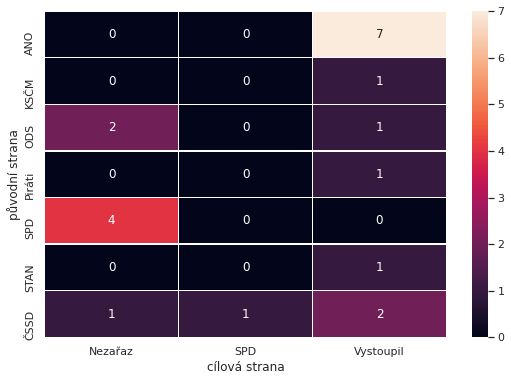

In [27]:
#pocet hlasovani
allvt = df[["meeting", "votenum"]]
allvt.drop_duplicates(subset=["meeting", "votenum"],keep="first",inplace=True) 
nmbvt = allvt.shape[0]

#poslední hlasovani
lstmeet = allvt.meeting.max()
lstvtnum = allvt.votenum.max()

#prebehnuti mezi stranami
pd.options.mode.chained_assignment = None
df["fullname"] = df["firstname"] + " " + df["lastname"]
dfnp = df[["fullname", "party", "date"]]
#dfnp.sort_values("fullname", inplace=True)
dfnp.drop_duplicates(subset=["fullname", "party"],keep="first",inplace=True) 


#odchod
dflft = df[["fullname", "party", "meeting", "votenum", "date"]]
dflft = dflft[ dflft.groupby('fullname')['fullname'].transform('count') < nmbvt ]
dflft.drop_duplicates(subset=["fullname"],keep="last",inplace=True) 
dflft = dflft[ dflft.meeting != lstmeet ]
dflft = dflft[ dflft.votenum != lstvtnum ]
dflft = dflft[["fullname", "party", "date"]]
dflft["party"] = "Vystoupil"

#spojeni vsech poslancu a poslancu co odstoupili
dfnp = pd.concat([dfnp, dflft])

#vyfiltrovani poslancu co meji pouze jednu prislusnost
dfnp = dfnp[dfnp.duplicated(subset=['fullname']) | dfnp.duplicated(subset=['fullname'], keep="last")]
#vytvoreni celeho jmena
rnames = dfnp[["fullname", "party"]]
#ziskani poslancu s prestupy
rnames.drop_duplicates(subset=["fullname"], keep="first", inplace=True)
#vytvoreni listu
rnames_list = rnames.fullname.to_list()

#vyextrahovani stran ze kterych prebehli/odstoupili
justMainParties = rnames[["party"]]
justMainParties.drop_duplicates(subset=["party"], keep="first", inplace=True)
source_list = justMainParties.party.to_list()

# #vytvoreni grafu
# names_graph = {}
# for i in range(len(rnames_list)):
#     name = rnames_list[i]
#     rows = dfnp[dfnp.fullname == name]
#     x = rows.date
#     y = rows.party
#     names_graph[name] = plt.figure(i)
#     plt.plot(x, y, 'o', label="name")
#     plt.legend([name])
# plt.show()

#ziskani puvodnich stran poslancu
srnames = rnames
srnames["originparty"] = srnames.party
srnames = srnames[["fullname", "originparty"]]

#oznaceni u kazdeho poslance jeho prvotni stranu
newOldParty = pd.merge(dfnp, srnames)
newOldParty = newOldParty[newOldParty.party != newOldParty.originparty]
matrix = pd.crosstab(newOldParty.originparty, newOldParty.party)

#vytvoreni grafu
sns.set_theme()
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix, annot=True, fmt="d", linewidth=.5, ax=ax)
ax.set(xlabel='cílová strana', ylabel='původní strana')

* **Jakou mají jednotliví poslanci docházku (účast na hlasování)**
* nejdříve jsem si přeložil hlasovani jednotlivých poslanců
* pokud se nepřihlásili "0" nebo byli omluveni "M" tak je jejich přítomnost označím 0, jako nepřítomné
* pokud hlasovali ano "A", ne "N", zdrželi se "Z", tak je označuji 1, jako přítomné
* následně spočítám počet těchto duplicit v tabulce a výsledkem je dovjice, počet absencí a přítomností na hlasování
* nakonec vypíši graf politiků z jednotlivých stran

<Figure size 432x288 with 0 Axes>

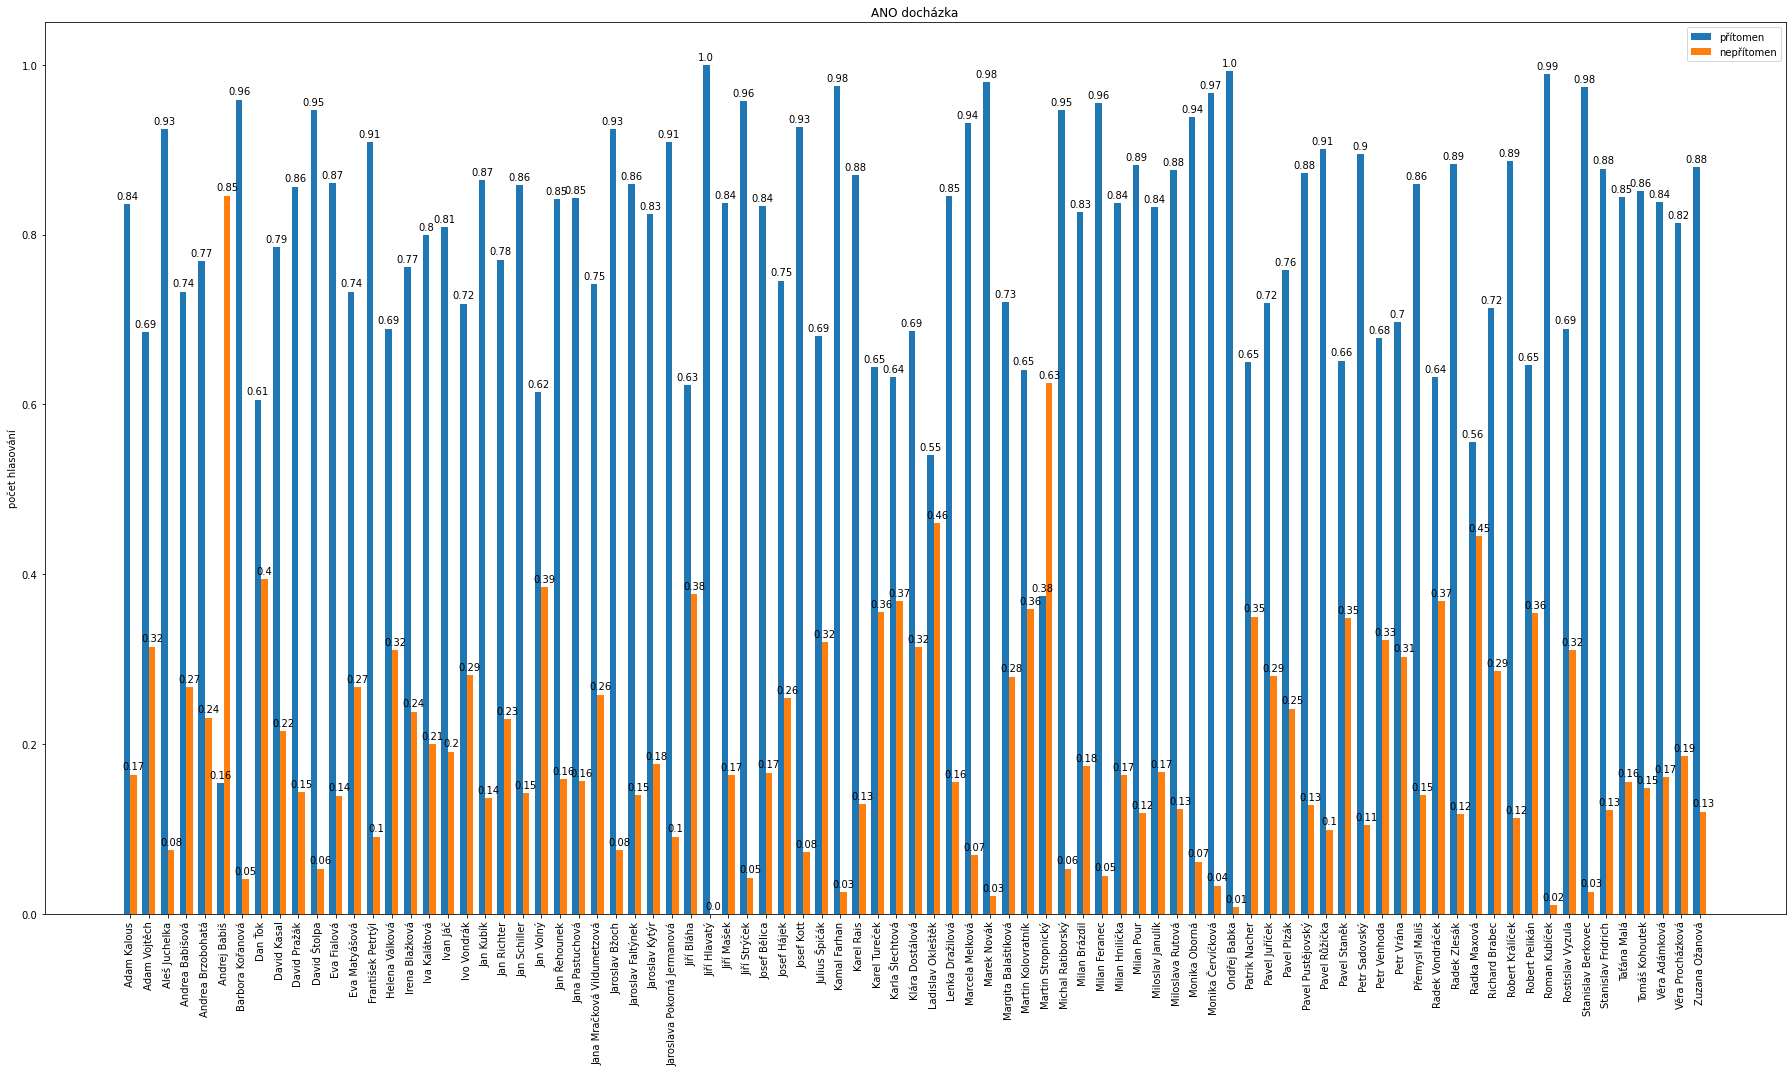

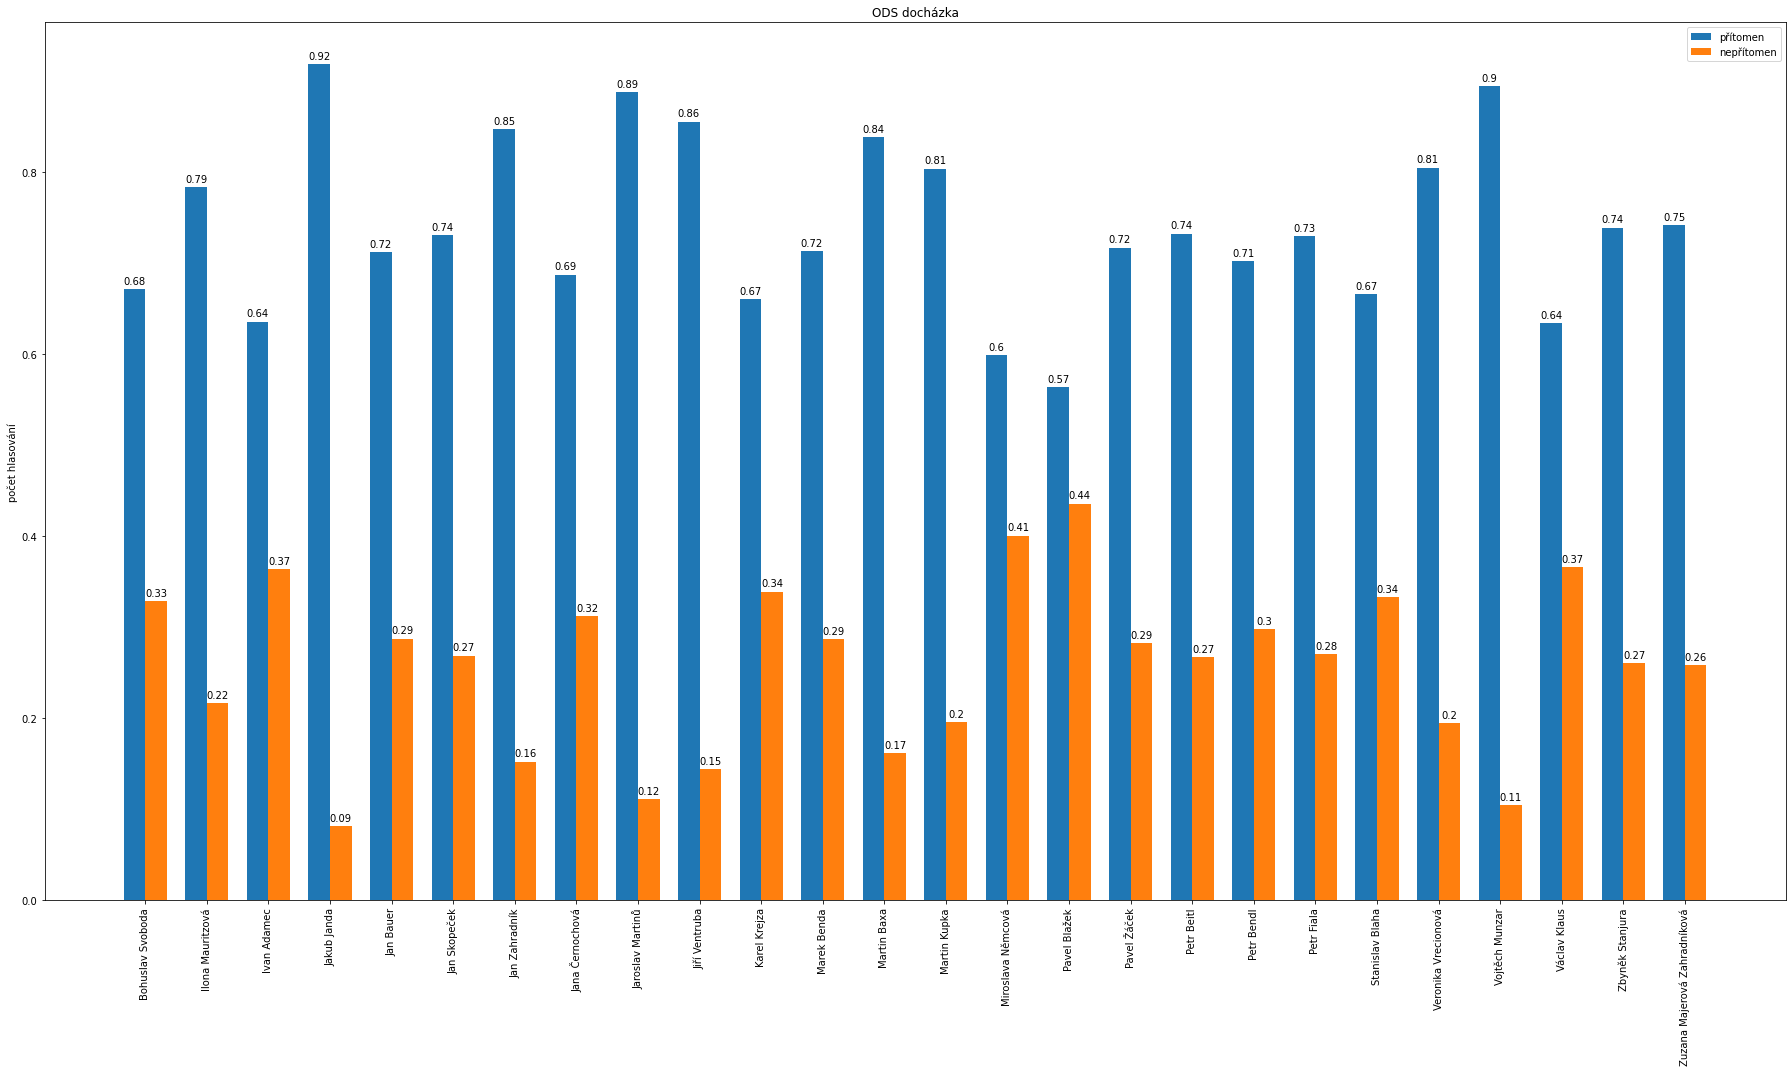

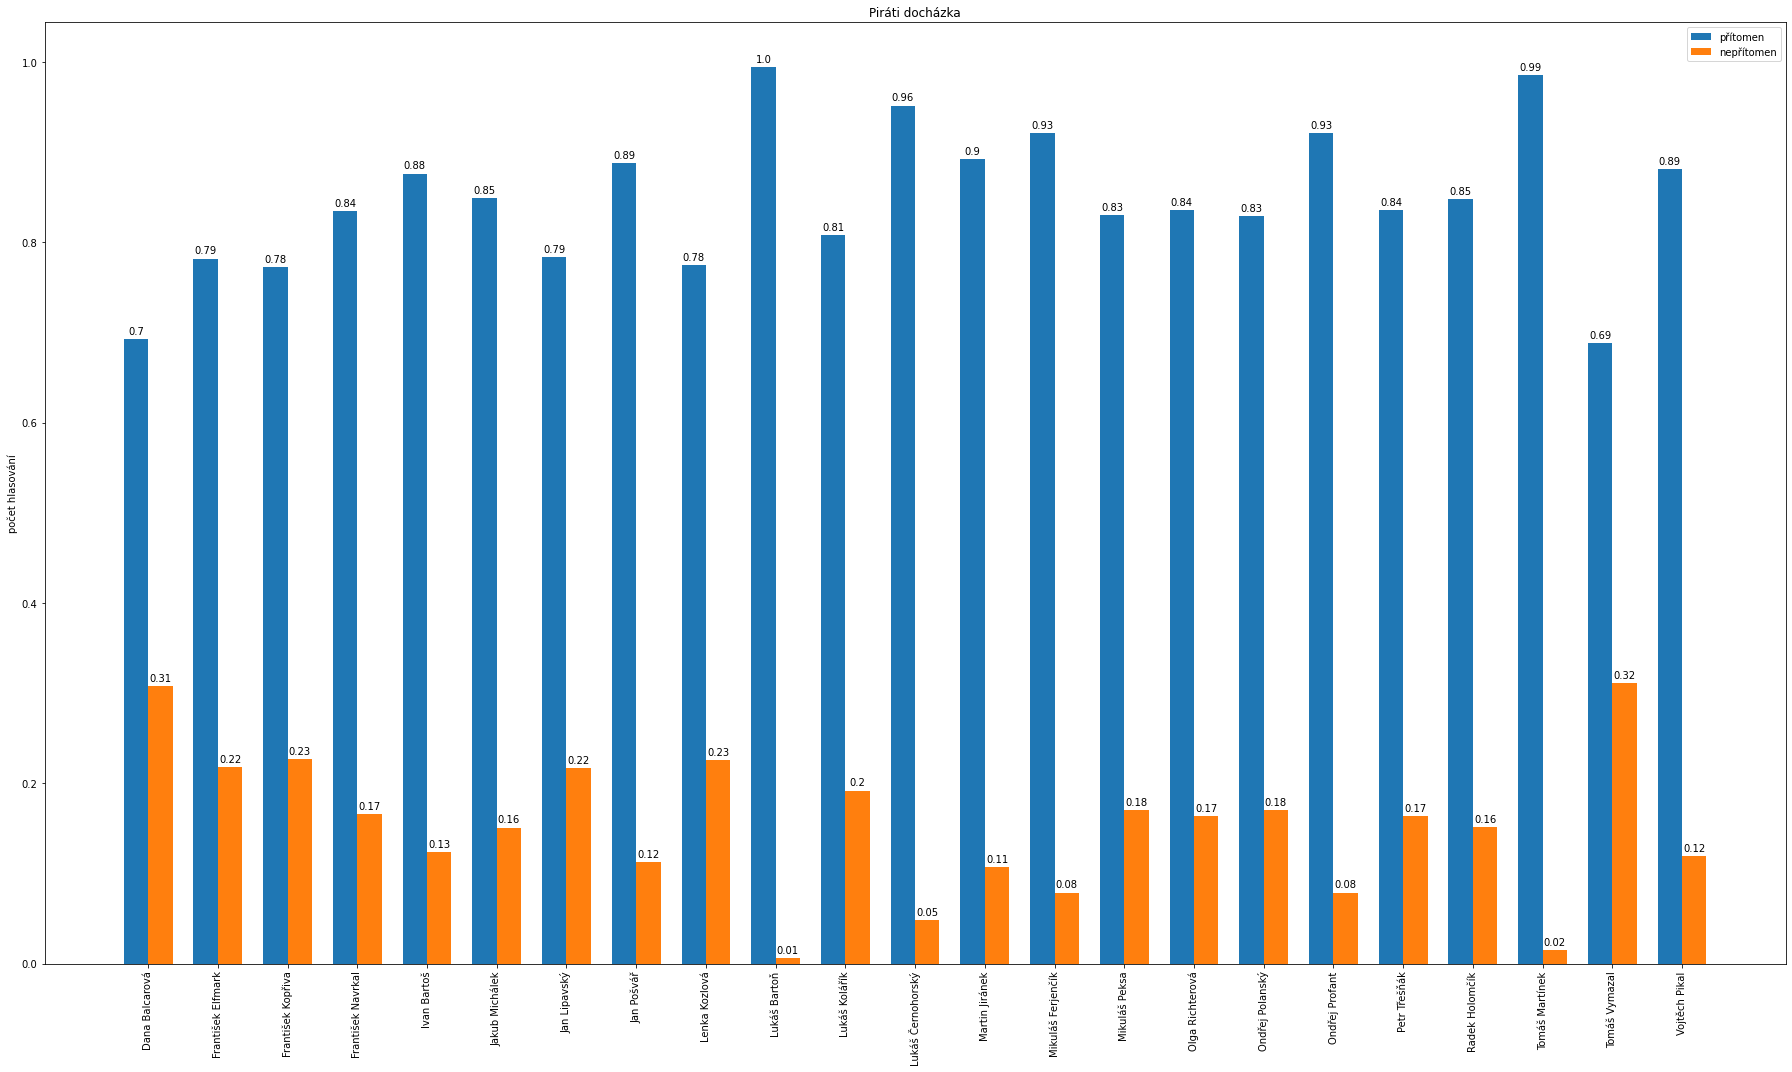

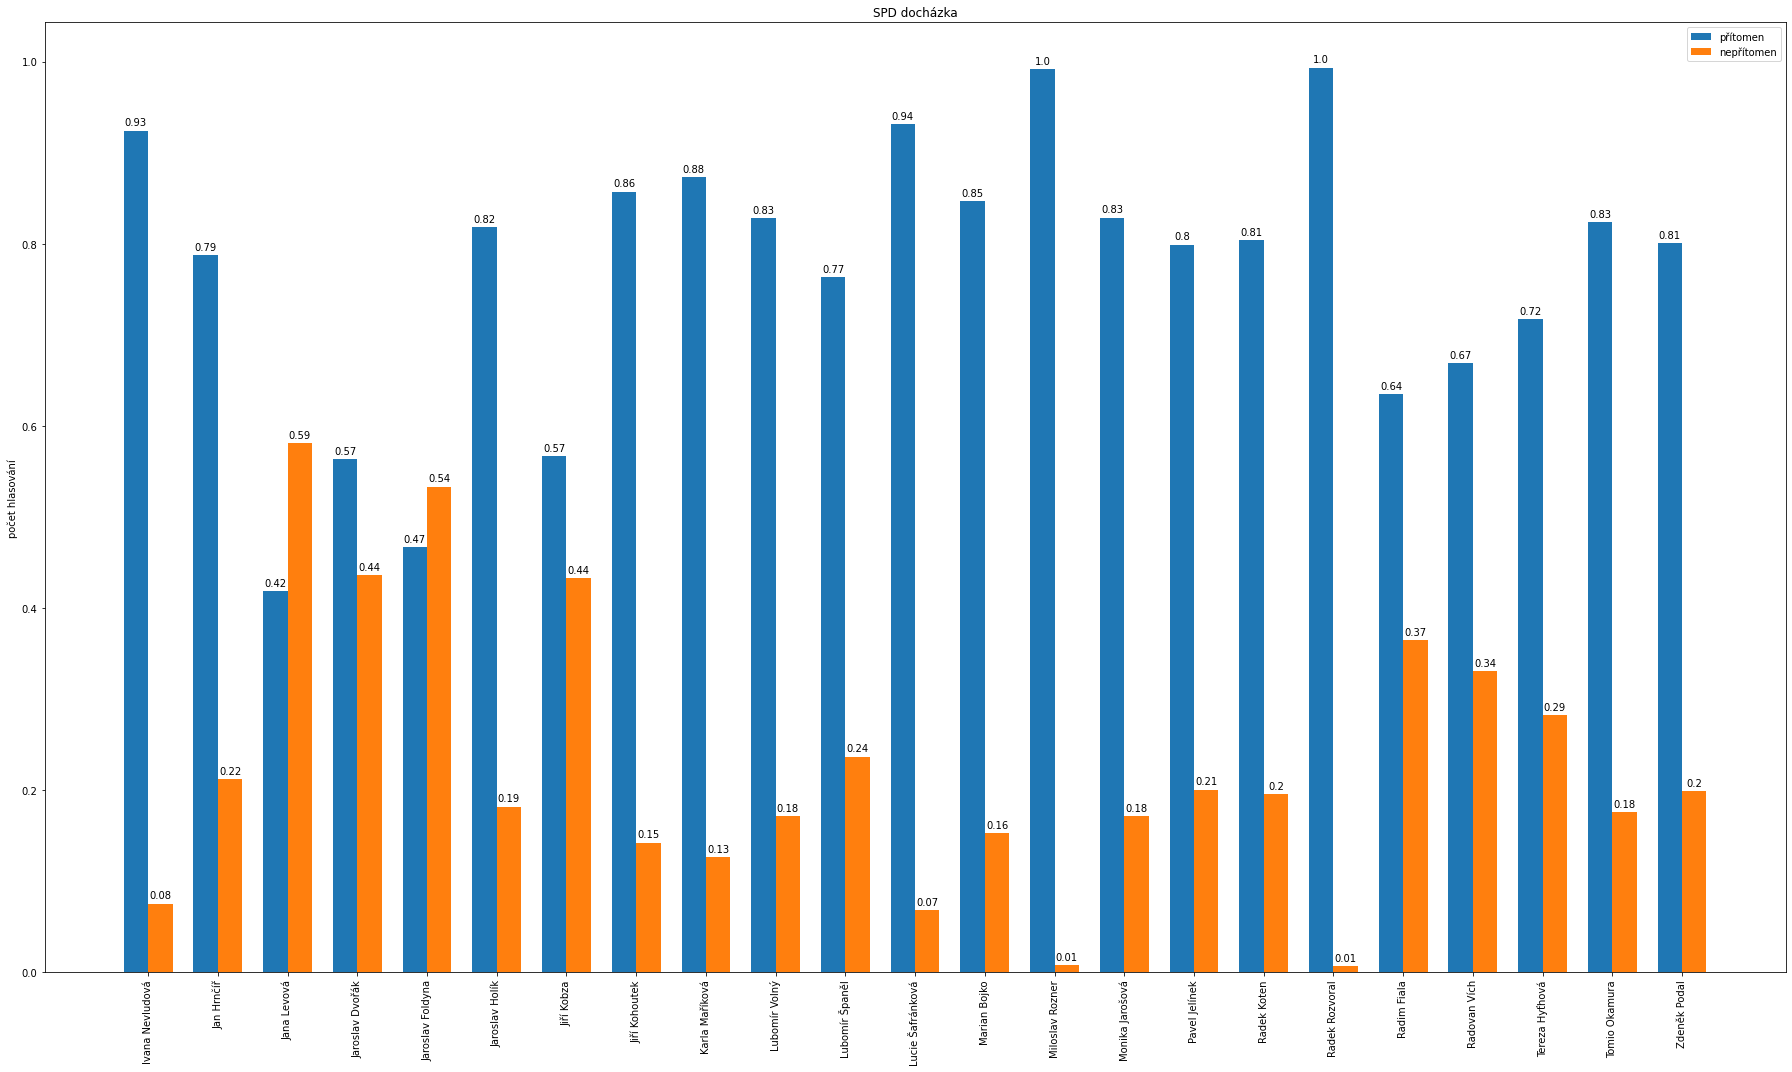

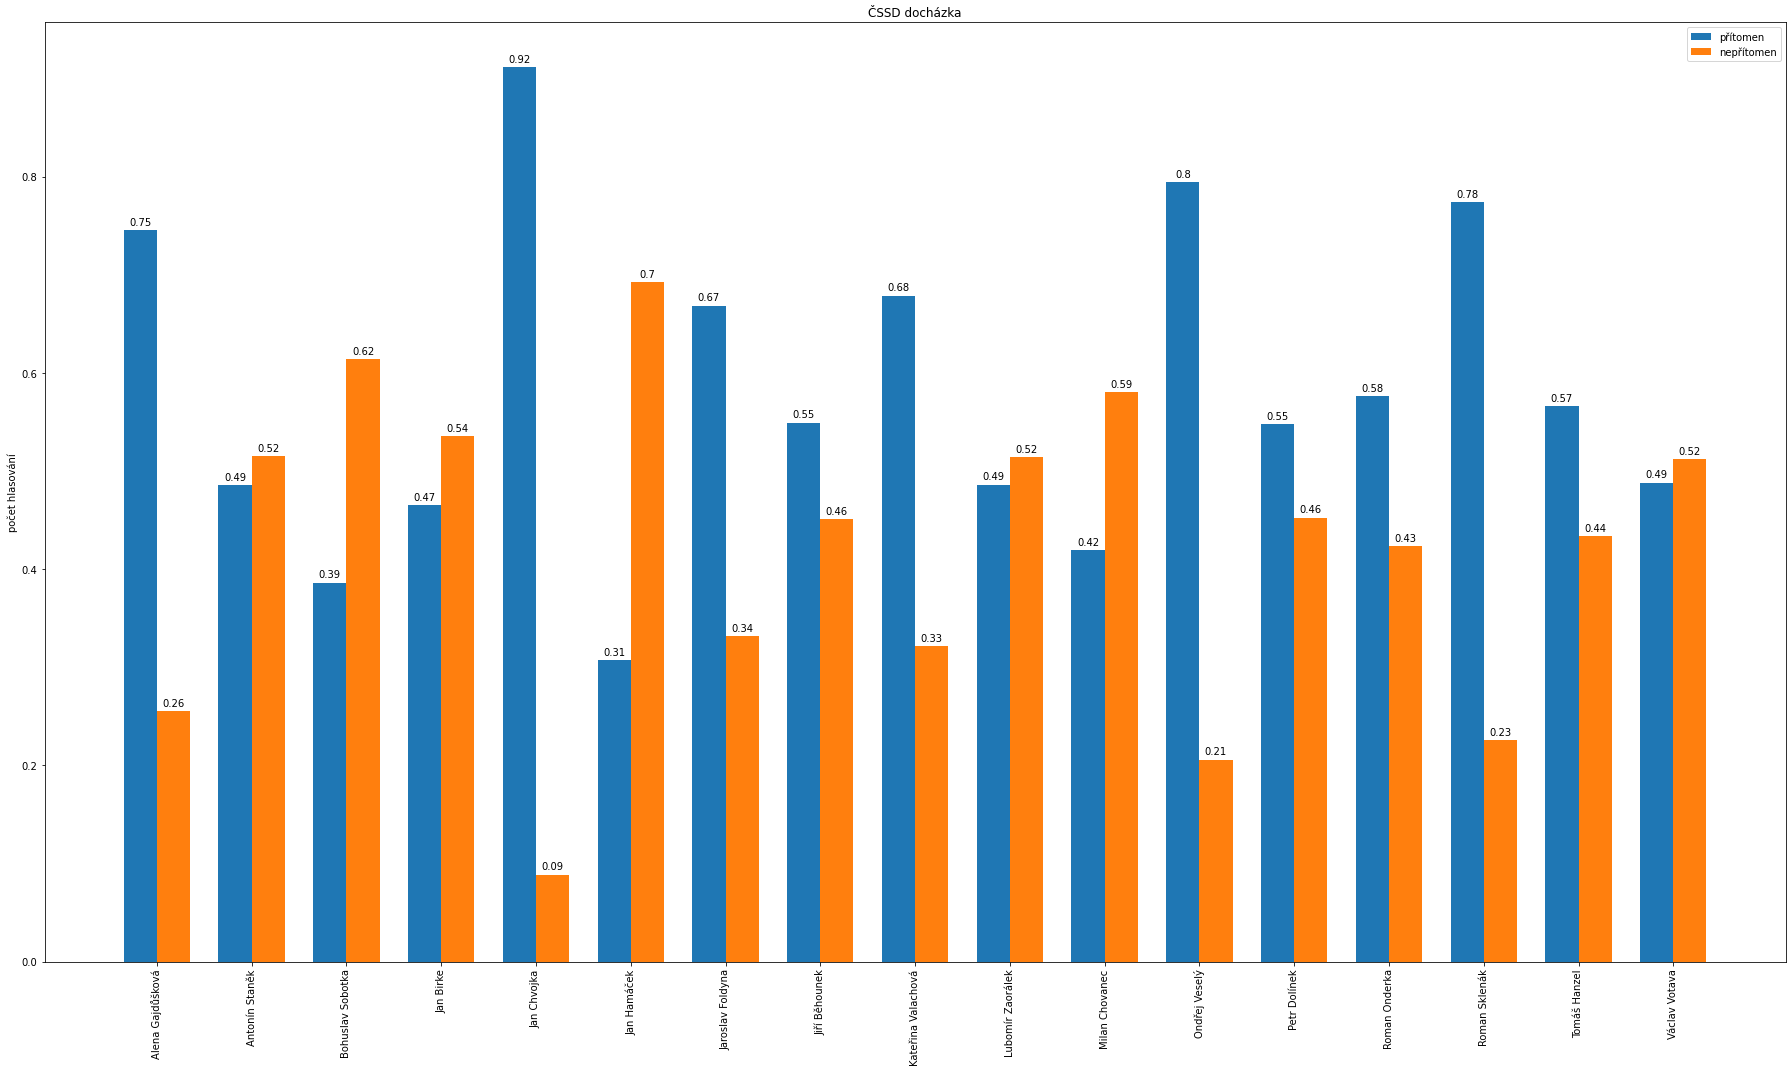

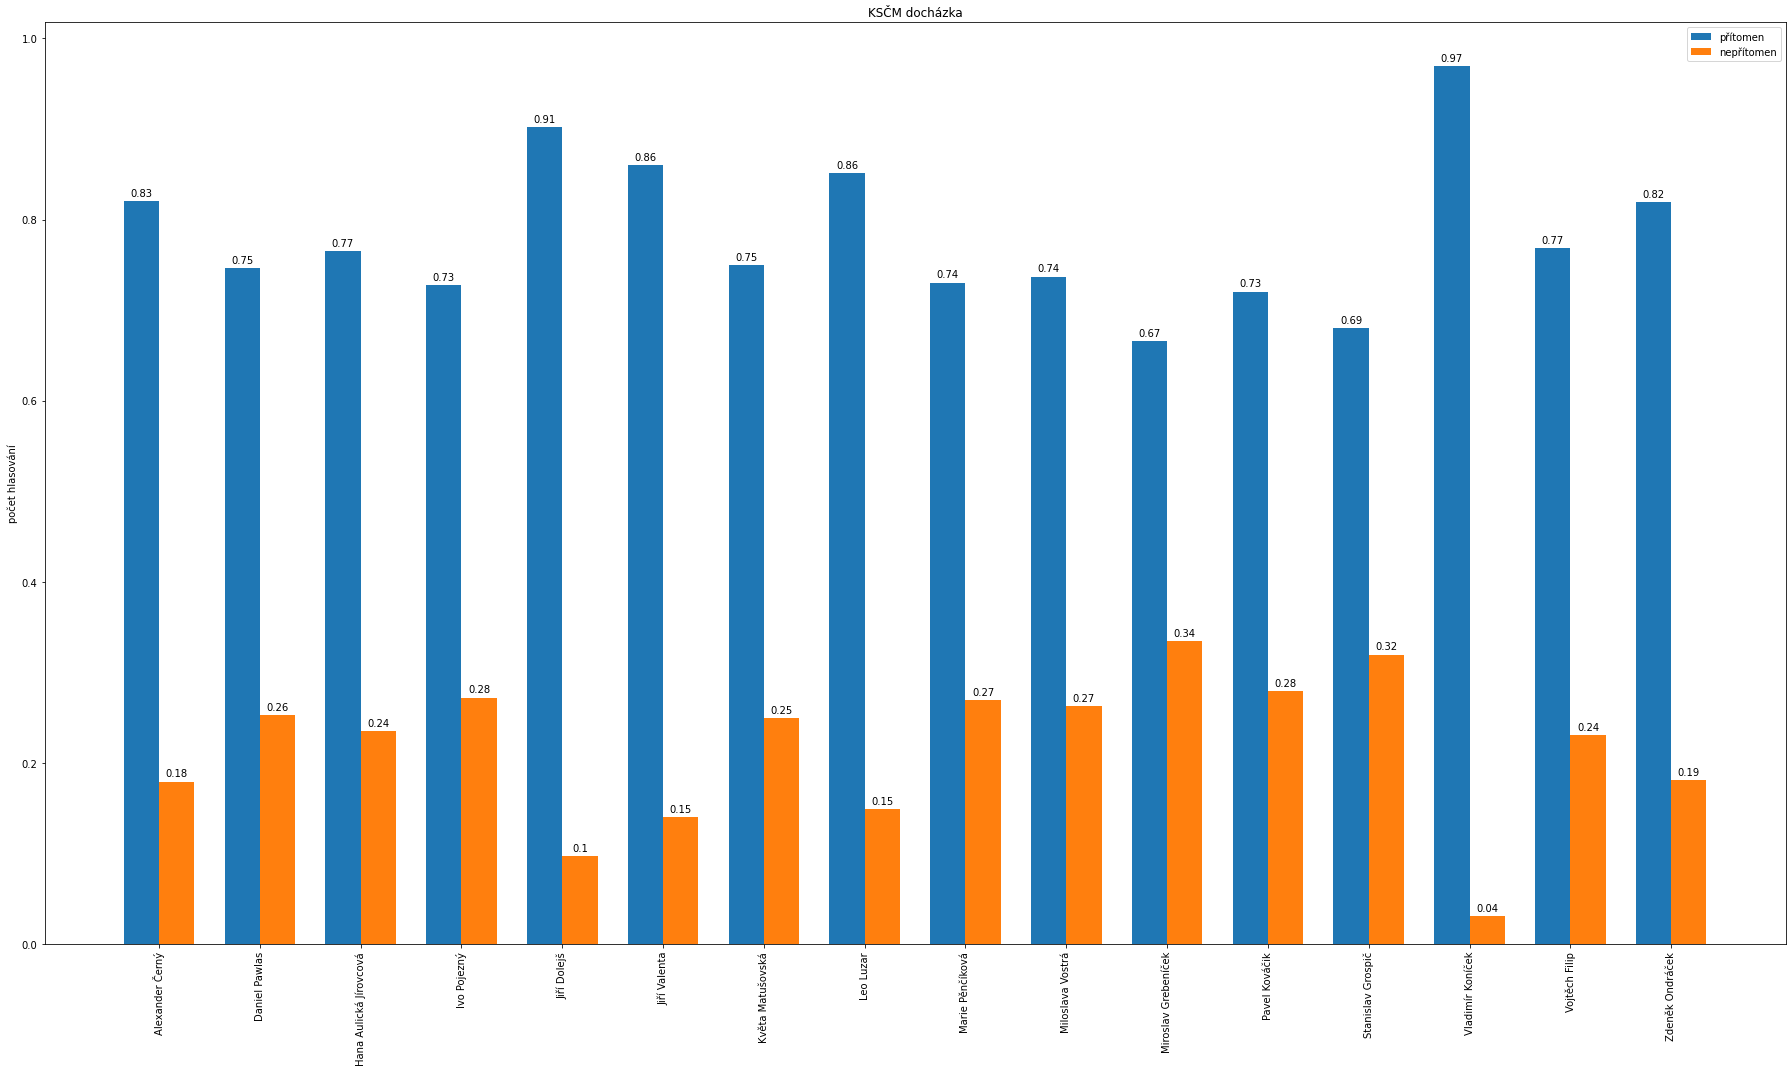

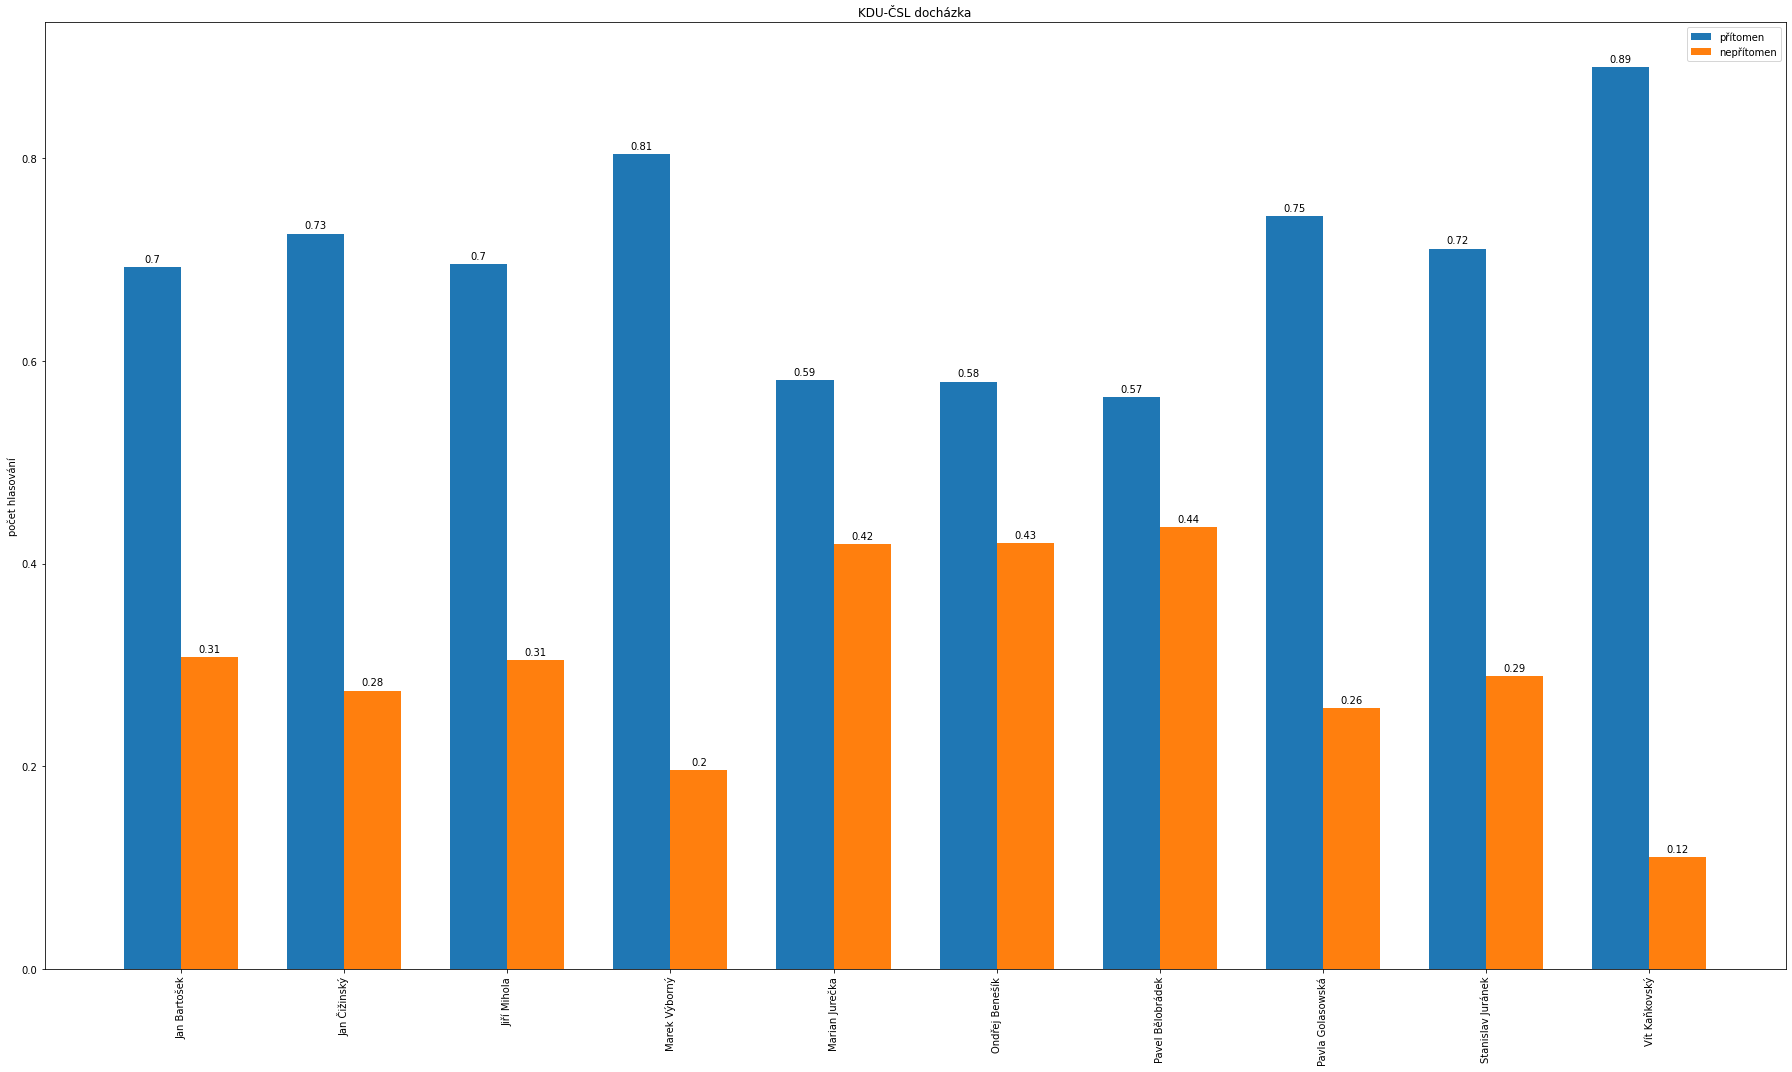

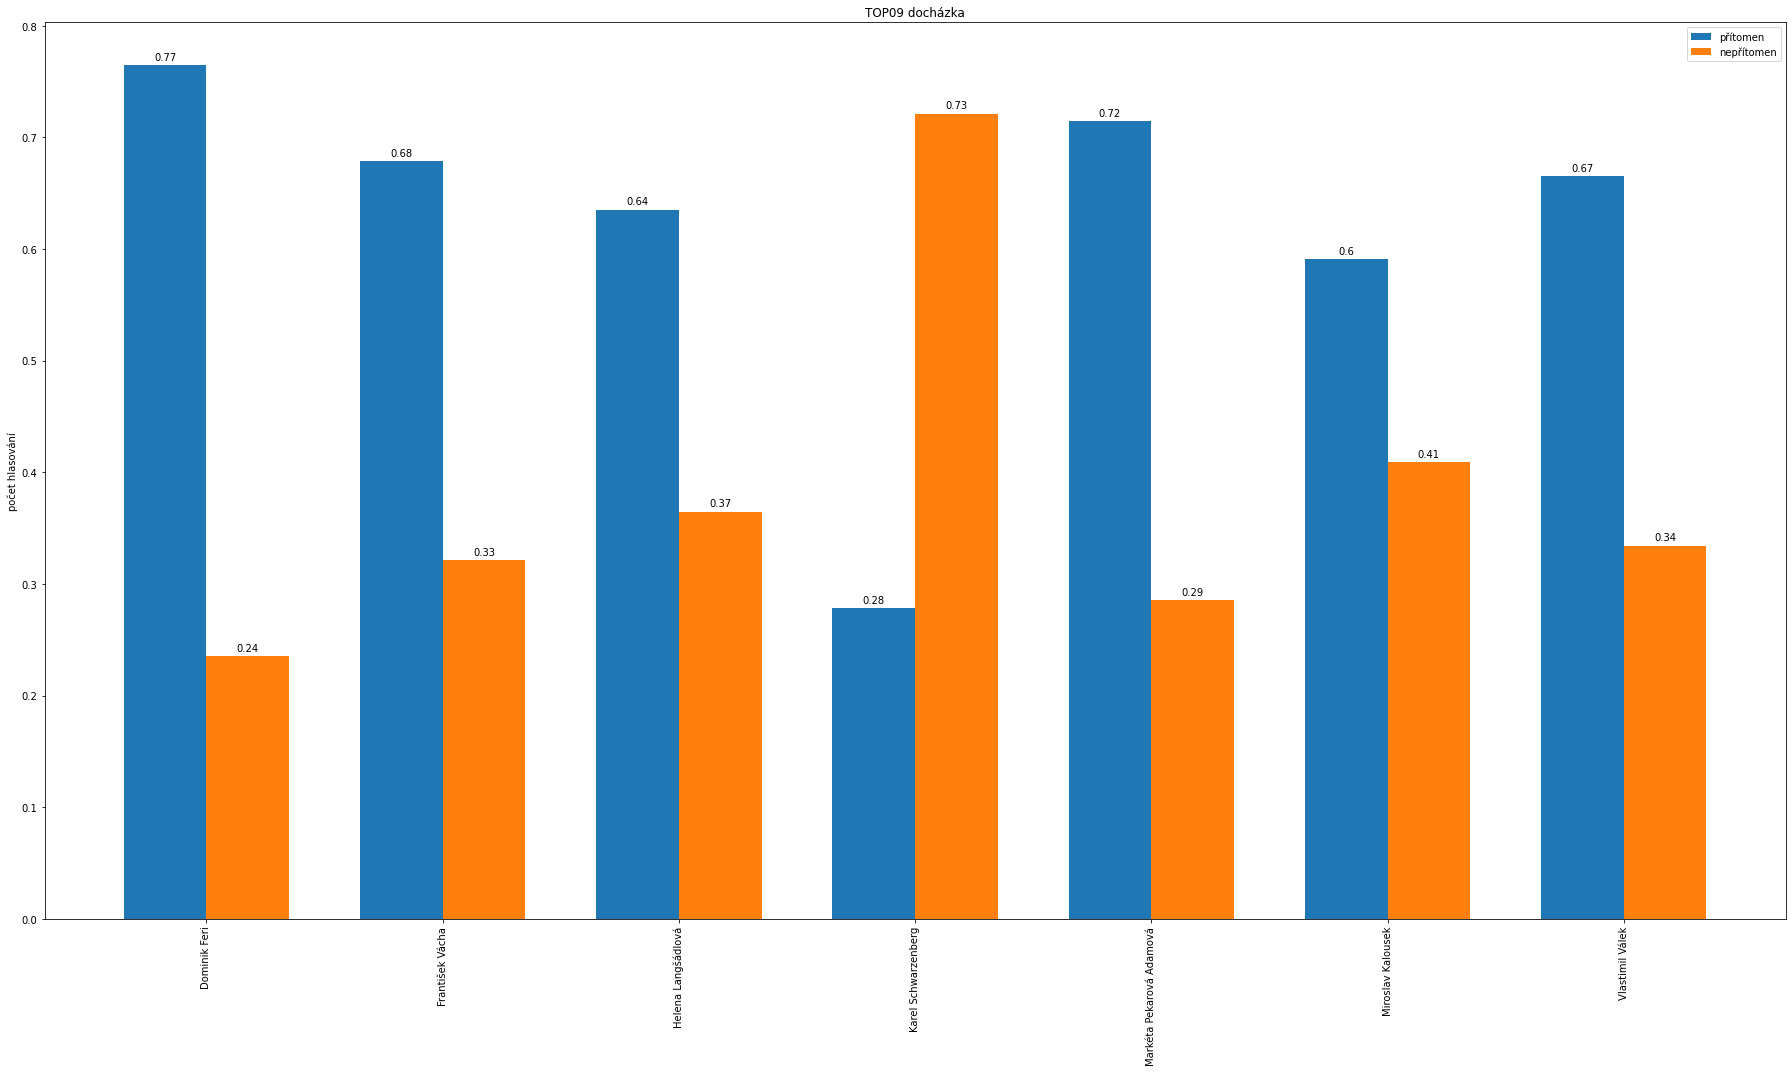

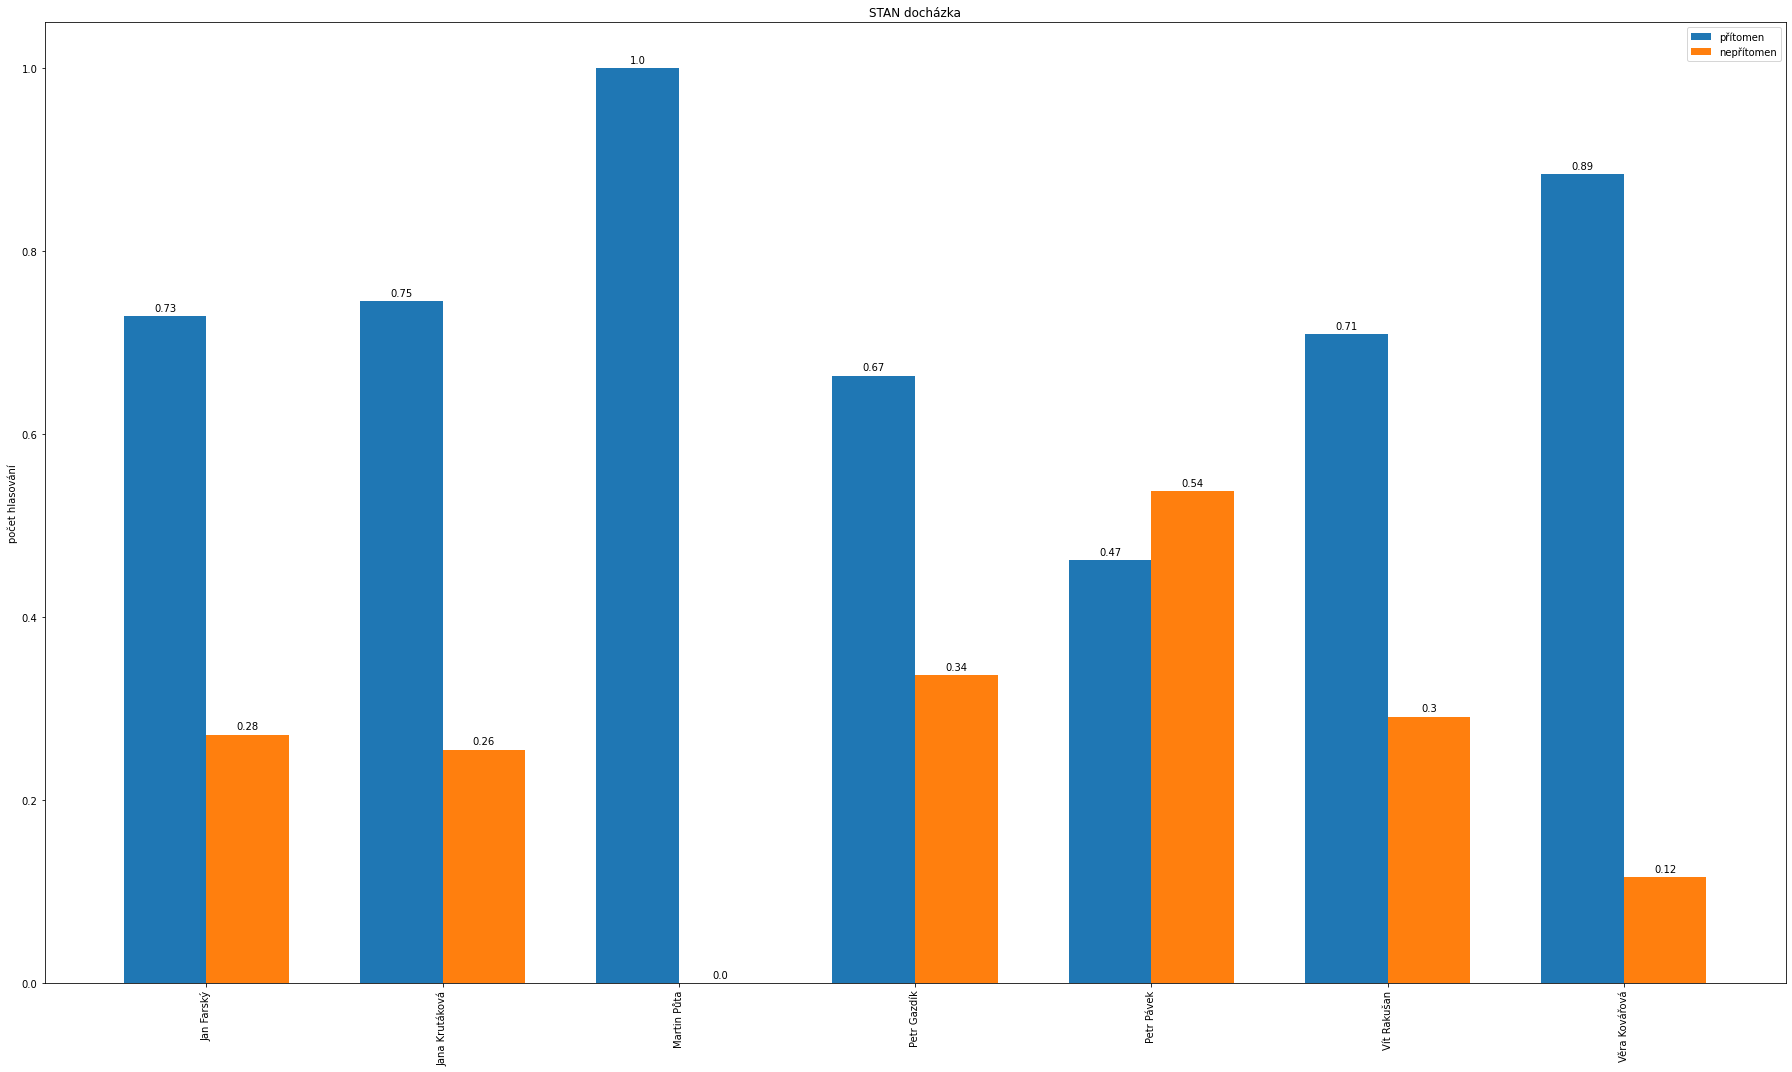

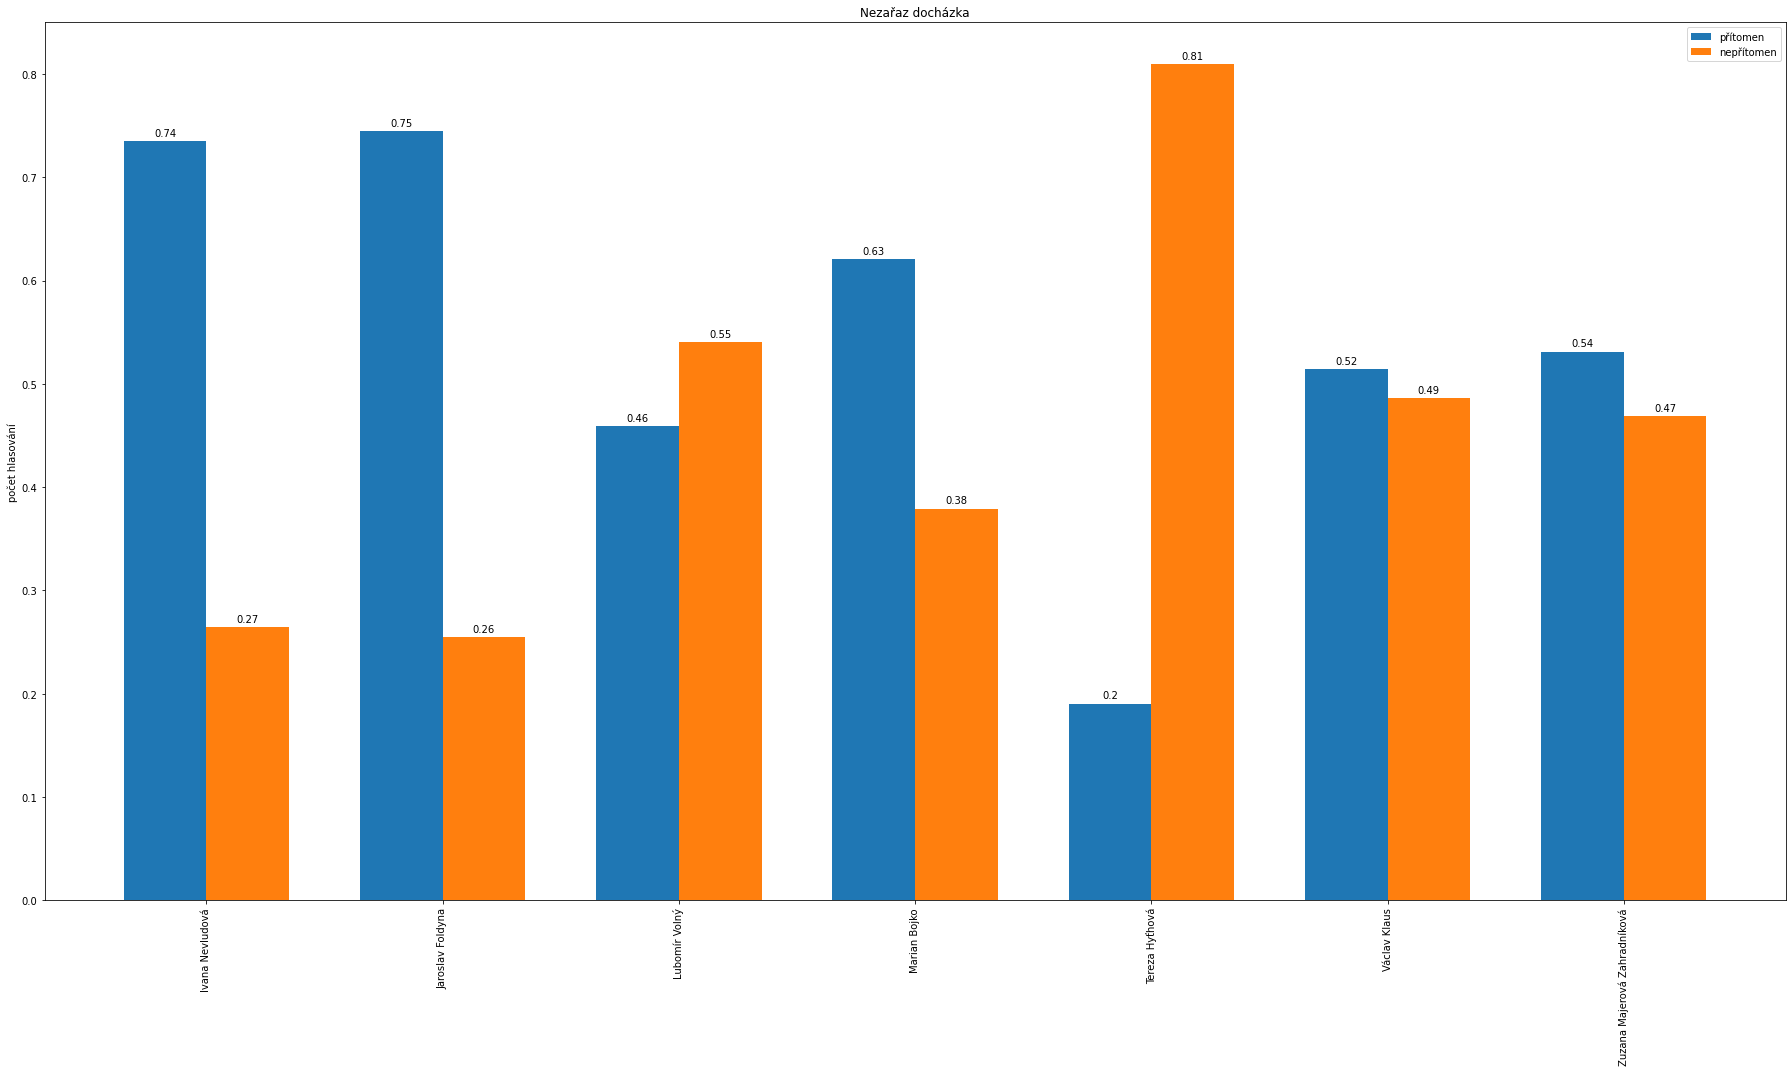

In [5]:
#vytvoreni tabulky s presenci
dfpd = df[["firstname", "lastname", "party", "vote"]]
dfpd["present"] = np.select([(dfpd["vote"] == "0"),(dfpd["vote"] == "M"), (True)], [0, 0, 1])
#ziskani tabulky s pocem presenci a absenci
dfpd = dfpd[["firstname", "lastname", "party", "present"]]
dfpd = dfpd.sort_values(["firstname", "lastname", "present"])
dfpd = dfpd.groupby(dfpd.columns.tolist()).size().reset_index().rename(columns={0:'records'})
#vytvoreni sloupce celeho jmena
dfpd["fullname"] = dfpd.firstname + " " + dfpd.lastname

# #pocet hlasovani
# allvt = df[["meeting", "votenum"]]
# allvt.drop_duplicates(subset=["meeting", "votenum"],keep="first",inplace=True) 
# nmbvt = allvt.shape[0]

#jmena pol. stran
parties = df[["party"]]
parties.drop_duplicates(subset=["party"],keep="first",inplace=True)
parties = parties.party.to_list()

#jmena clenu pol. stran
parties_members={}
all_members = df[["firstname", "lastname", "party"]]
all_members = all_members.sort_values(["firstname", "lastname", "party"])
all_members.drop_duplicates(subset=["firstname", "lastname", "party"],keep="first",inplace=True)
all_members["fullname"] = all_members.firstname + " " + all_members.lastname
for party in parties:
    members = all_members[all_members.party == party]
    parties_members[party] = members.fullname.to_list()

#kod pro popis baru vypujcen z https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        real_height = rect.get_height()
        height = (math.ceil(real_height*100))/100
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, real_height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#create graphs
names_graph = {}
for i in range(len(parties)):
    party = parties[i]
    
    names_graph[party] = plt.figure(i)
    
    N = len(parties_members[party])
    
    members = parties_members[party]
    
    labels = members

    wasntPresent = list()
    wasPresent   = list()
    
    for member in members:
        memberRec = dfpd[dfpd.fullname == member]
        memberRec = memberRec[memberRec.party == party]

        presentRec    = memberRec[memberRec.present==1]
        presentRec    = presentRec.records.to_list()
        notpresentRec = memberRec[memberRec.present==0]
        notpresentRec = notpresentRec.records.to_list()

        presentNum    = 0 if len(presentRec)    == 0 else presentRec[0]
        notpresentNum = 0 if len(notpresentRec) == 0 else notpresentRec[0]
        
        suma = presentNum + notpresentNum
        suma = suma if suma != 0 else 1
        
        presentNum = presentNum/suma
        notpresentNum = notpresentNum/suma
        
        wasPresent.append(presentNum)
        wasntPresent.append(notpresentNum)
        
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(25,15))
    rects1 = ax.bar(x-width/2, wasPresent, width, label='přítomen')
    rects2 = ax.bar(x+width/2, wasntPresent, width, label='nepřítomen')
    
    ax.set_ylabel('procento')
    ax.set_title(party + " docházka")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.xticks(rotation=90)
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    
plt.show()


* **Jak jsou na tom s docházkou strany jako celek.**
* postupuju obdobně jako v předchozím případě, jen sčítám docházku straně, namísto jednotlivců, a to opět pomocí nahrazení voleb jednotlivých poslanců a následně sečtení duplicit

<Figure size 432x288 with 0 Axes>

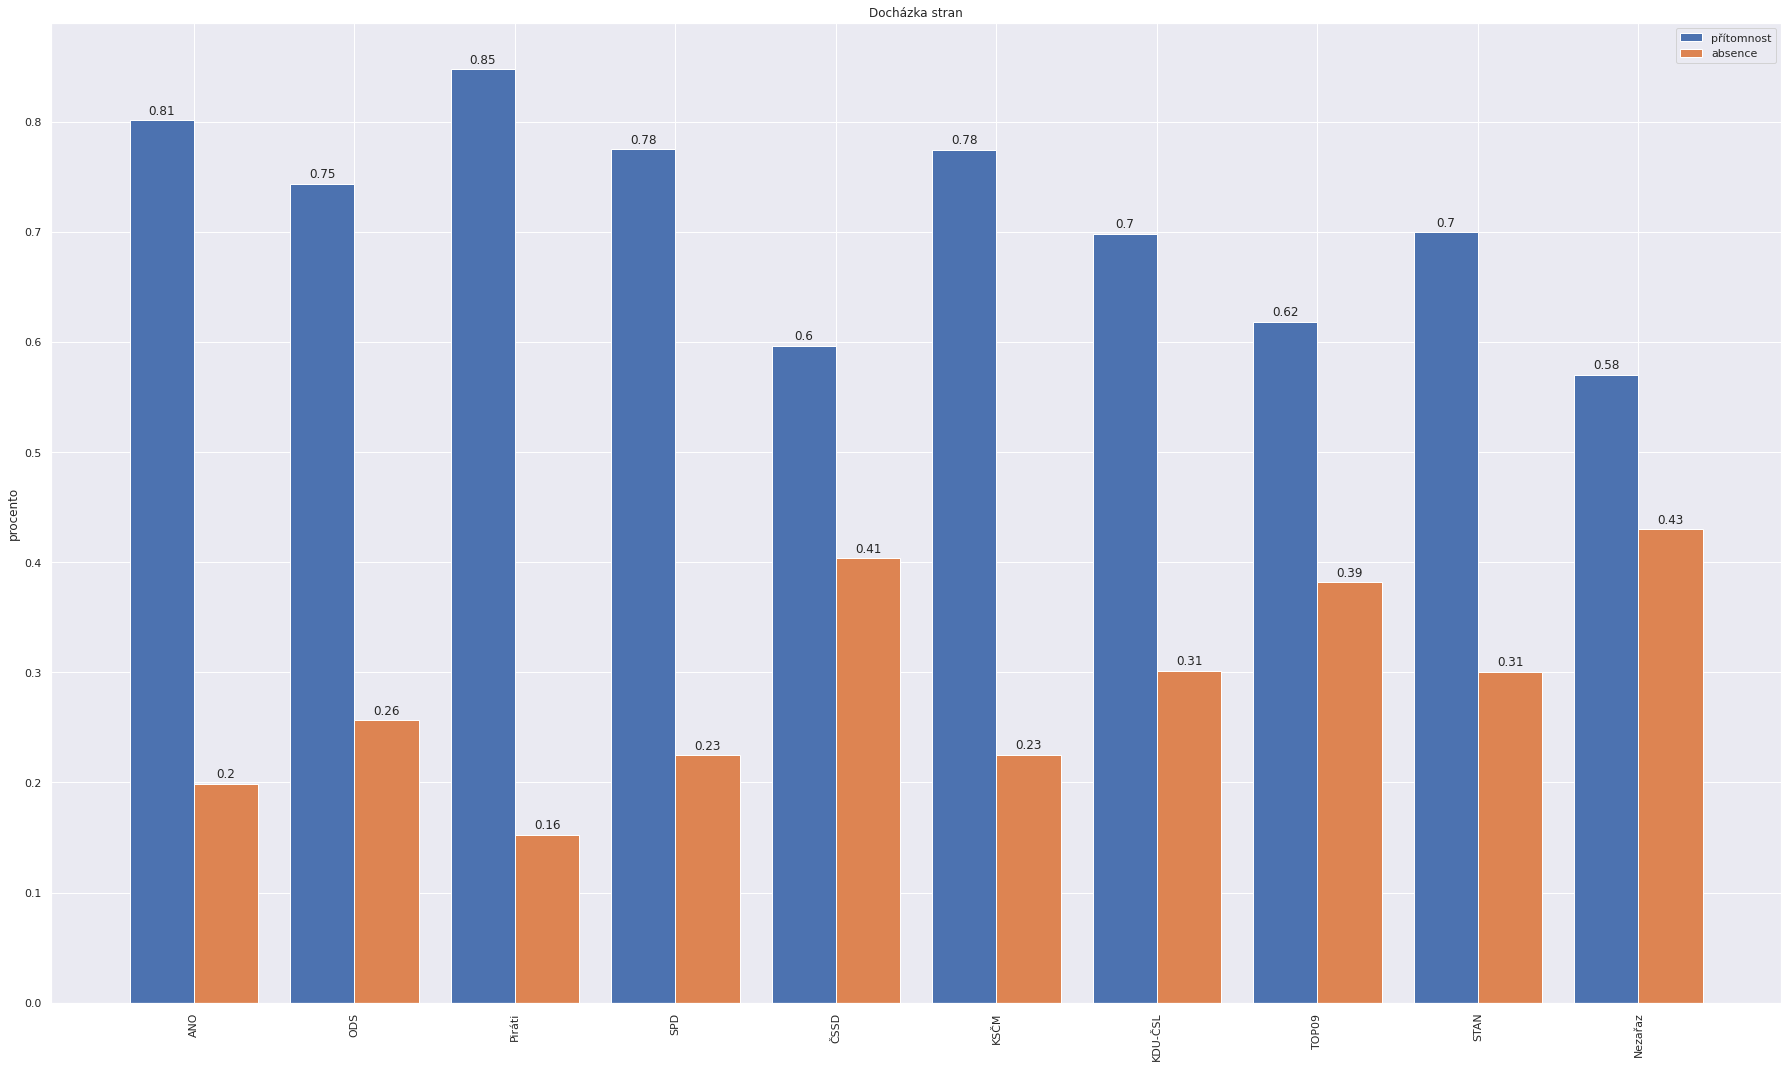

In [28]:
#vytvoreni tabulky 
dfpad = df[["party", "vote"]]
#nahrazeni hlasovani 0 a 1
dfpad["present"] = np.select([(dfpad["vote"] == "0"),(dfpad["vote"] == "M"), (True)], [0, 0, 1])
dfpad = dfpad[["party", "present"]]
dfpad = dfpad.sort_values(["party", "present"])
#secteni dualit
dfpad = dfpad.groupby(dfpad.columns.tolist()).size().reset_index().rename(columns={0:'records'})

#jmena pol. stran
parties = df[["party"]]
parties.drop_duplicates(subset=["party"],keep="first",inplace=True)
parties = parties.party.to_list()


#kod pro popis baru vypujcen z https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        real_height = rect.get_height()
        height = (math.ceil(real_height*100))/100
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, real_height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#create graphs
names_graph = {}

names_graph[party] = plt.figure(i)

N = len(parties)

labels = parties

wasntPresent = list()
wasPresent   = list()

for party in parties:
    partyRec = dfpad[dfpad.party == party]
    
    presentRec     = partyRec[partyRec.present==1]
    presentRec     = presentRec.records.to_list()
    notpresentRec  = partyRec[partyRec.present==0]
    notpresentRec  = notpresentRec.records.to_list()

    presentNum    = 0 if len(presentRec)    == 0 else presentRec[0]
    notpresentNum = 0 if len(notpresentRec) == 0 else notpresentRec[0]
    
    sumPresent     = presentNum + notpresentNum
    sumPresent     = sumPresent if sumPresent != 0 else 1
    
    presentNum     = presentNum/sumPresent
    notpresentNum  = notpresentNum/sumPresent
    
    wasPresent.append(presentNum)
    wasntPresent.append(notpresentNum)


x = np.arange(len(labels))
width = 0.40

fig, ax = plt.subplots(figsize=(25,15))
rects1 = ax.bar(x-width/2, wasPresent, width, label='přítomnost')
rects2 = ax.bar(x+width/2, wasntPresent, width, label='absence')

ax.set_ylabel('procento')
ax.set_title("Docházka stran")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

* **Jak často jsou jednotlivé strany ve shodě a jak často hlasují rozdílně.**
* k získání tohoto údaje jsou třeba tyto kroky
    * vyřadím záznami ve kterých poslanci chybí, nepřihlásili se nebo se omluvili
    * sjednotím hlasování jednotlivých bodů na tři části, počet hlasování A, N a Z
    * tyto hlasování sjednocením získali údaj o tom, kolik poslanců a jak je během hlasování vybralo
    * vyhodnotím si počet celkových hlasování jedné strany jednoho bodu jedné schuzky
    * získám procento vydělením jednotlivých počtů hlasování celkem
    * vyfiltruji záznami tak, aby zůstalo pouze hlasování s největším procento
    * nakonci získám počet hlasování kde je toto procento větší než 0.7, což je mnou zadaná hranice

<Figure size 432x288 with 0 Axes>

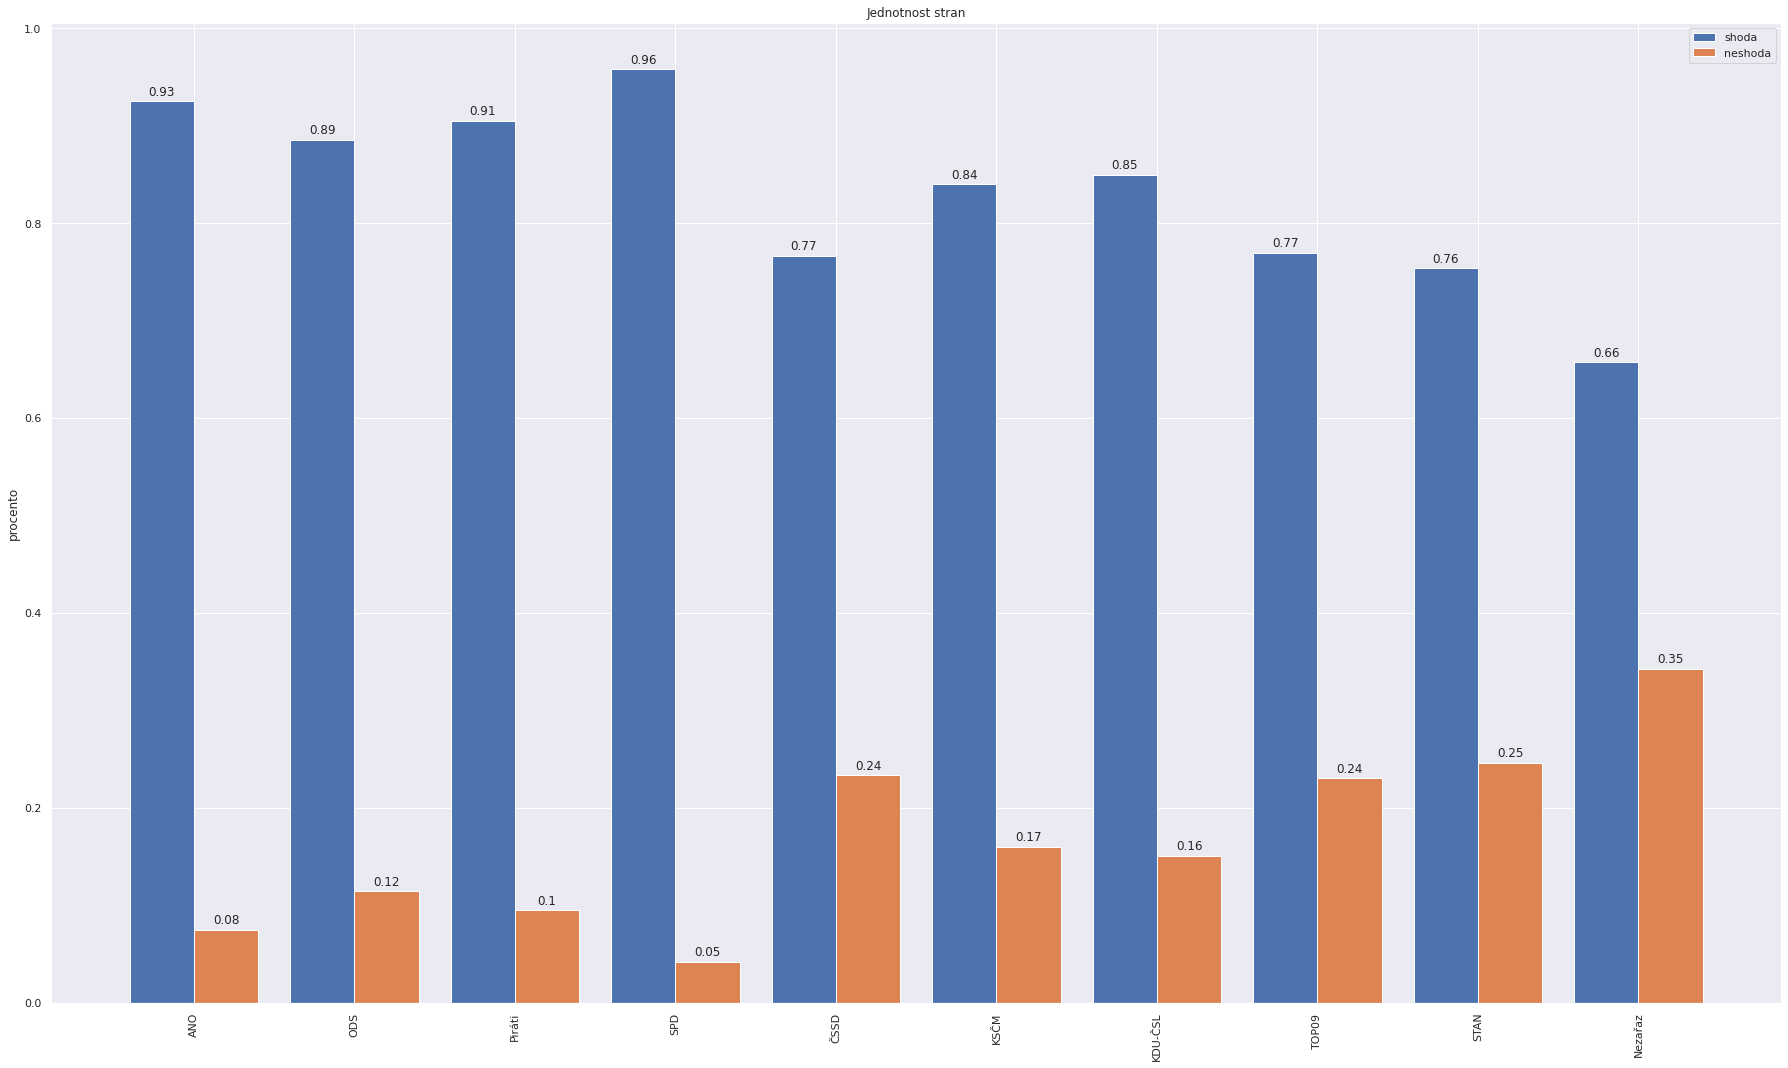

In [29]:
#ziskani tabulky
dfsh = df[["party", "vote", "meeting", "point"]]
#vyfiltrovani zaznamu
dfsh = dfsh[dfsh.vote != "0"]
dfsh = dfsh[dfsh.vote != "M"]

#count total of entries
ttlhl = dfsh.groupby(["party", "meeting", "point"]).size().reset_index().rename(columns={0:'rrecords'})

#spocteni jednotlivych hlasovani jednoho bodu jedne schuze
dfsh = dfsh.groupby(dfsh.columns.tolist()).size().reset_index().rename(columns={0:'records'})
dfsh = dfsh.sort_values(["party", "meeting", "point"])

#get numbers of meetings
mtnbrs = dfsh[["meeting"]]
mtnbrs.drop_duplicates(subset=["meeting"],keep="last",inplace=True)
mtnbrs = mtnbrs.sort_values(["meeting"])
mtnbrs = mtnbrs.meeting.to_list()

#get parties
parties = df[["party"]]
parties.drop_duplicates(subset=["party"],keep="first",inplace=True)
parties = parties.party.to_list()

#spojeni celkoveho poctu hlasu jedne strany na jedne schuzi jednoho bodu
ddf = pd.merge(dfsh, ttlhl)
#vypocteni procenta
ddf["perc"] = ddf.records/ddf.rrecords
ddf = ddf.sort_values(["party", "meeting", "point", "perc"])
ddf.drop_duplicates(subset=["party", "meeting", "point"],keep="last",inplace=True)

ddf["new"] = ddf.apply(lambda row: str(row.meeting) +"|"+ str(row.point), axis=1)
ddf = ddf[["party", "meeting", "point", "new", "perc"]]


#kod pro popis baru vypujcen z https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        real_height = rect.get_height()
        height = (math.ceil(real_height*100))/100
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, real_height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#create graphs
names_graph = {}

names_graph[party] = plt.figure(i)

N = len(parties)

labels = parties

united      = list()
notunited   = list()

#all_members[all_members.party == party]
for party in parties:
    partyRec = ddf[ddf.party == party]
    
    unitedRec     = partyRec[partyRec.perc>=0.7]
    unitedRec     = unitedRec.perc.to_list()
    notunitedRec  = partyRec[partyRec.perc<0.7]
    notunitedRec  = notunitedRec.perc.to_list()    

    unitedNum    = len(unitedRec)
    notunitedNum = len(notunitedRec)
    
    suma     = unitedNum + notunitedNum
    suma     = suma if suma != 0 else 1
    
    unitedNum     = unitedNum/suma
    notunitedNum  = notunitedNum/suma
    
    united.append(unitedNum)
    notunited.append(notunitedNum)


x = np.arange(len(labels))
width = 0.40

fig, ax = plt.subplots(figsize=(25,15))
rects1 = ax.bar(x-width/2, united, width, label='shoda')
rects2 = ax.bar(x+width/2, notunited, width, label='neshoda')

ax.set_ylabel('procento')
ax.set_title("Jednotnost stran")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

* **Jak jsou poslanci jednotlivých stran jednotní v hlasování**
* postup je obdobný jako tomu předešlému
* namísto stran však počítáme poměry jednotlivým poslancům
* to udělám tak, že získám hlasování jednotho poslance a porovnám to s hlasováním většiny z jedné schůze jednoho bodu
* jednotlivé poslance vypíšeme do grafu s ostatními poslanci daného klubu

<Figure size 432x288 with 0 Axes>

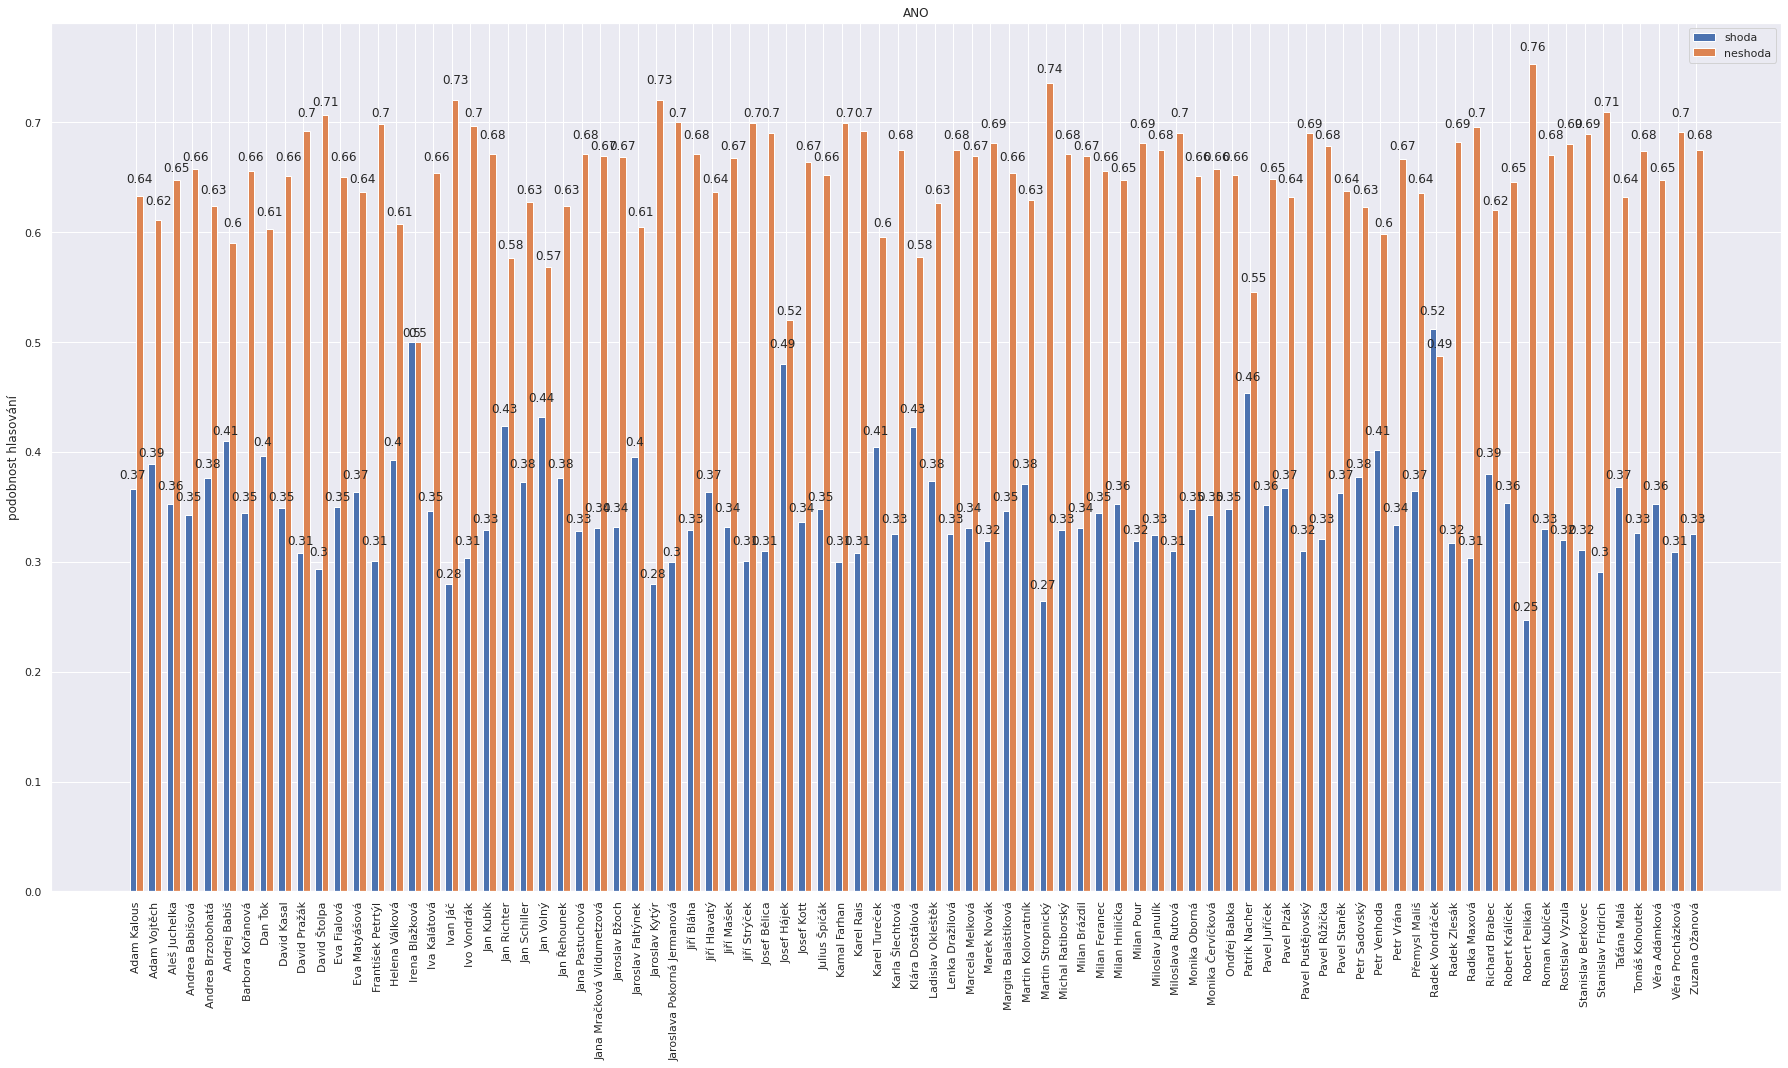

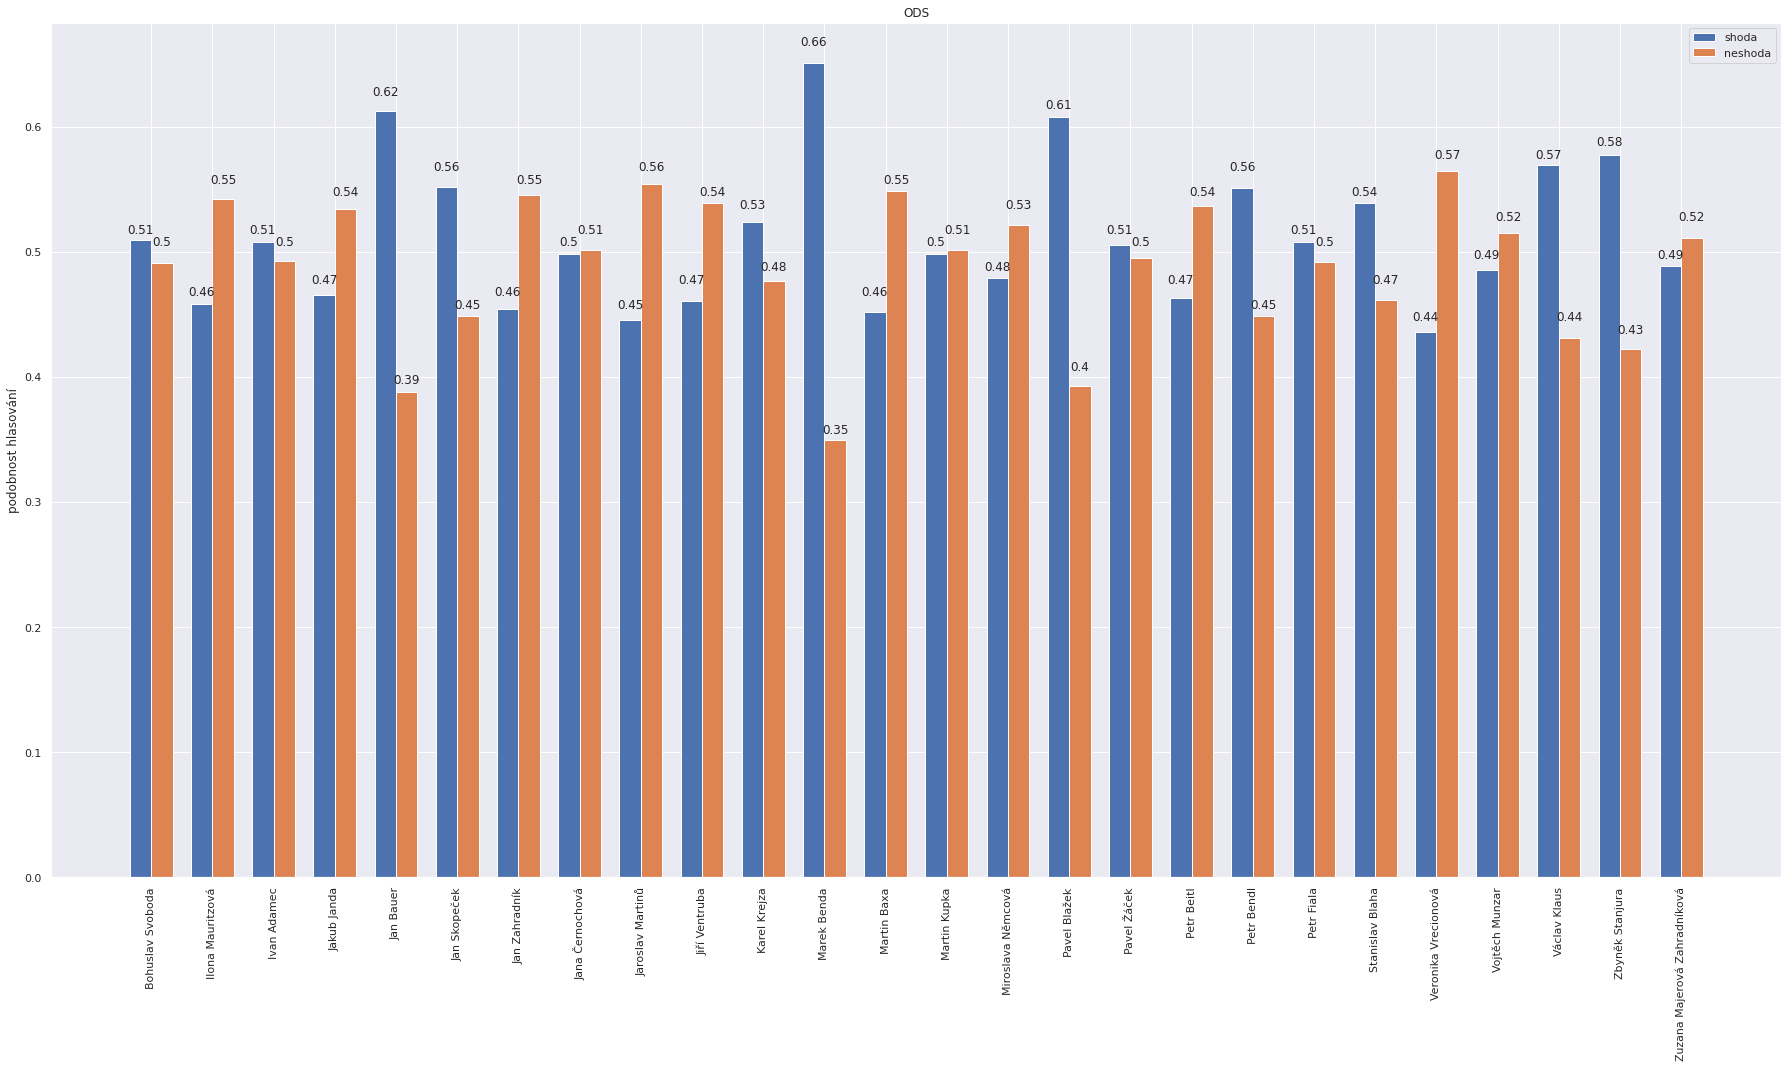

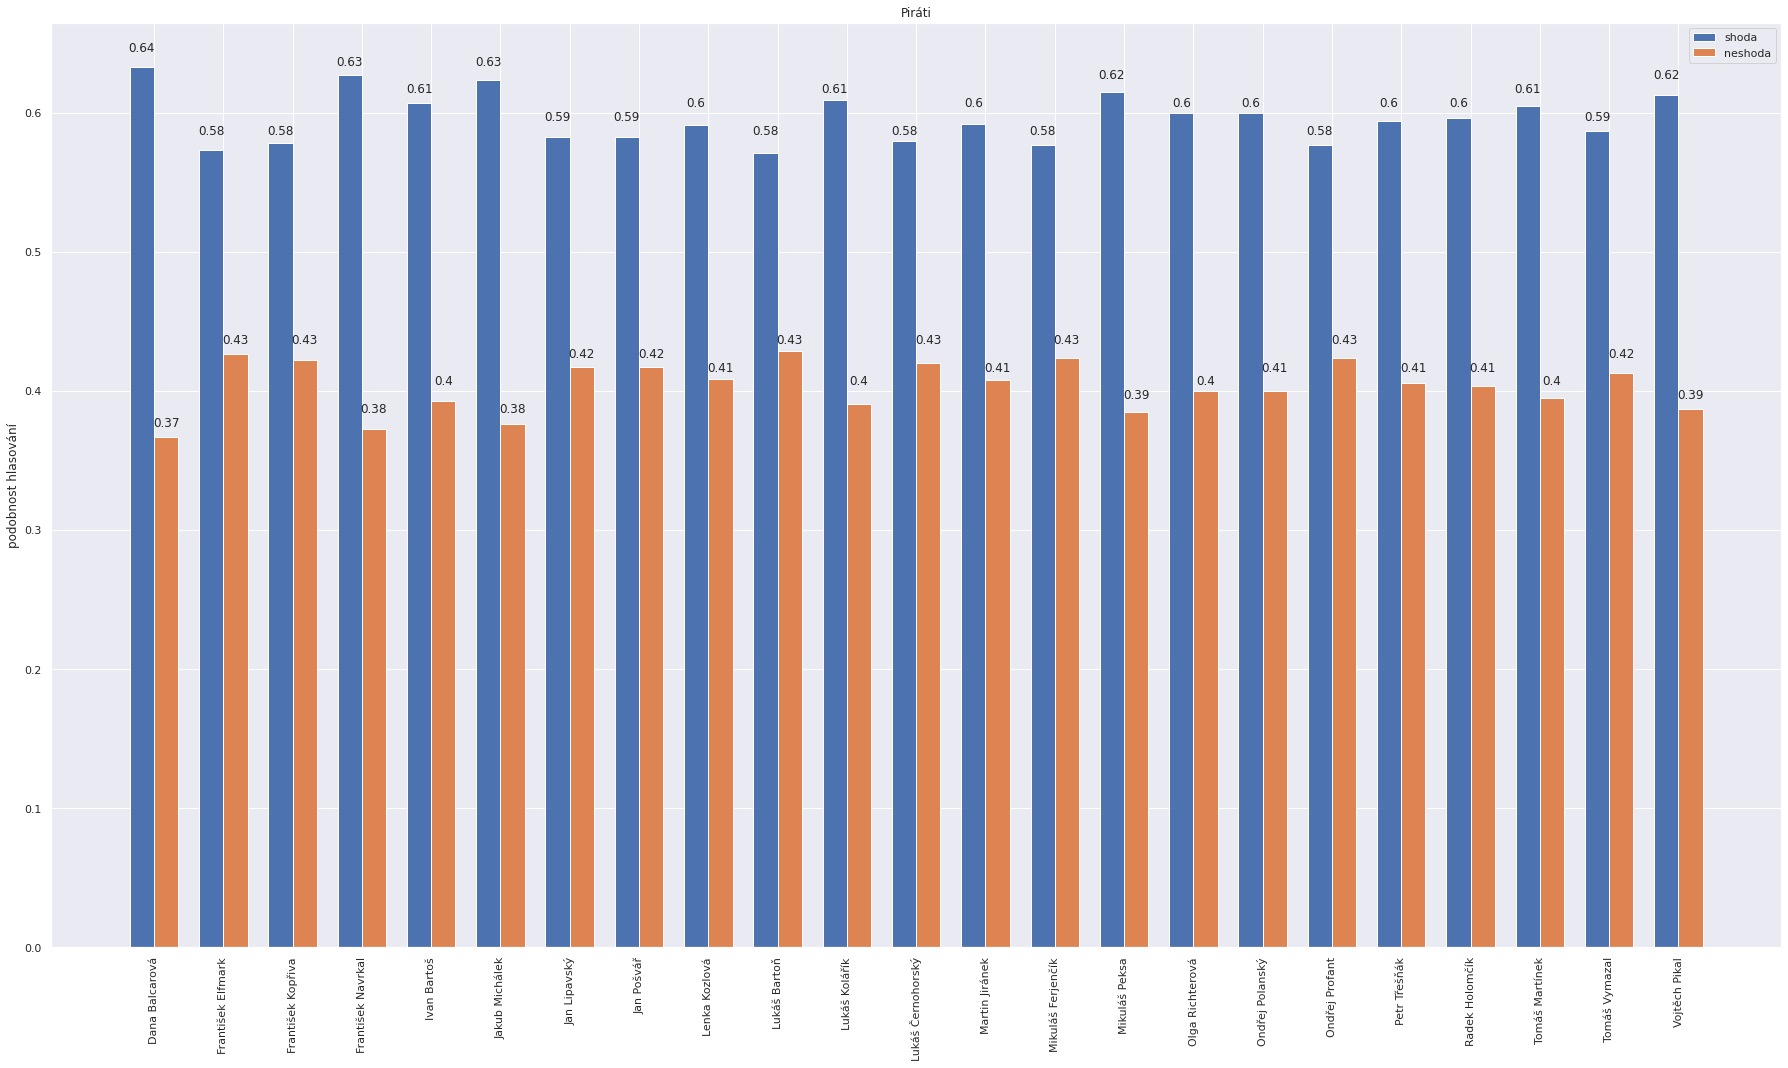

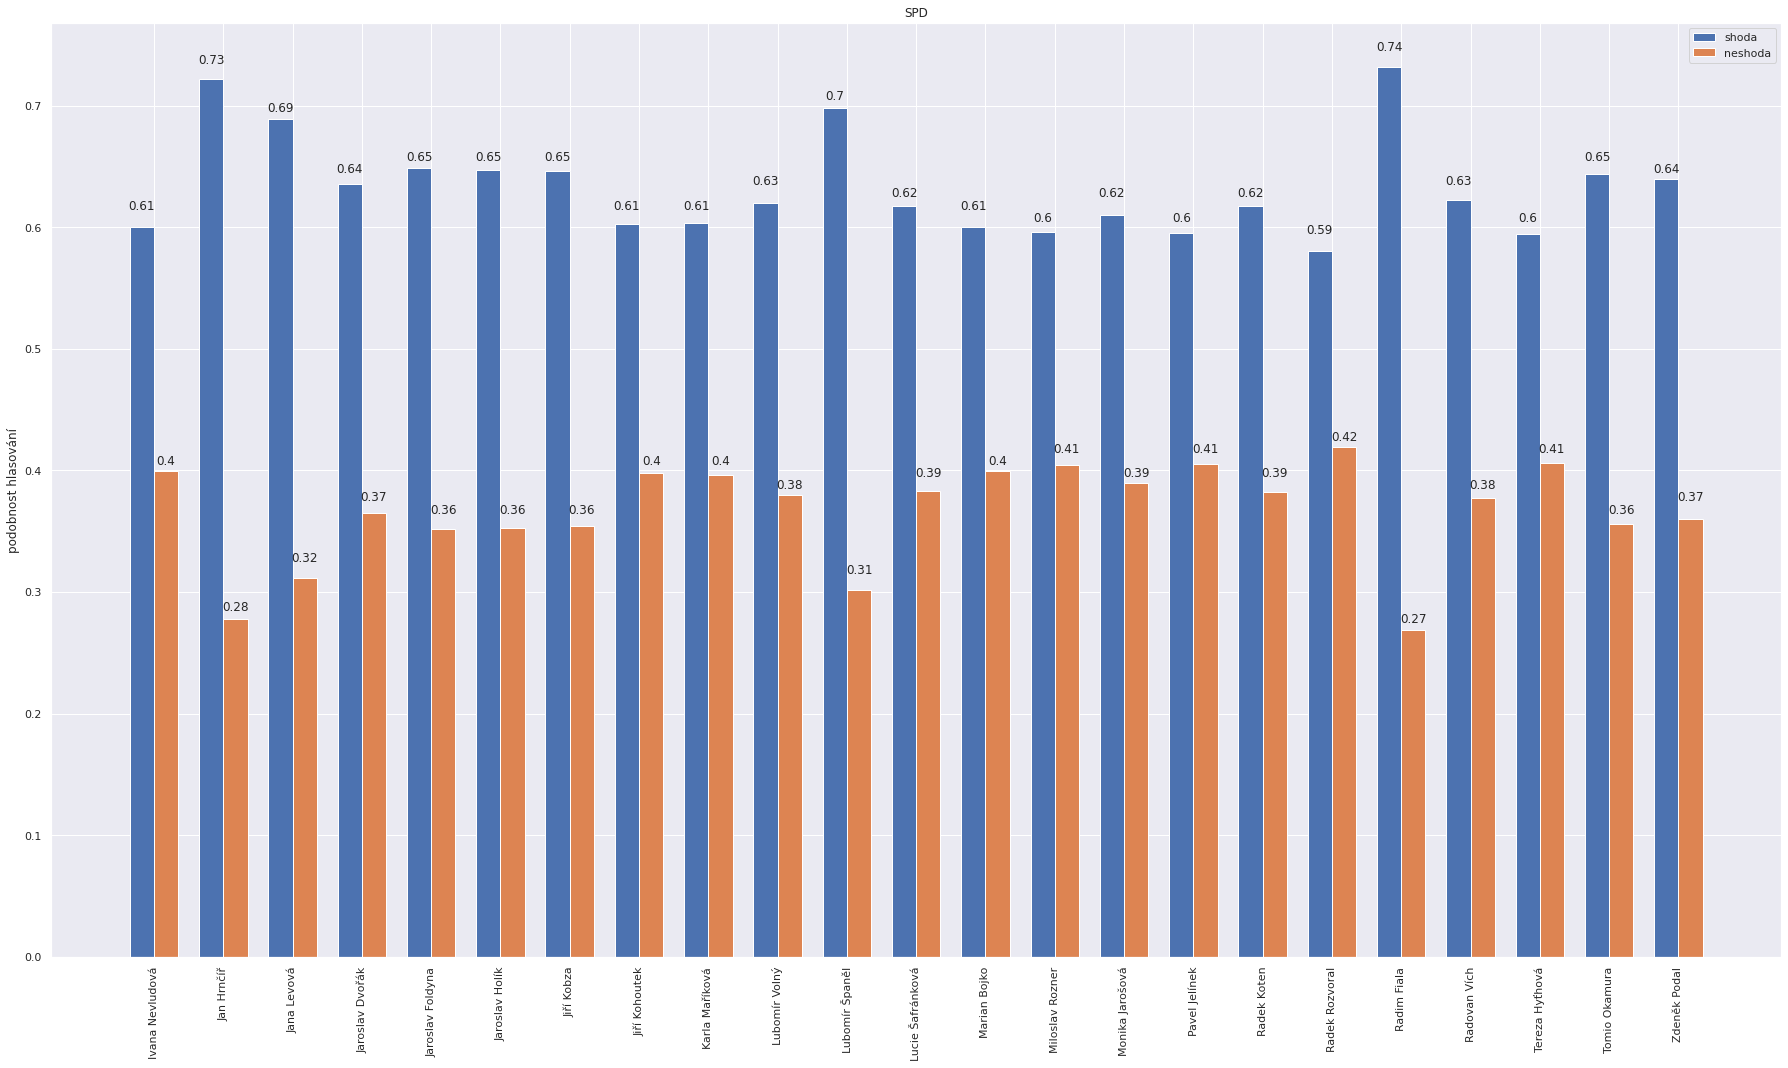

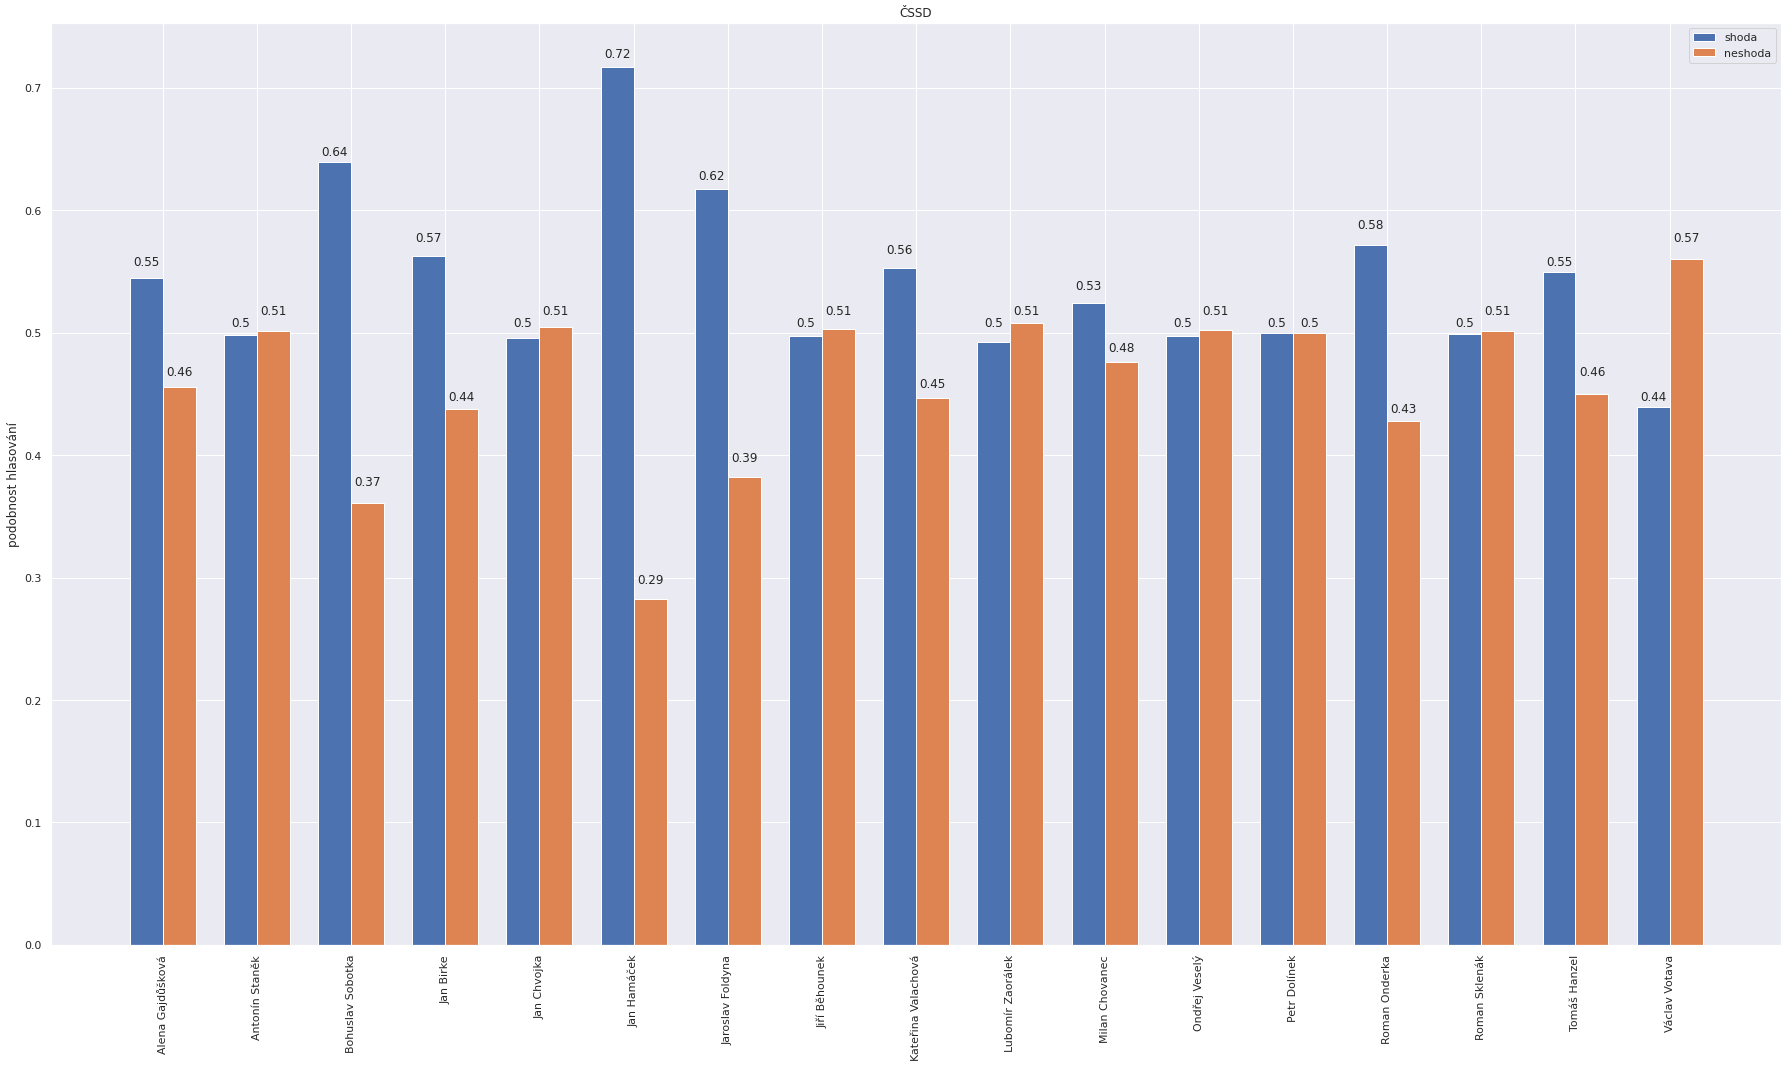

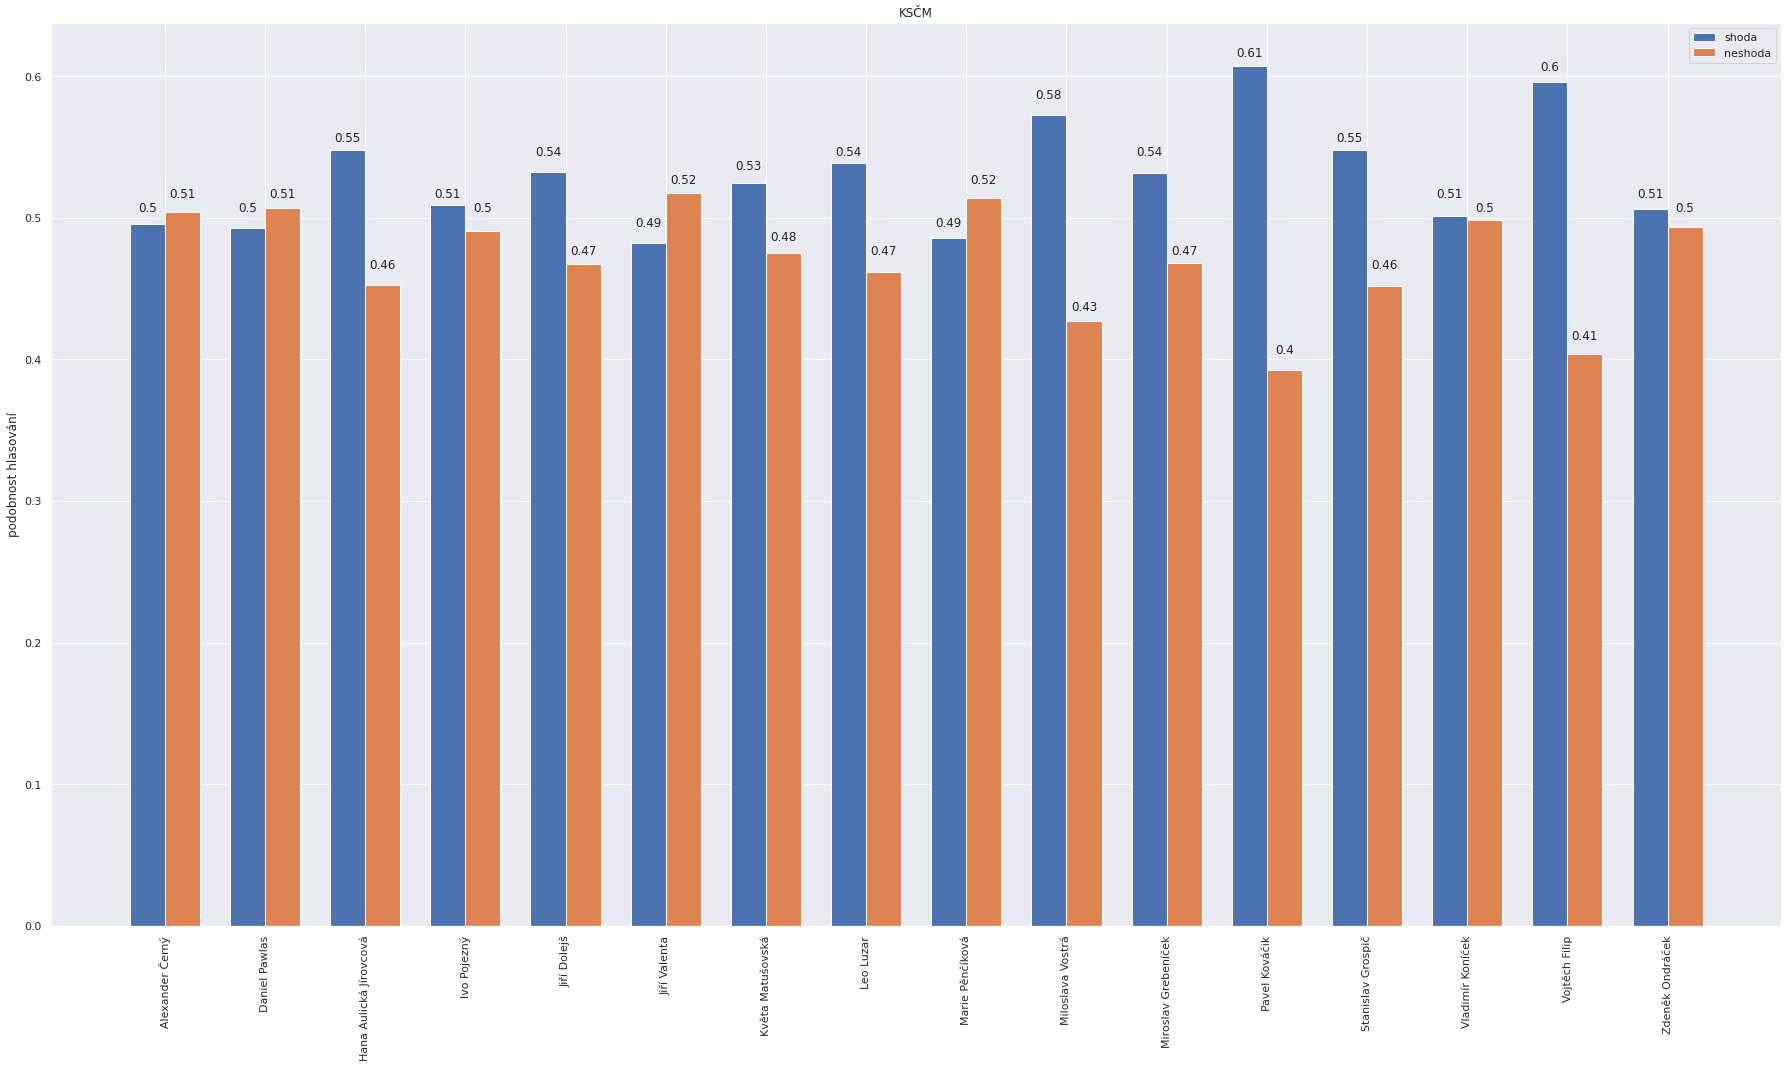

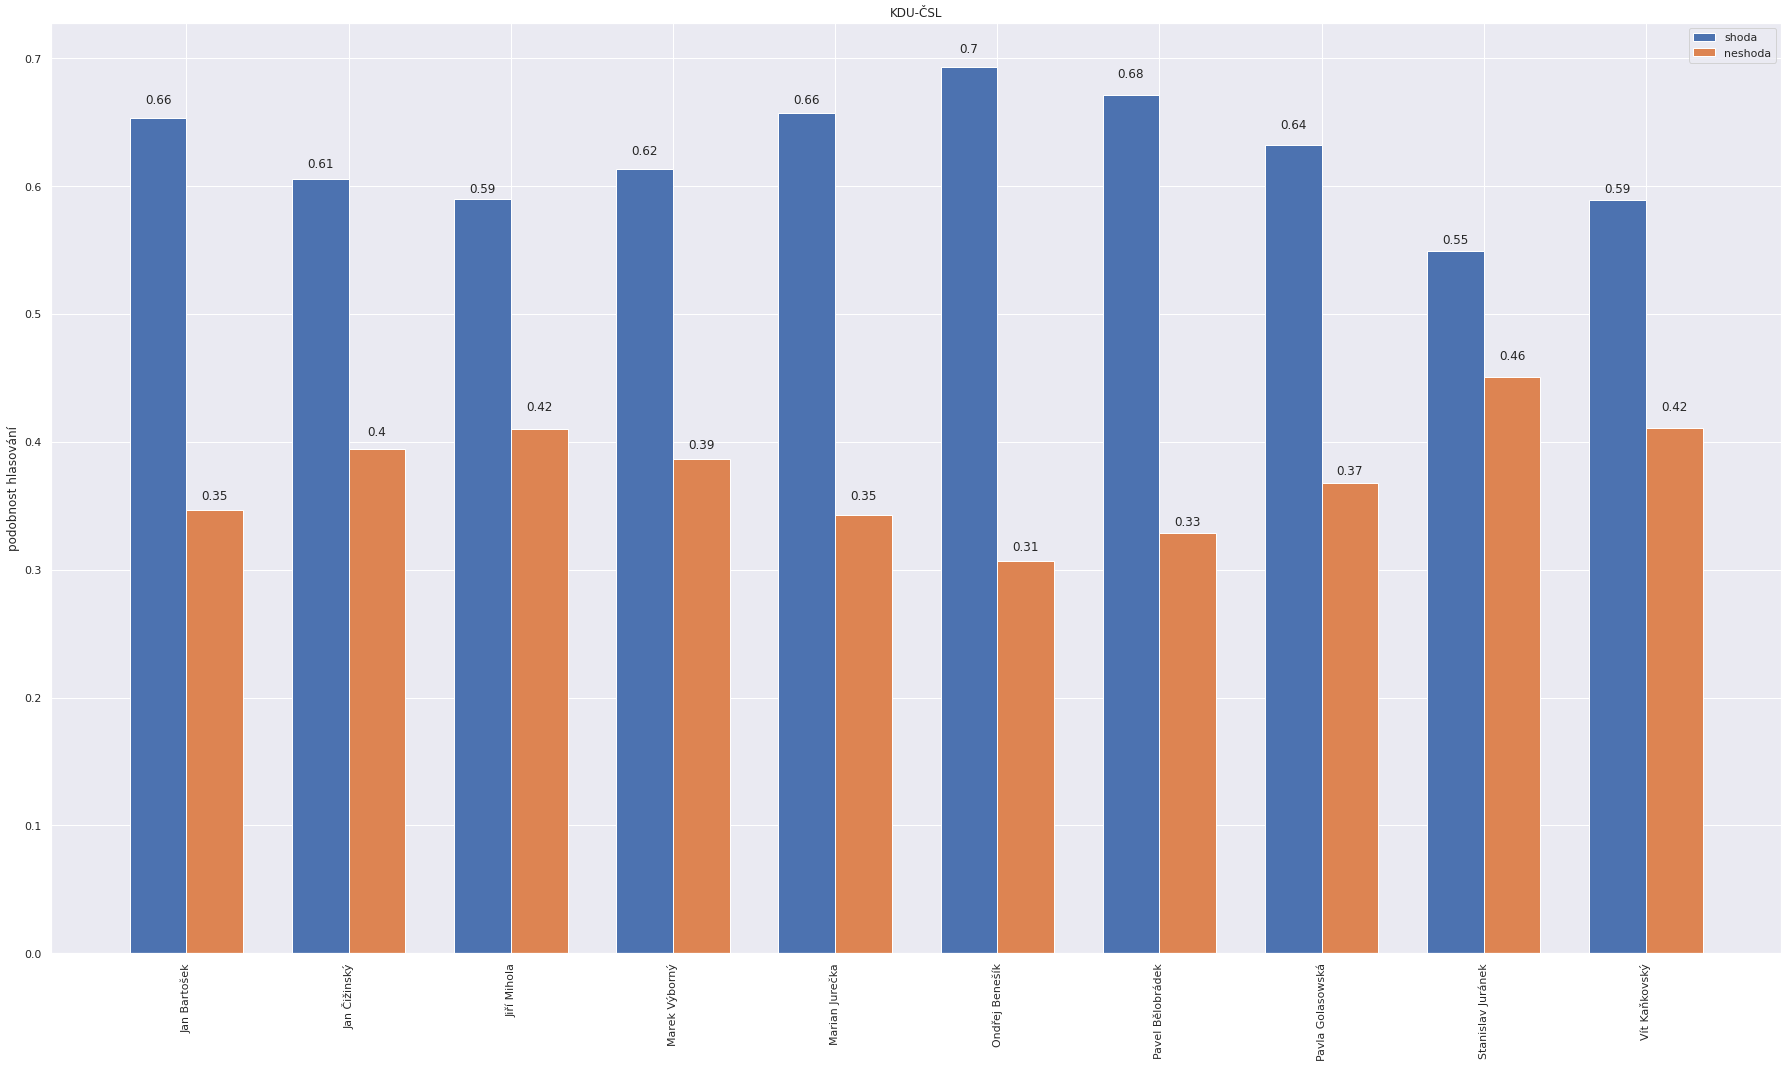

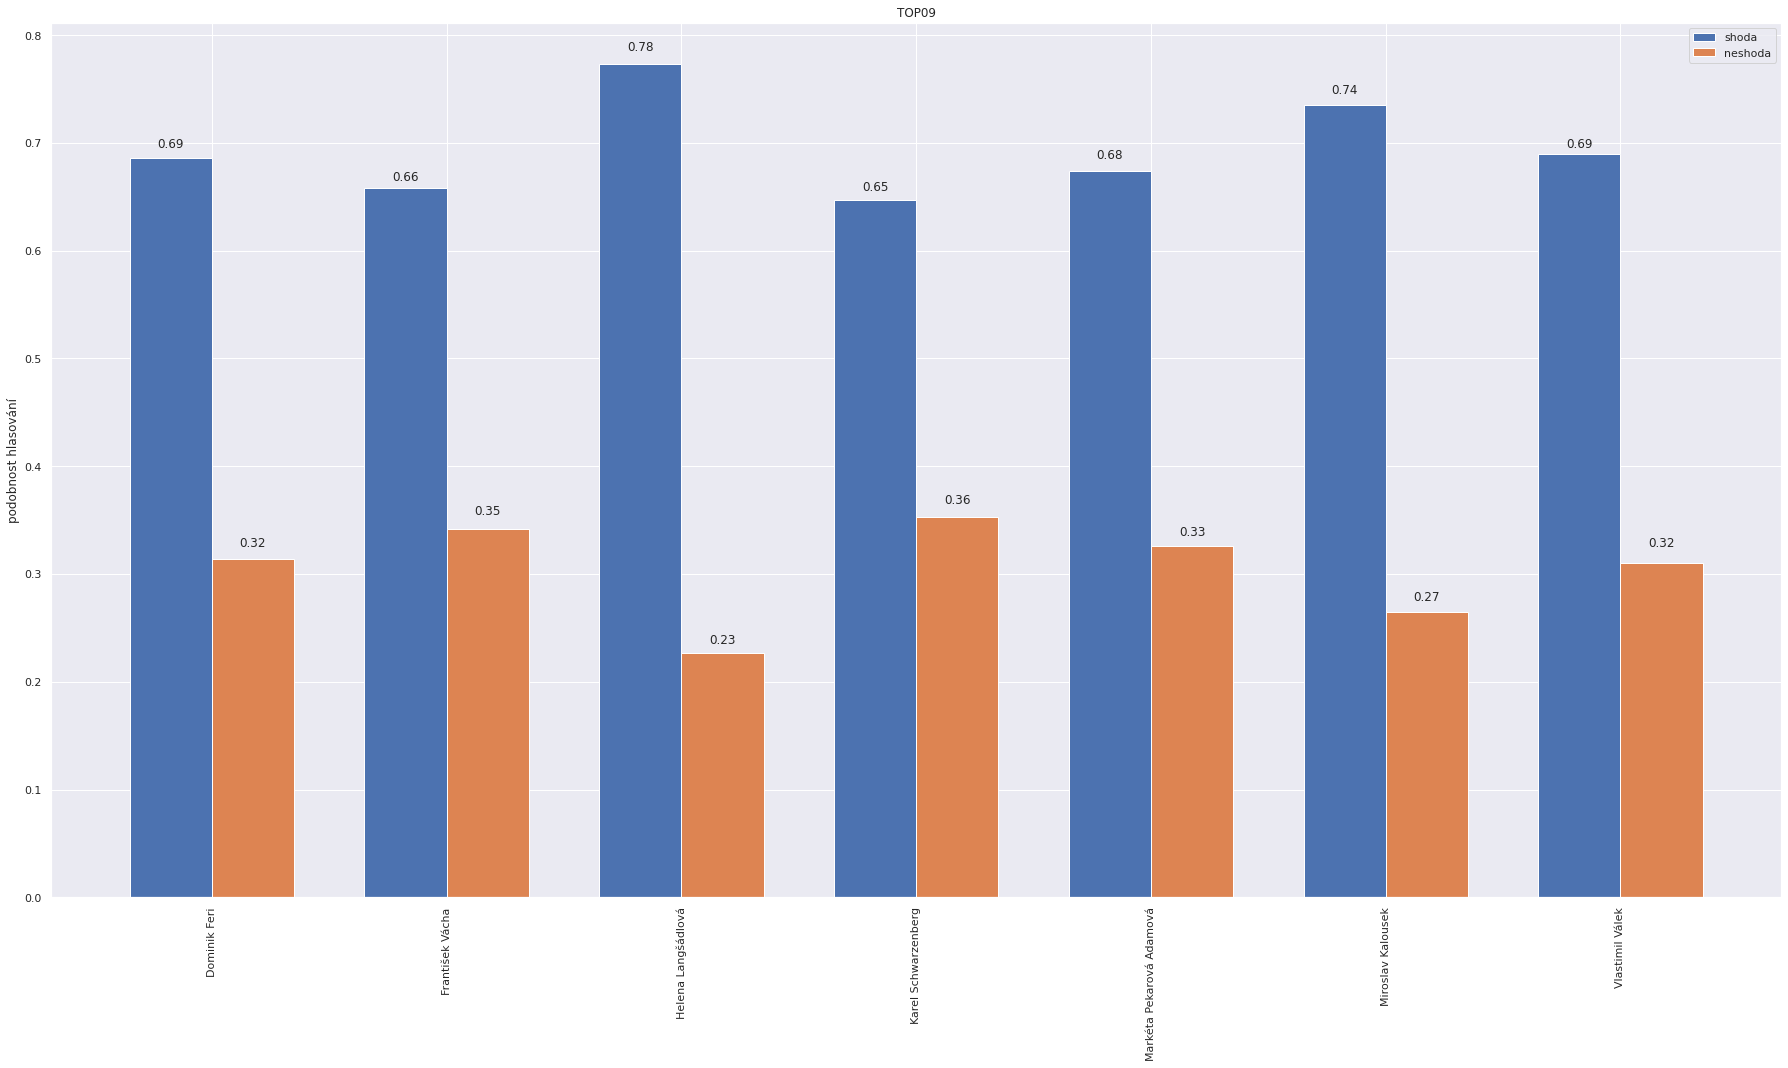

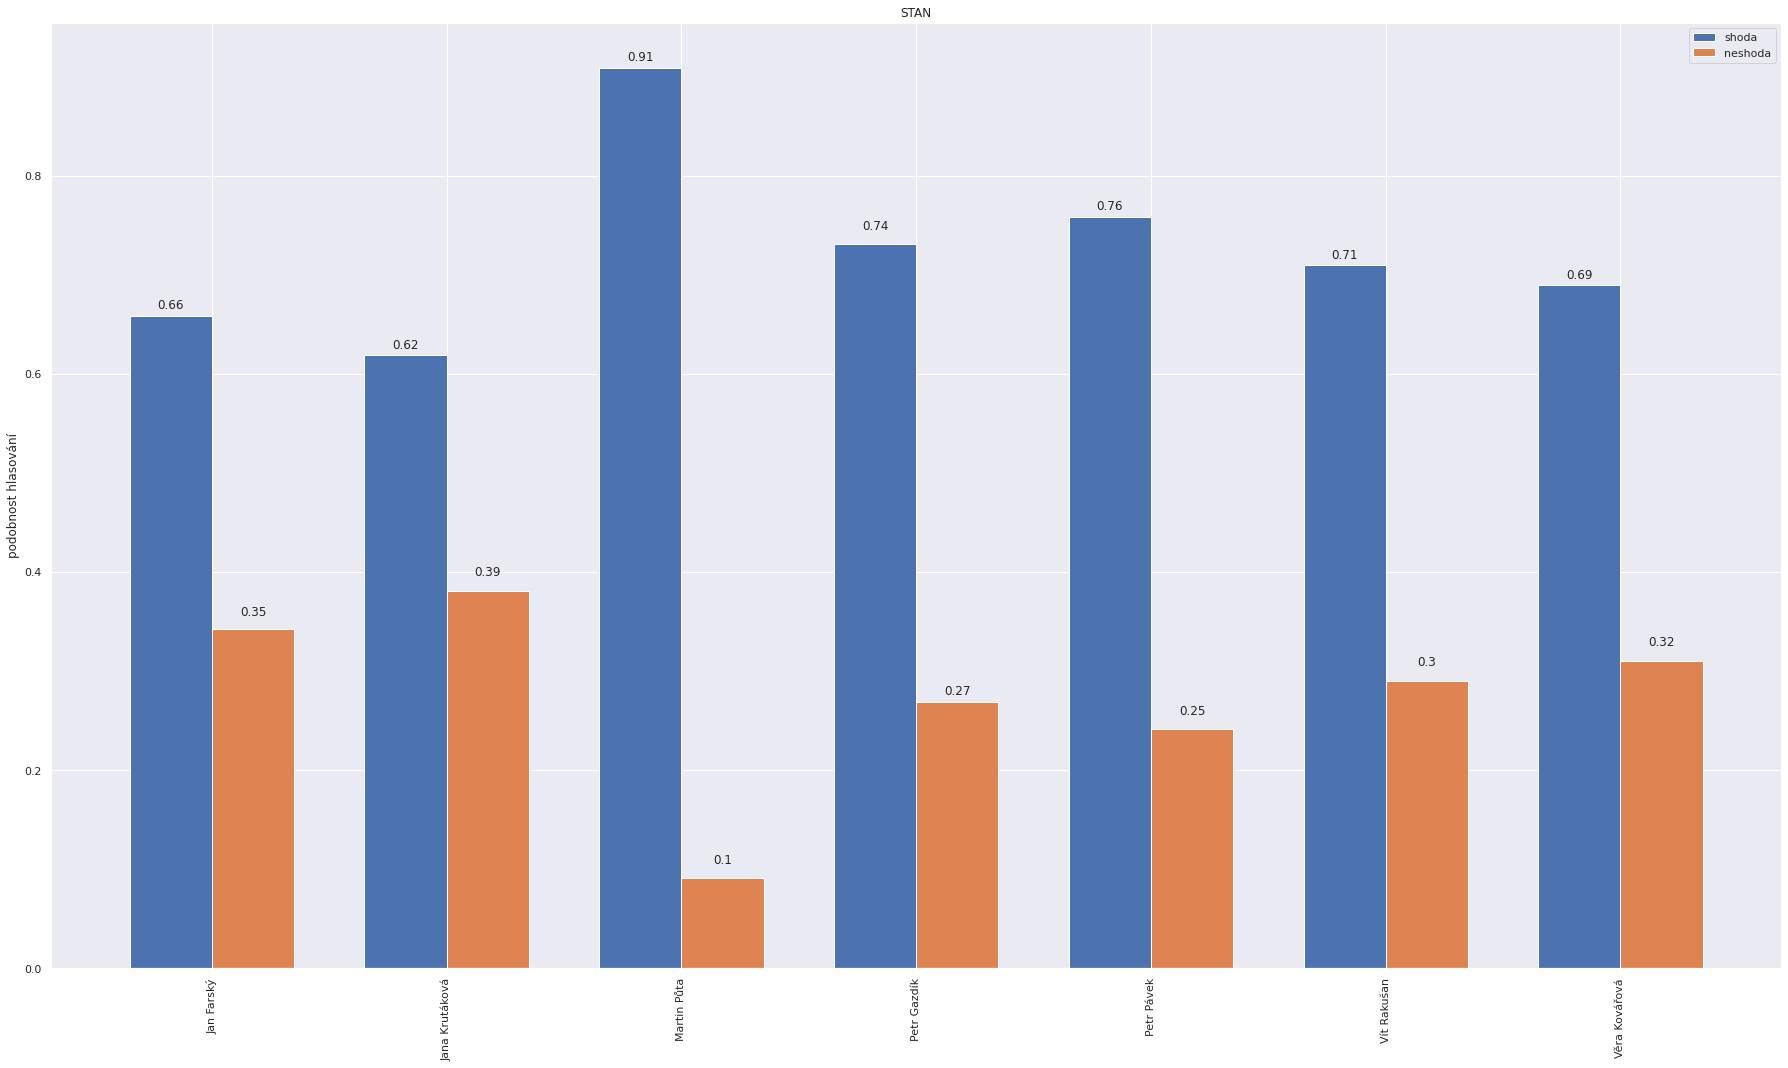

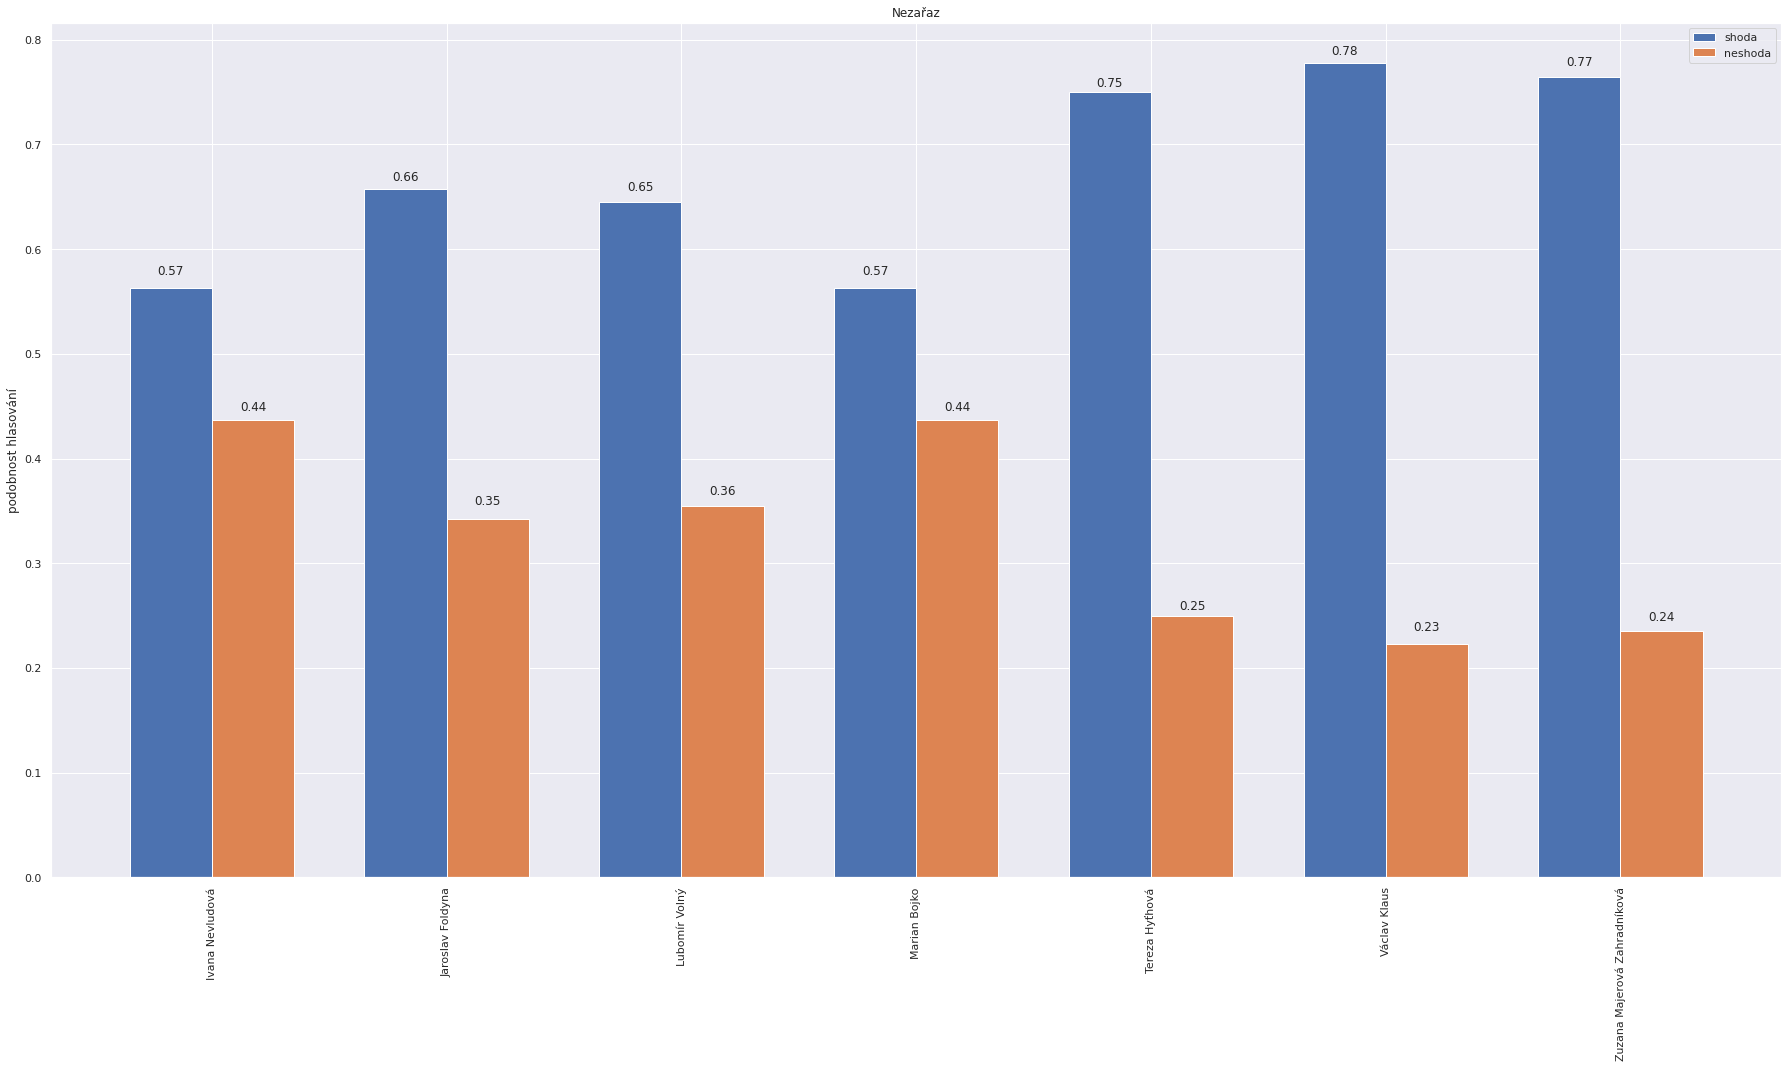

In [30]:
#vytvoreni tabluky
dfsh = df[["party", "vote", "meeting", "point"]]
#vyfiltrovani
dfsh = dfsh[dfsh.vote != "0"]
dfsh = dfsh[dfsh.vote != "M"]

#count total of entries
ttlhl = dfsh.groupby(["party", "meeting", "point"]).size().reset_index().rename(columns={0:'rrecords'})
#spocteni duplicit
dfsh = dfsh.groupby(dfsh.columns.tolist()).size().reset_index().rename(columns={0:'records'})
dfsh = dfsh.sort_values(["party", "meeting", "point"])

#get numbers of meetings
mtnbrs = dfsh[["meeting"]]
mtnbrs.drop_duplicates(subset=["meeting"],keep="last",inplace=True)
mtnbrs = mtnbrs.sort_values(["meeting"])
mtnbrs = mtnbrs.meeting.to_list()

#get parties
parties = df[["party"]]
parties.drop_duplicates(subset=["party"],keep="first",inplace=True)
parties = parties.party.to_list()

#spojeni celkoveho poctu hlasovani
ddf = pd.merge(dfsh, ttlhl)
ddf = ddf.sort_values(["party", "meeting", "point"])
ddf.drop_duplicates(subset=["party", "meeting", "point"],keep="last",inplace=True)
ddf["pvote"] = ddf.vote
ddf = ddf[["party", "pvote", "meeting", "point"]]



###Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).
dfjd = df[["firstname", "lastname", "party", "meeting", "point", "vote"]]
dfjd = dfjd[dfjd.vote != "0"]
dfjd = dfjd[dfjd.vote != "M"]

#unite party vote with member vote
dfjd = pd.merge(dfjd, ddf)
#zjisteni zdali hlasoval stejne jako vetsina, 1 ano, 0 ne
dfjd["united"] = np.select([(dfjd.vote == dfjd.pvote), (True)], [1, 0])

#vyfiltrovani sloupcu
dfjd = dfjd[["firstname", "lastname", "party", "united"]]
dfjd = dfjd.groupby(dfjd.columns.tolist()).size().reset_index().rename(columns={0:'records'})
dfjd["fullname"] = dfjd.firstname+" "+dfjd.lastname


#jmena clenu pol. stran
parties_members={}
all_members = df[["firstname", "lastname", "party"]]
all_members = all_members.sort_values(["firstname", "lastname", "party"])
all_members.drop_duplicates(subset=["firstname", "lastname", "party"],keep="first",inplace=True)
all_members["fullname"] = all_members.firstname + " " + all_members.lastname
for party in parties:
    members = all_members[all_members.party == party]
    parties_members[party] = members.fullname.to_list()

#get parties
parties = df[["party"]]
parties.drop_duplicates(subset=["party"],keep="first",inplace=True)
parties = parties.party.to_list()


#graph
#kod pro popis baru vypujcen z https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        real_height = rect.get_height()
        height = (math.ceil(real_height*100))/100
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#create graphs
names_graph = {}
for i in range(len(parties)):
    party = parties[i]
    
    names_graph[party] = plt.figure(i)
    
    N = len(parties_members[party])
    
    members = parties_members[party]
    
    labels = members

    wasntCons= list()
    wasCons   = list()

    for member in members:
        memberRec = dfjd[dfjd.fullname == member]
        memberRec = memberRec[memberRec.party == party]
        
        consRec    = memberRec[memberRec.united==1]
        consRec    = consRec.records.to_list()
        notconsRec = memberRec[memberRec.united==0]
        notconsRec = notconsRec.records.to_list()

        consNum    = 0 if len(consRec)    == 0 else consRec[0]
        notconsNum = 0 if len(notconsRec) == 0 else notconsRec[0]
        
        suma = consNum + notconsNum
        suma = suma if suma != 0 else 1
        
        consNum = consNum/suma
        notconsNum = notconsNum/suma
        
        wasCons.append(consNum)
        wasntCons.append(notconsNum)
        
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(25,15))
    rects1 = ax.bar(x-width/2, wasCons, width, label='shoda')
    rects2 = ax.bar(x+width/2, wasntCons, width, label='neshoda')
    
    ax.set_ylabel('podobnost hlasování')
    ax.set_title(party)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.xticks(rotation=90)
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    
plt.show()


* **Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.**
* tato data jsem získal tak, že jsem si v tabulce nechal pro každou stranu z každé schůze každého bodu jen to hlasování, na kterém se shodla většina
* tyto data jsem pak porovnam napříč politickými stranami
* každou stranu jsem porovnal s ostatními kolikrát hlasovali stejně a kolikrát rozdílně, to je pak zobrazeno v grafu pro každou stranu

<Figure size 432x288 with 0 Axes>

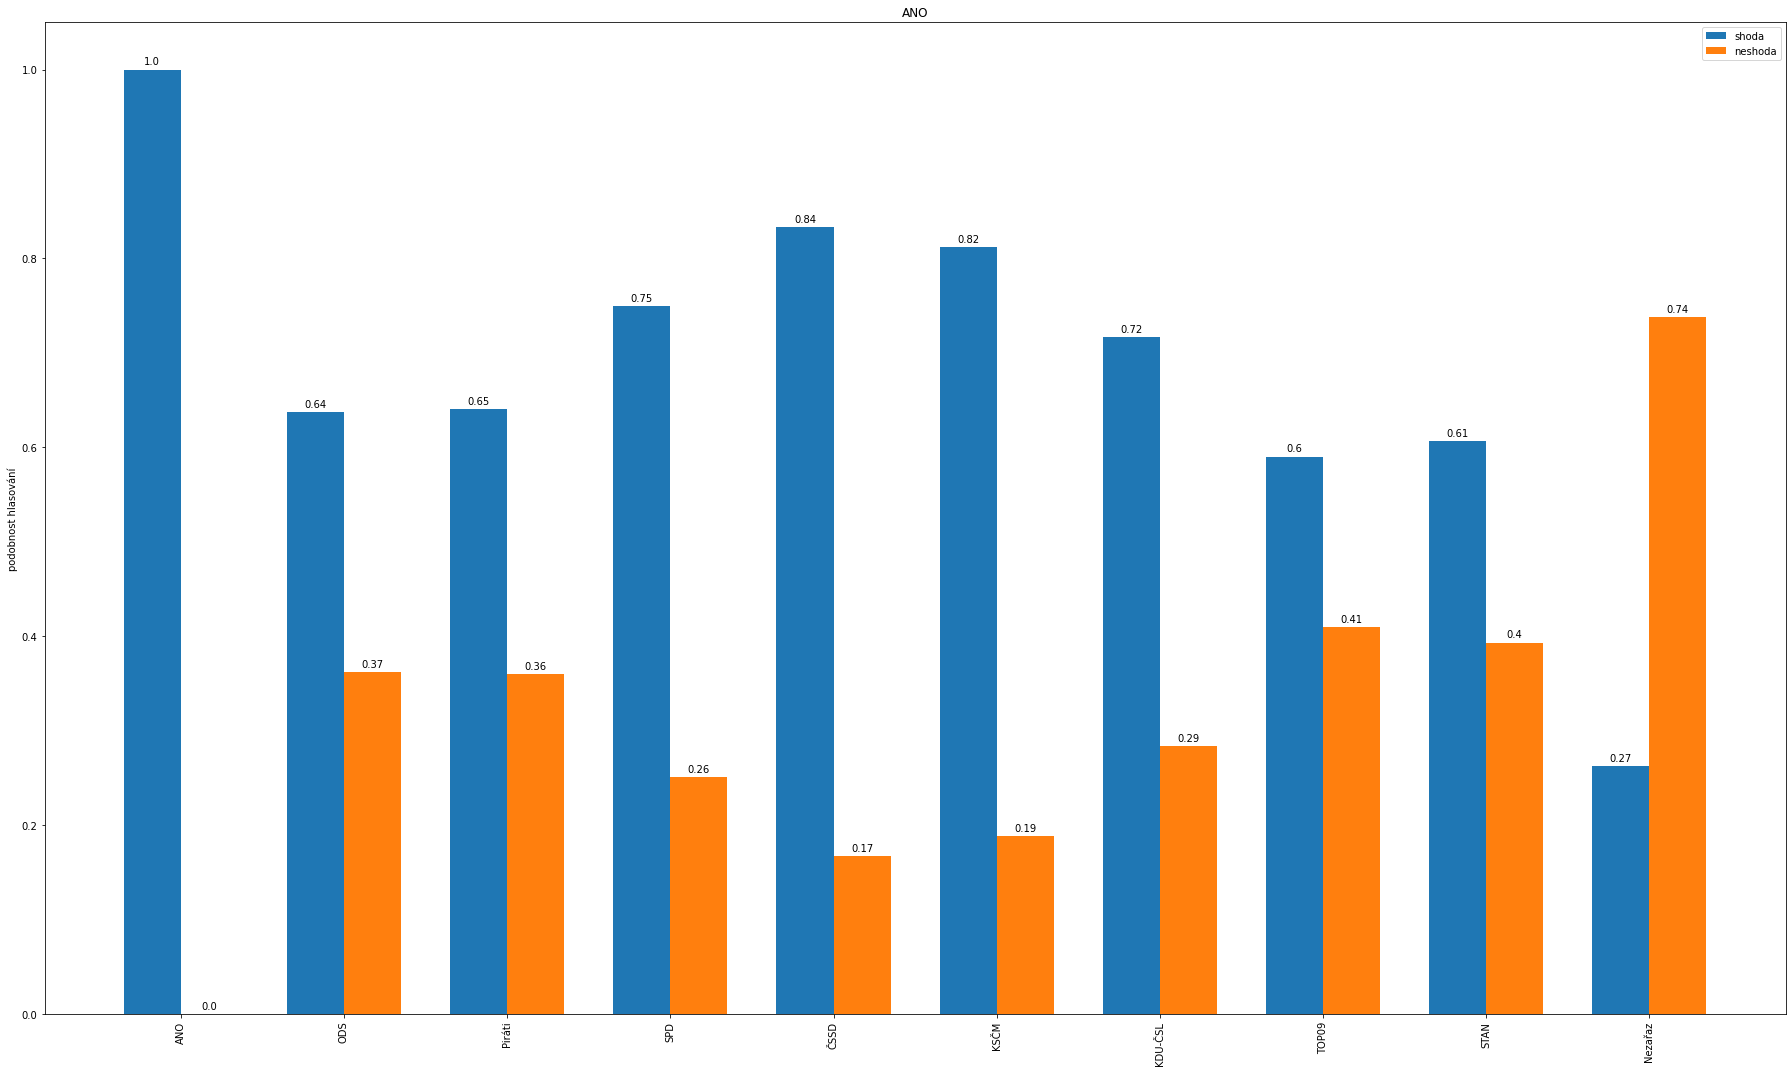

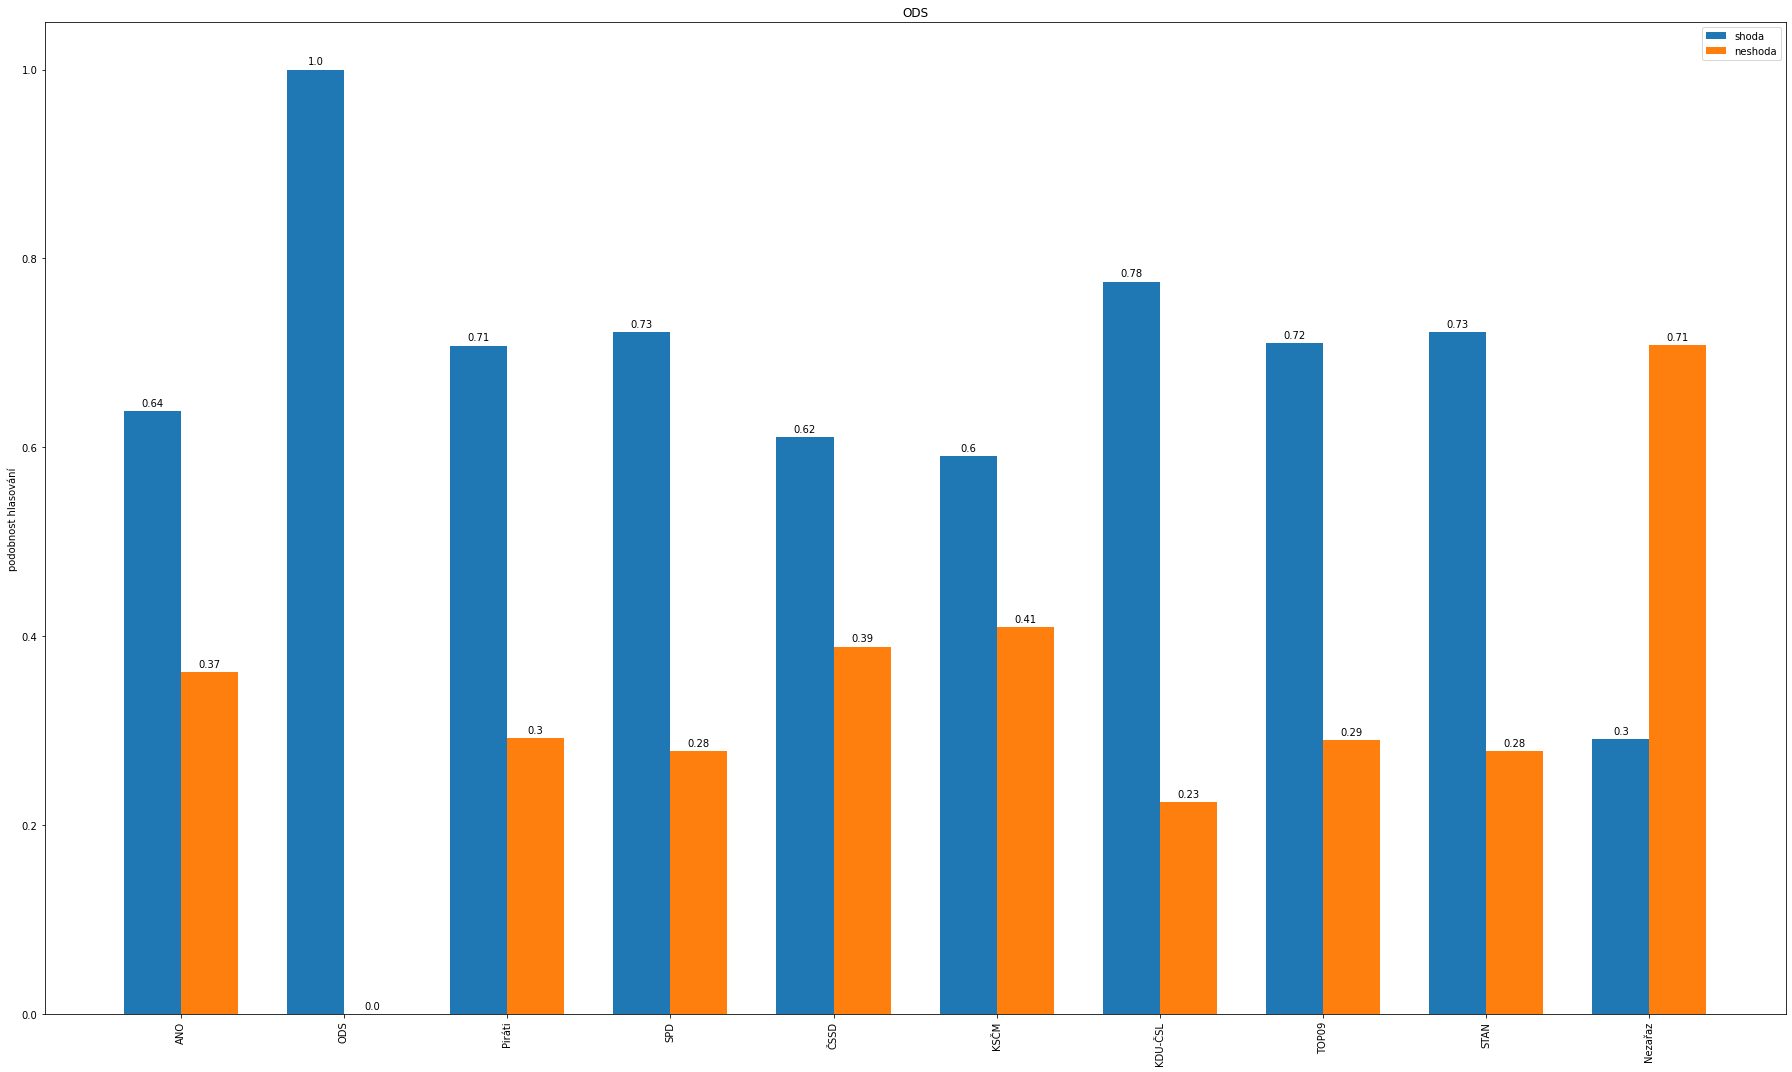

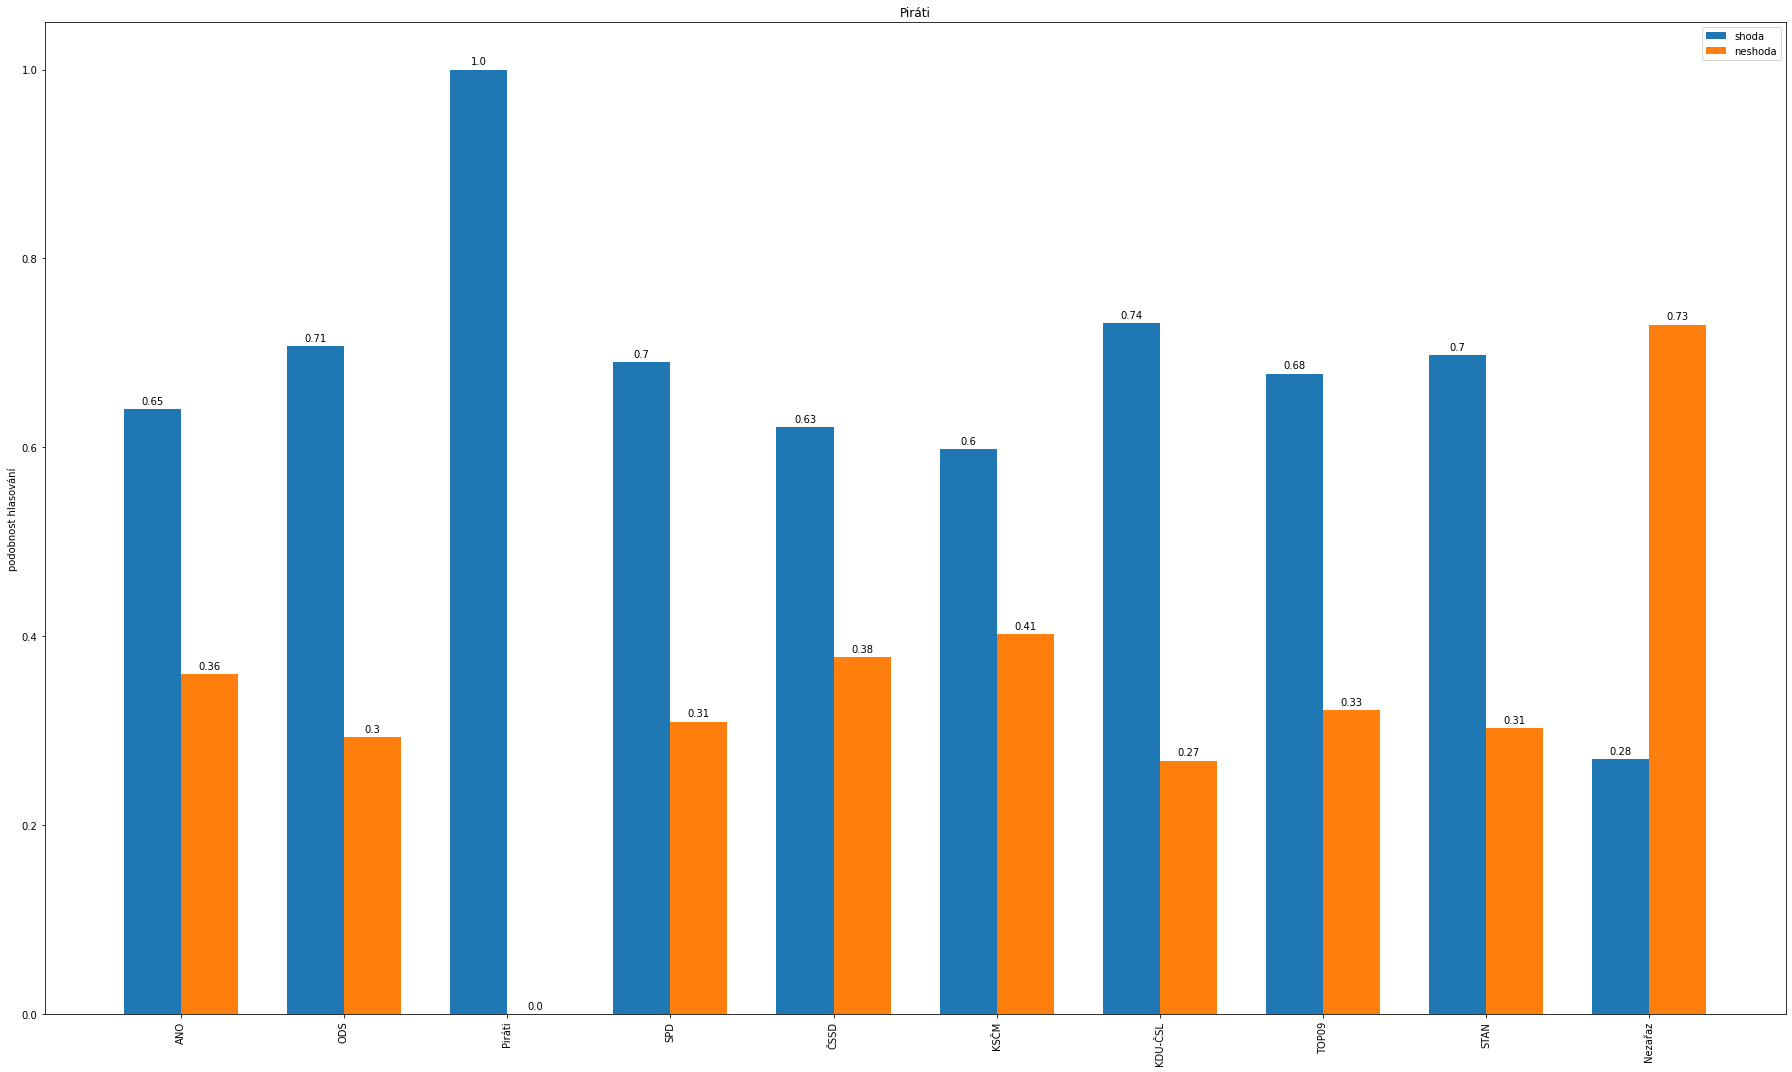

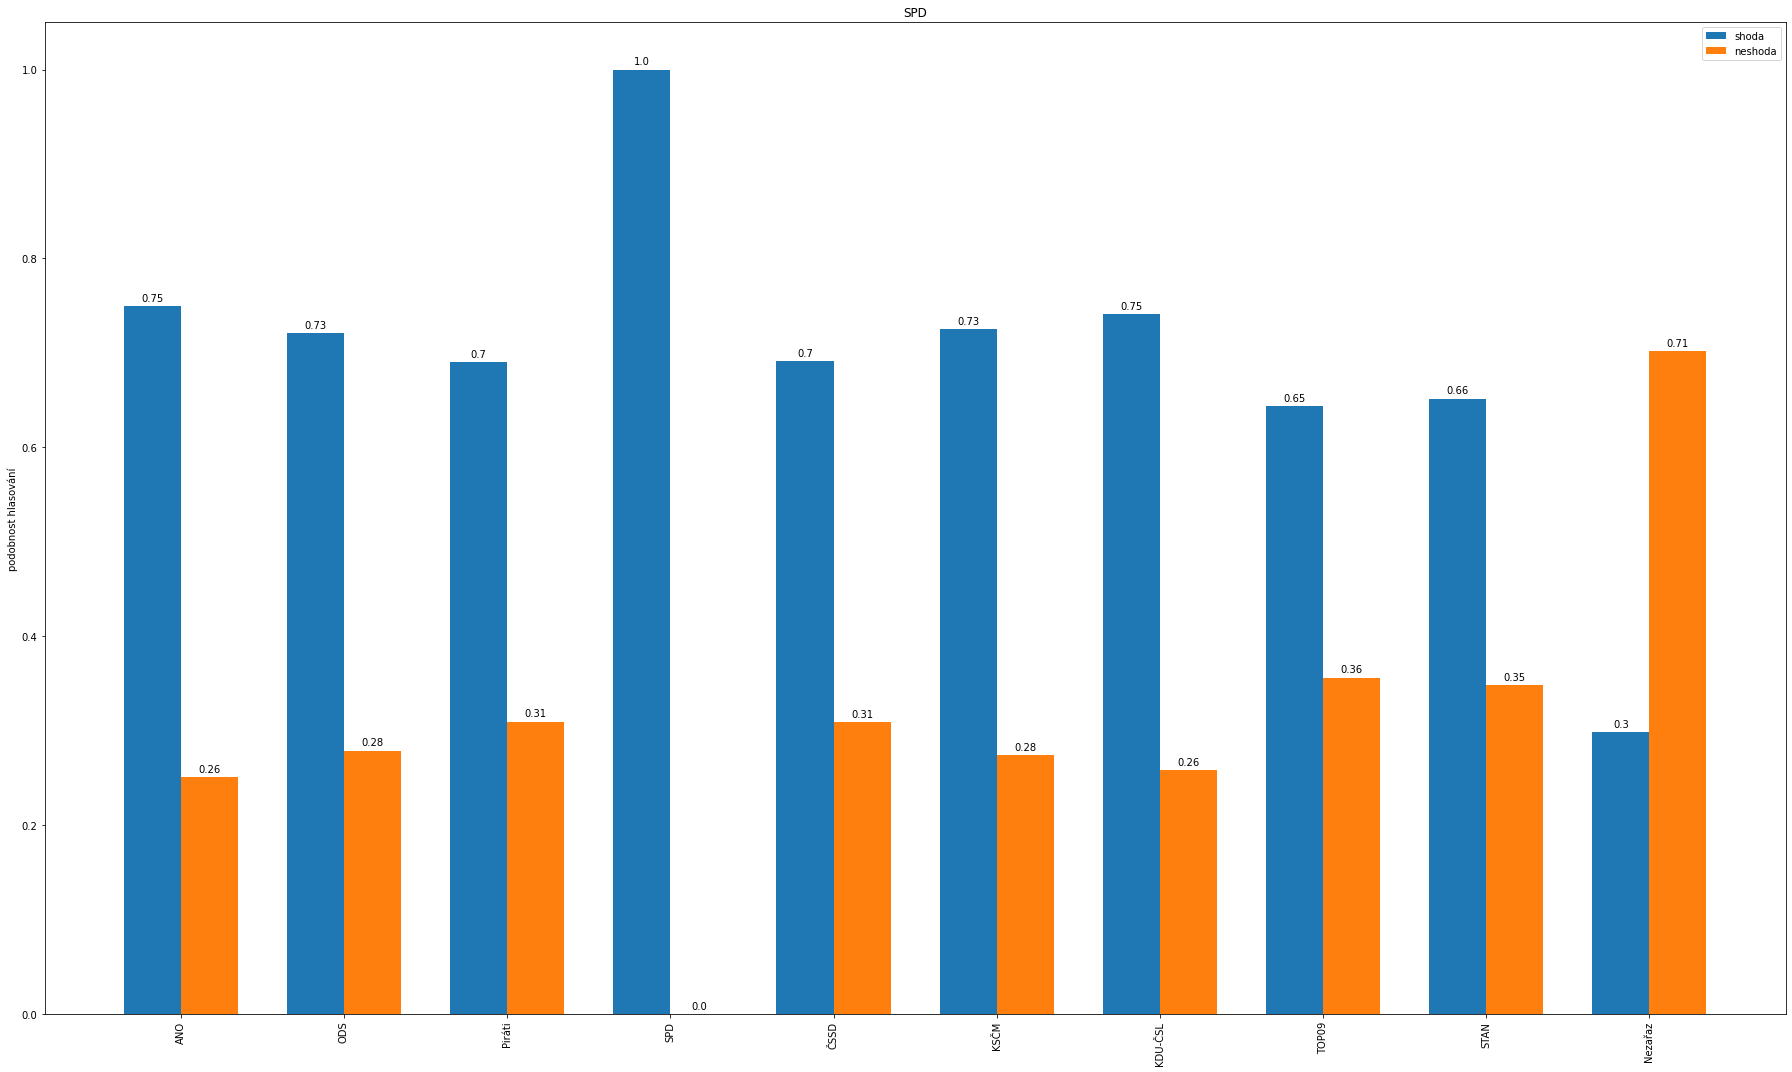

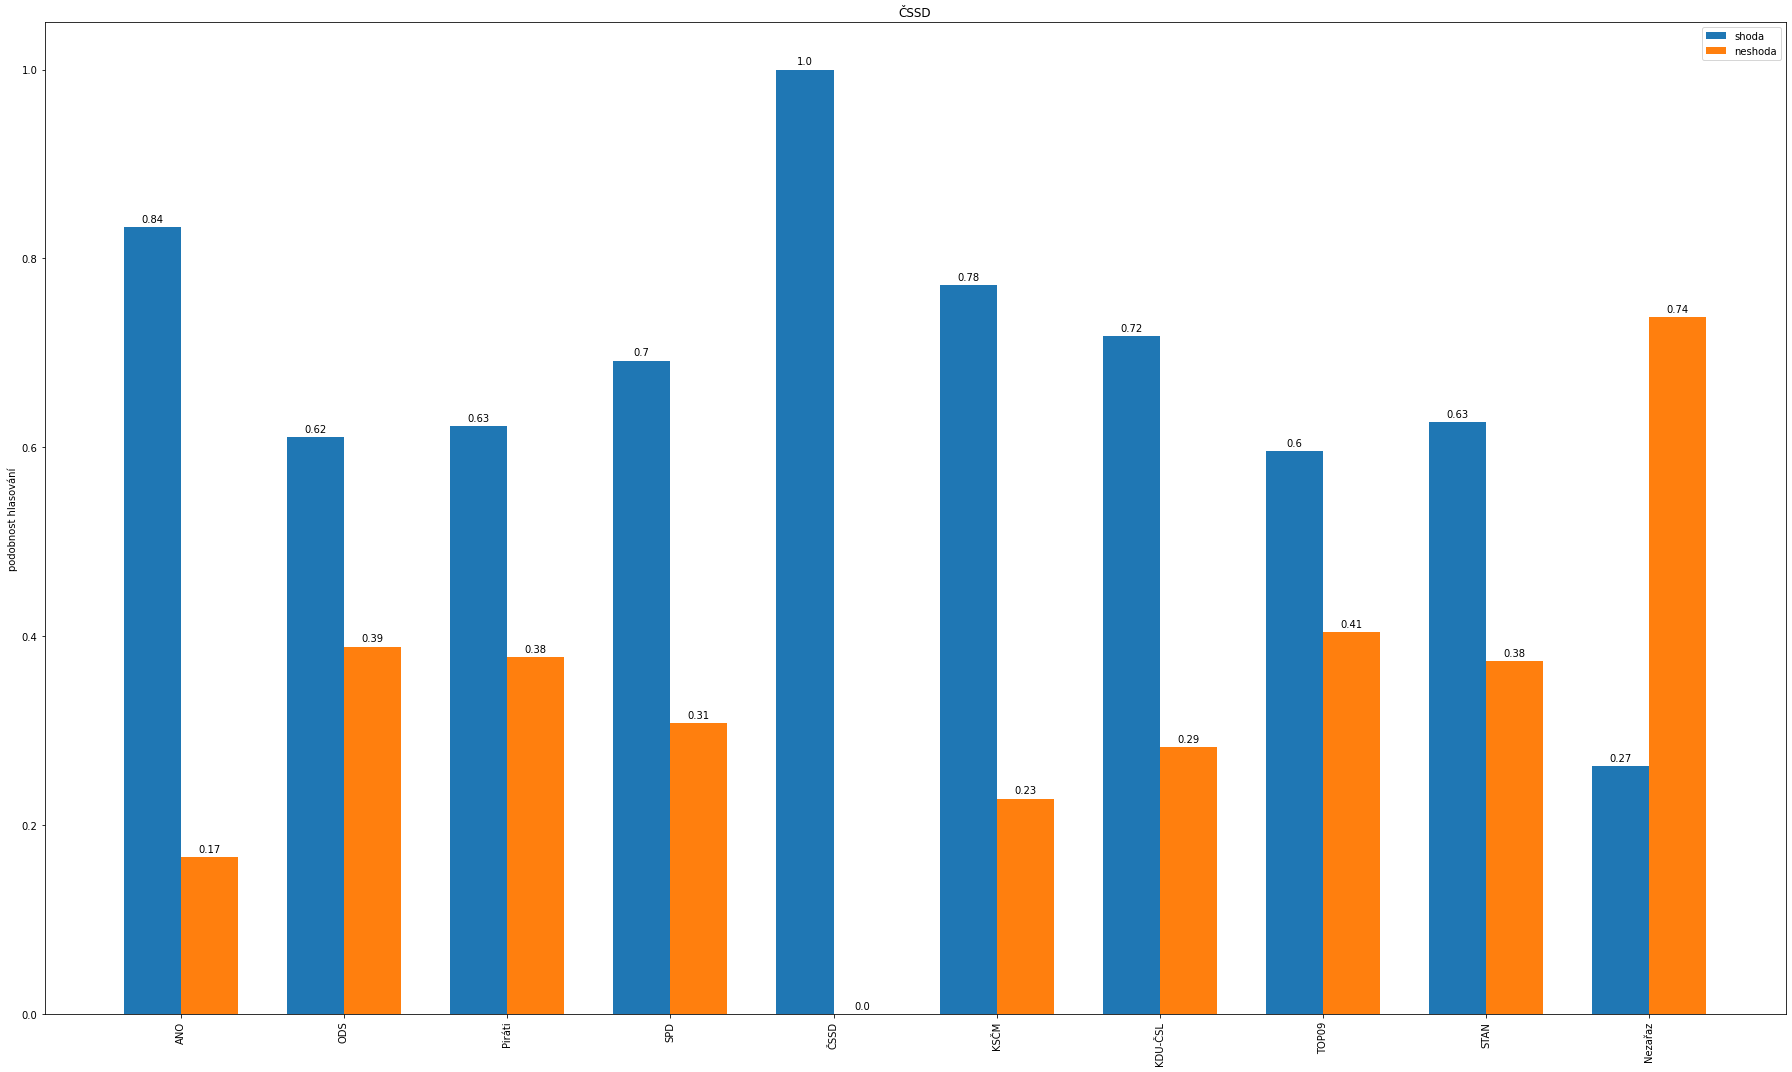

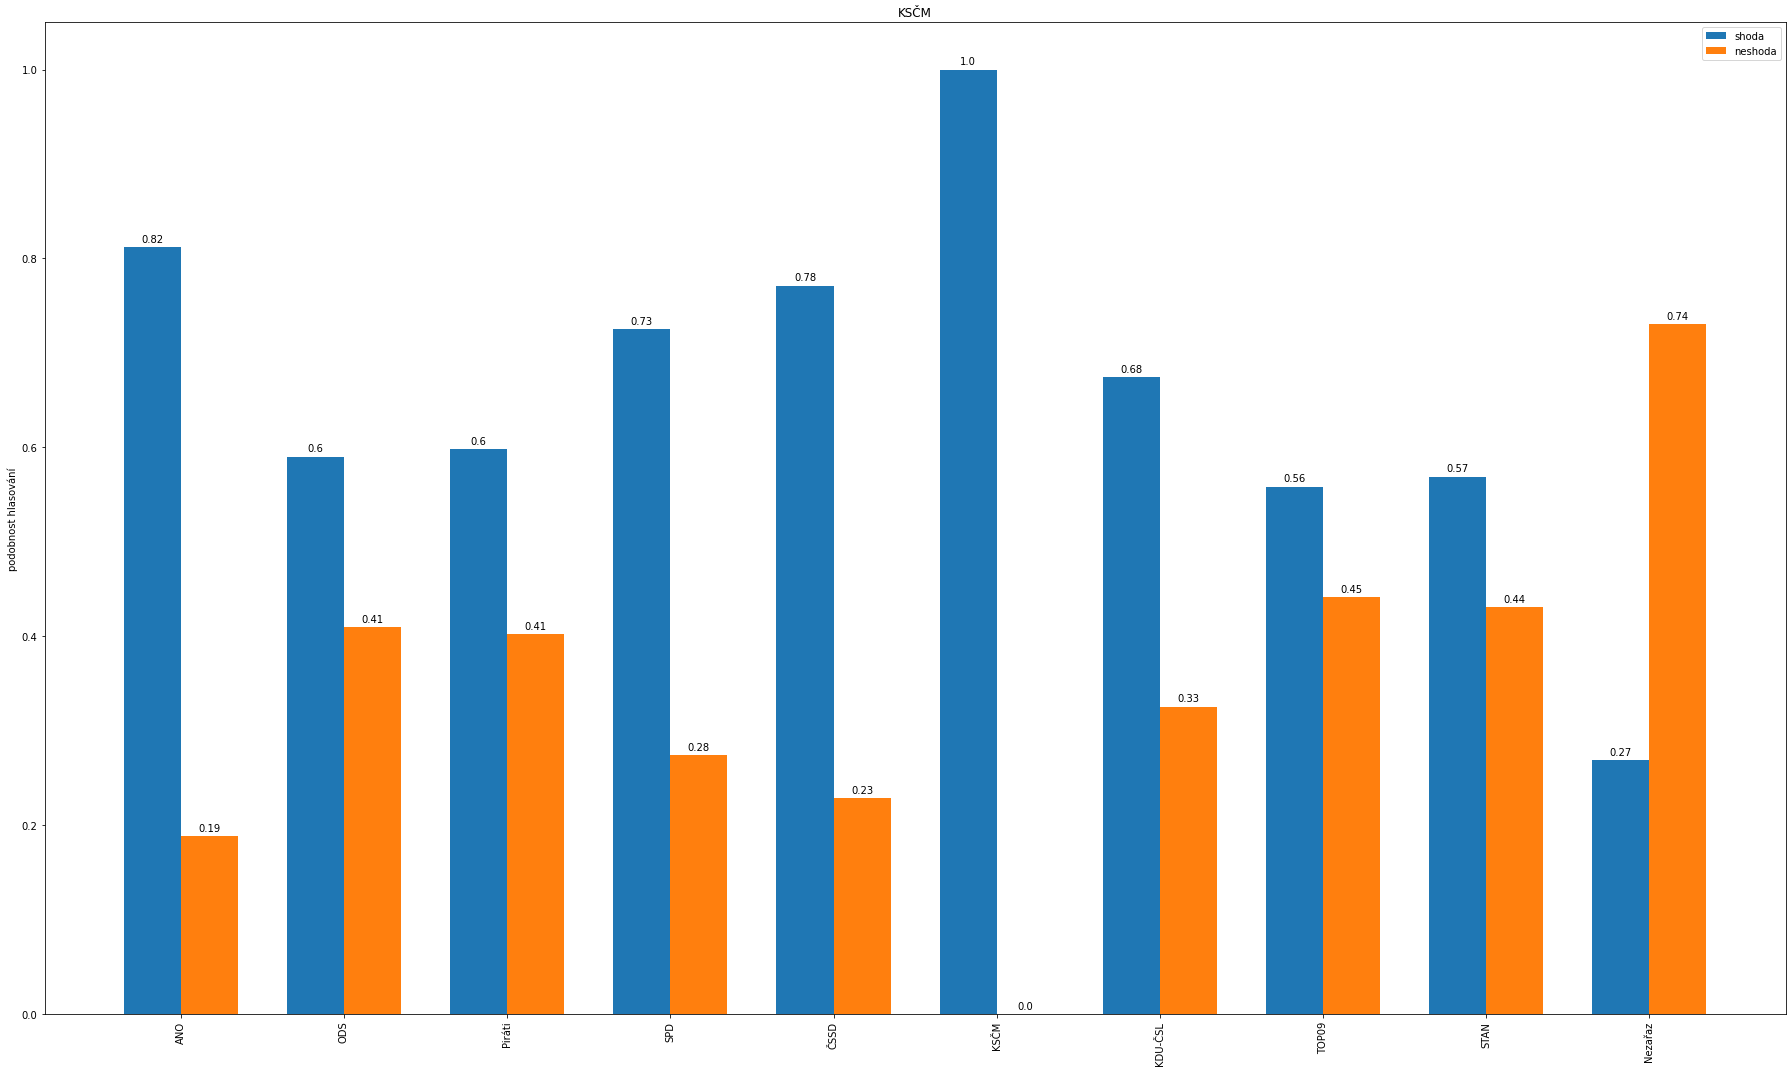

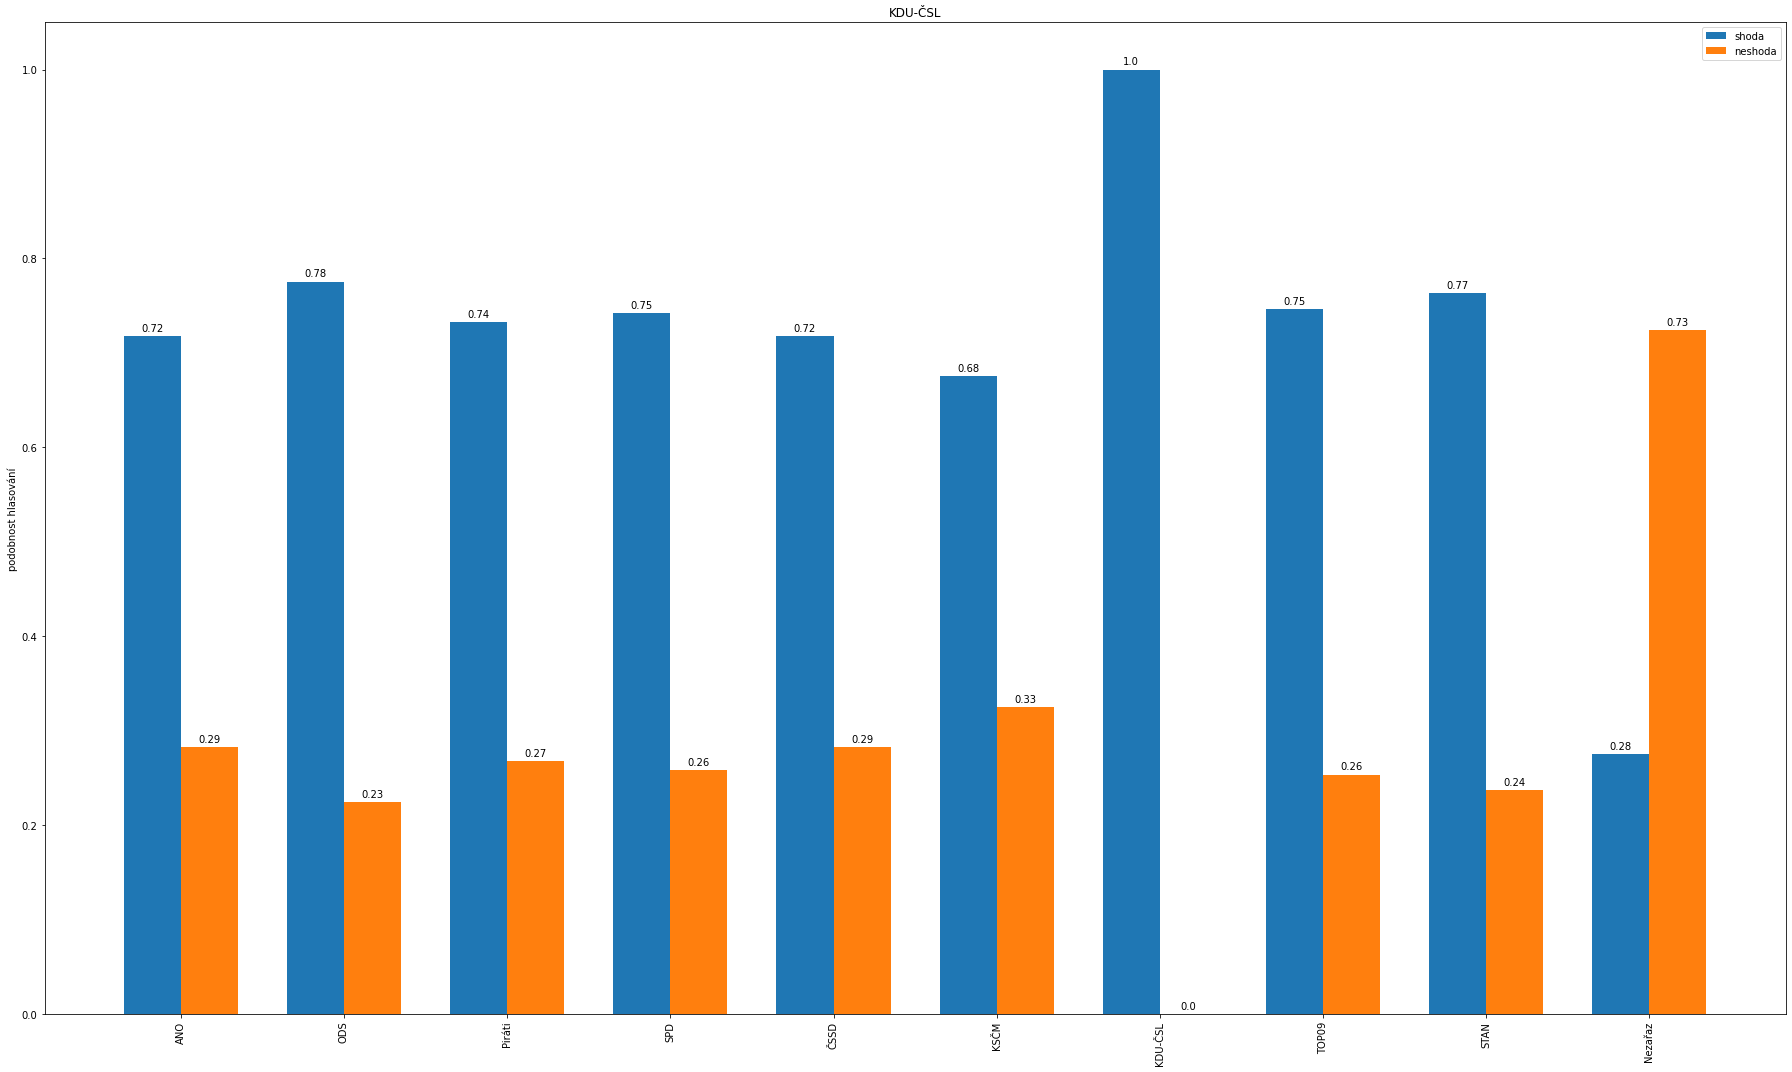

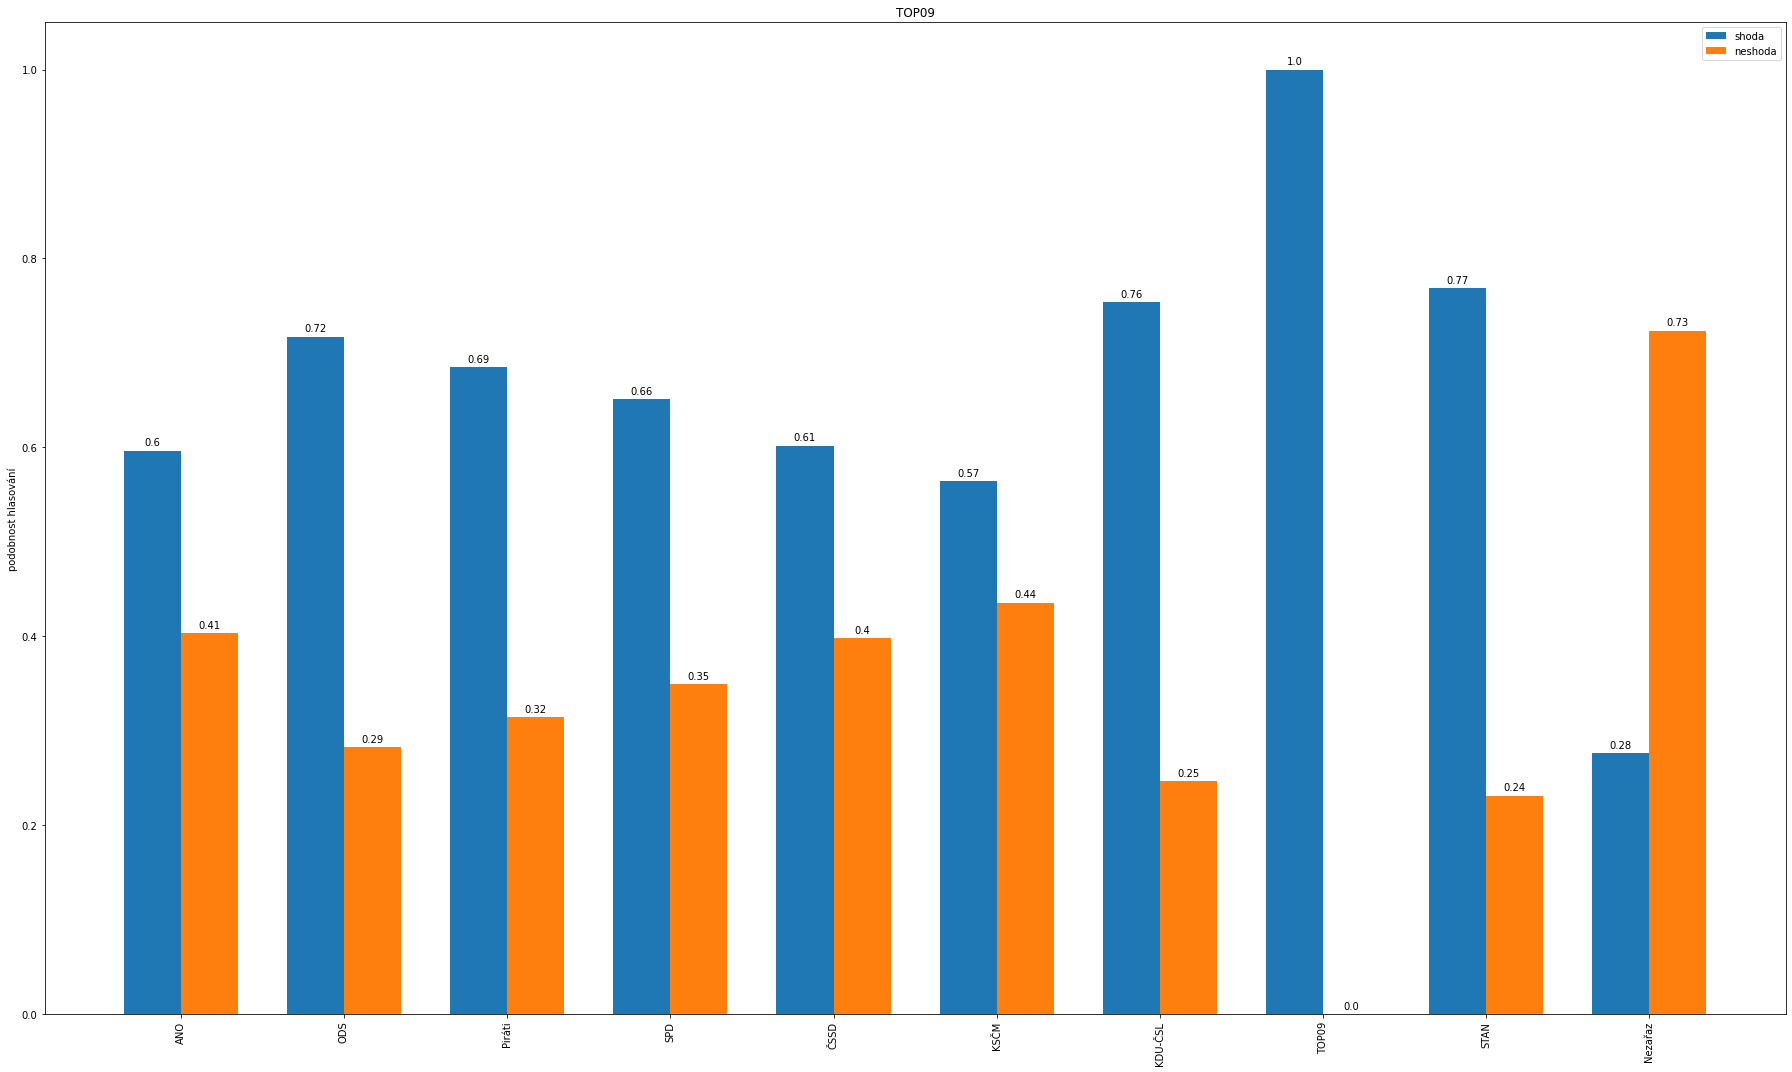

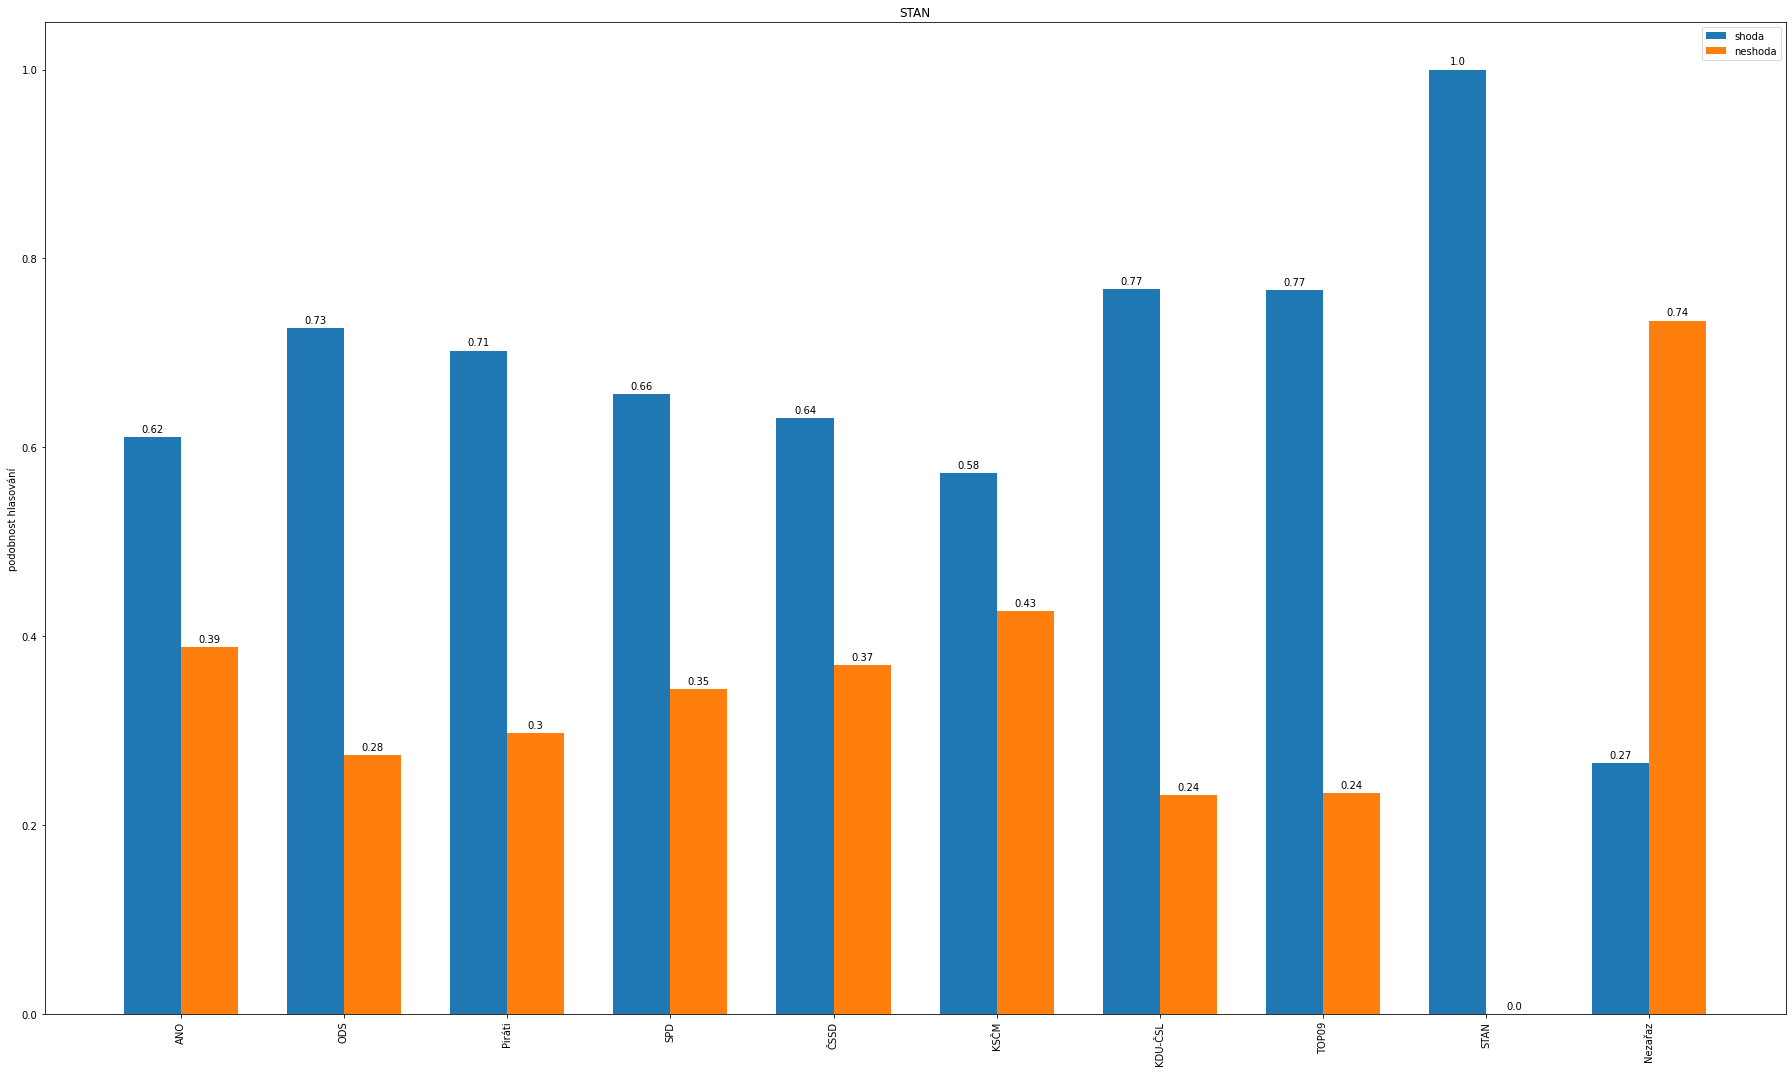

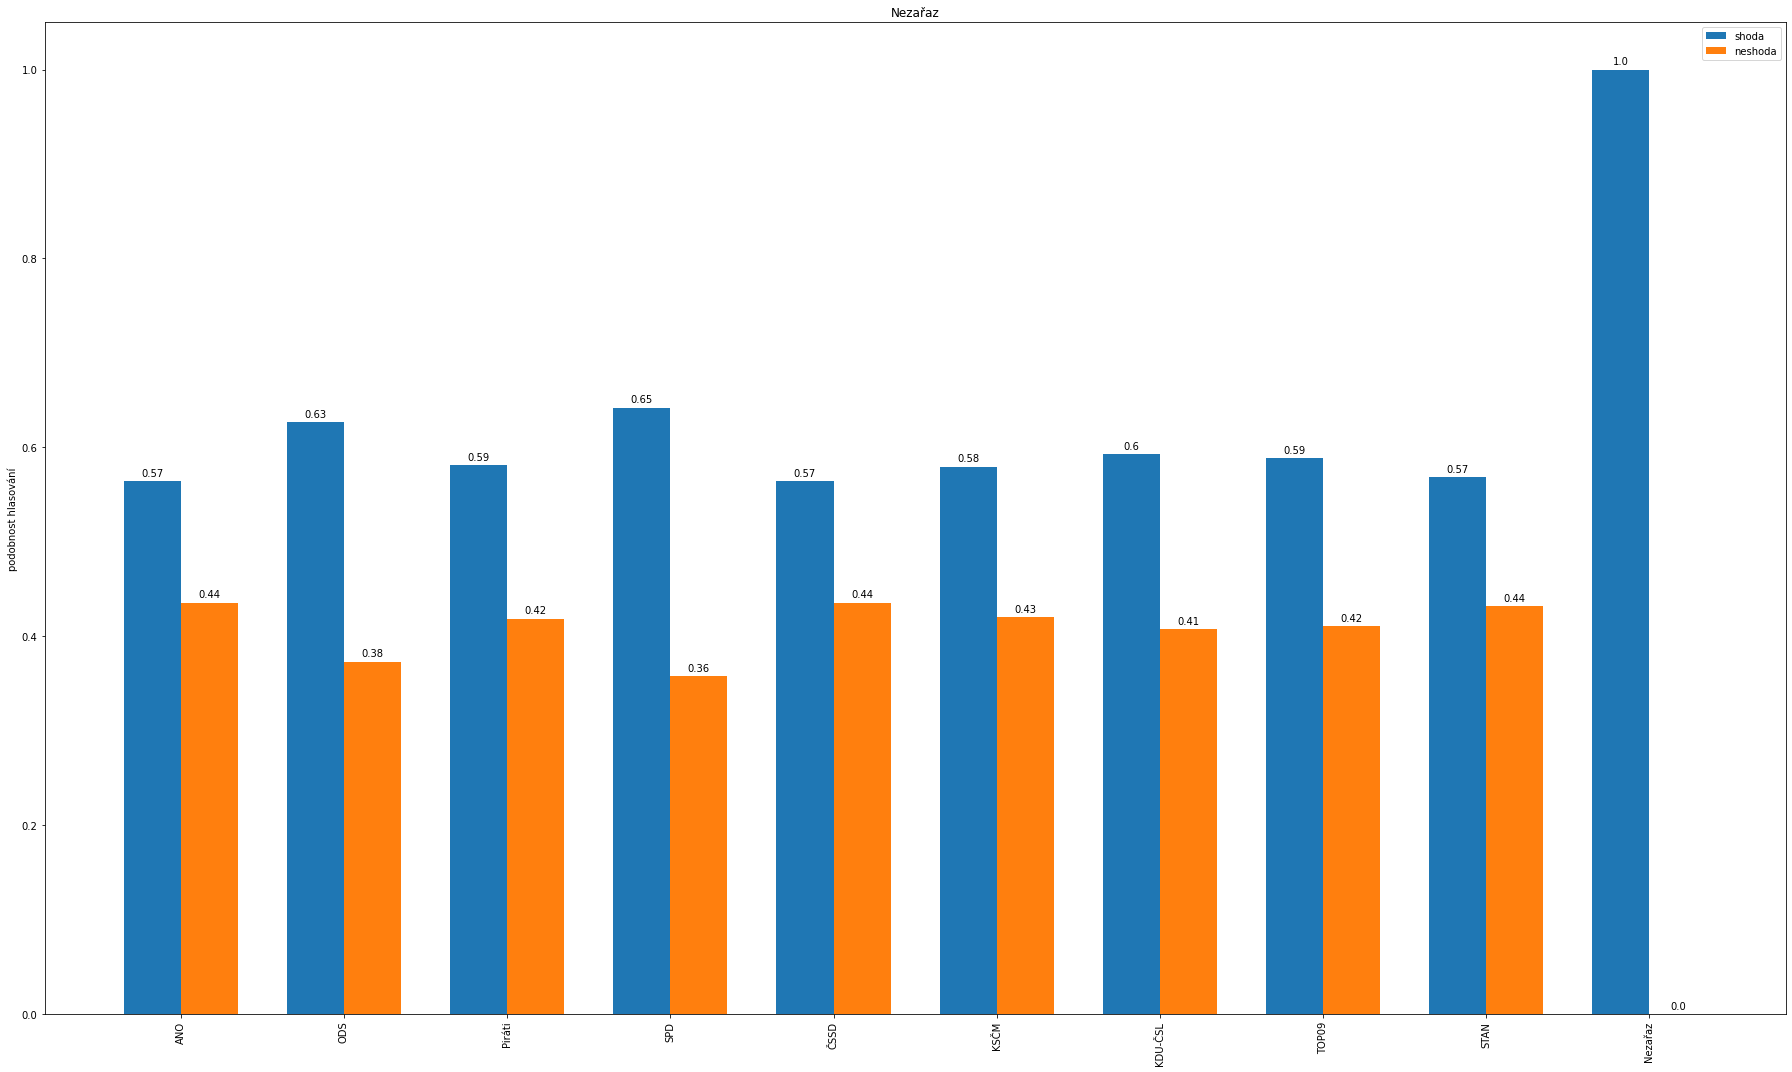

In [10]:
#vytvoreni tabulky
dfsh = df[["party", "vote", "meeting", "point"]]
#vyfiltrovani tabulky o nezaduci data
dfsh = dfsh[dfsh.vote != "0"]
dfsh = dfsh[dfsh.vote != "M"]

#count total of entries
ttlhl = dfsh.groupby(["party", "meeting", "point"]).size().reset_index().rename(columns={0:'rrecords'})

dfsh = dfsh.groupby(dfsh.columns.tolist()).size().reset_index().rename(columns={0:'records'})
dfsh = dfsh.sort_values(["party", "meeting", "point"])

#get numbers of meetings
mtnbrs = dfsh[["meeting"]]
mtnbrs.drop_duplicates(subset=["meeting"],keep="last",inplace=True)
mtnbrs = mtnbrs.sort_values(["meeting"])
mtnbrs = mtnbrs.meeting.to_list()

#get parties
parties = df[["party"]]
parties.drop_duplicates(subset=["party"],keep="first",inplace=True)
parties = parties.party.to_list()

#spojení tabulek
ddf = pd.merge(dfsh, ttlhl)
#ziskani procentualniho zastoupeni hlasovani bodu schuzek
ddf["perc"] = ddf.records/ddf.rrecords
ddf = ddf.sort_values(["party", "meeting", "point", "perc"])
#zanechani jen toho hlasovani s nejvetsim zastoupenim
ddf.drop_duplicates(subset=["party", "meeting", "point"],keep="last",inplace=True)

ddf = ddf[["party", "vote", "point", "meeting"]]




#graph
#kod pro popis baru vypujcen z https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        real_height = rect.get_height()
        height = (math.ceil(real_height*100))/100
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, real_height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#create graphs
names_graph = {}
for i in range(len(parties)):
    current_party = parties[i]
    
    names_graph[current_party] = plt.figure(i)
    
    N = len(parties_members[current_party])
    
    labels = parties

    similarPar    = list()
    differentPar  = list()
    
    currentParty = ddf[ddf.party == current_party]
    currentParty = currentParty[["vote", "point", "meeting"]]

    simPar = pd.merge(ddf, currentParty)
    suma   = ddf[ddf.party == current_party]
    suma = suma.party.to_list()
    suma = len(suma)
    suma = suma if suma != 0 else 1
    
    for party in parties:
        
        partyRec = simPar[simPar.party == party]

        simNum     = partyRec.party.to_list()
        simNum     = len(simNum)
        nosimNum   =  suma - simNum

        #translate to percentage
        simNum     = simNum/suma
        nosimNum   = nosimNum/suma
        
        similarPar.append(simNum)
        differentPar.append(nosimNum)
        
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(25,15))
    rects1 = ax.bar(x-width/2, similarPar, width, label='shoda')
    rects2 = ax.bar(x+width/2, differentPar, width, label='neshoda')
    
    ax.set_ylabel('podobnost hlasování')
    ax.set_title(current_party)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.xticks(rotation=90)
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    
plt.show()